In [1]:
from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TSContinuous
import librosa
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import soundfile as sf

WARNING    /home/timon-l/devel/CITS5551/AcousticTrafficMonitoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]
  from .autonotebook import tqdm as notebook_tqdm



In [ ]:
def audio_to_features(
    input_path: str,
    output_dir: str,
    target_sr: int = 16000
) -> str:
    fs = 110e3
    raster_period = 10e-3
    max_spike_per_raster_period = 15
    add_noise = False
    add_offset = False
    add_mismatch = False
    seed = None

    if not os.path.exists(input_path):
        logging.error(f"File does not exist: {input_path}")
        return ''

    y, sr = librosa.load(input_path, sr=target_sr, mono=True)

    dt = 1.0 / target_sr
    ts = TSContinuous.from_clocked(y, dt=dt, name='Audio input')

    afe = AFESim(
        fs=fs,
        raster_period=raster_period,
        max_spike_per_raster_period=max_spike_per_raster_period,
        add_noise=add_noise,
        add_offset=add_offset,
        add_mismatch=add_mismatch,
        seed=seed
    ).timed()

    features, stat, rec = afe(ts, record=True)
    raster = features.raster(dt=raster_period, add_events=True)

    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(211)
    ts.plot()
    ax.set_xticks([])
    ax.set_xlabel("")

    ax = fig.add_subplot(212)
    plt.imshow(raster.T, aspect="auto", origin="lower")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Output channel")
    ax.set_title("Spiking output")
    plt.tight_layout()
    plt.show()

    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(input_path))[0]
    out_name = f"{base}.npy"
    out_path = os.path.join(output_dir, out_name)
    np.save(out_path, raster)
    logging.info(f"Saved AFE raster: {out_path}")
    return out_path


In [3]:
def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate)

In [4]:
def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

In [5]:
def reverse(y):
    return y[::-1]

In [6]:

def bandpass_filter(y: np.ndarray) -> np.ndarray:
    return librosa.effects.preemphasis(y, coef=0.97)

In [7]:
def estimate_noise(y: np.ndarray, sr: int, noise_duration = 0.5) -> float:
    n = int(noise_duration * sr)
    noise_rms = np.sqrt(np.mean(y[:n]**2))
    return noise_rms

In [ ]:
def normalize_audio(y: np.ndarray) -> np.ndarray:
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    peak = np.max(np.abs(y)) + 1e-9
    return y / peak

In [9]:
def augment_with_background(y, bg, snr_db=5):
    if len(bg) < len(y):
        bg = np.tile(bg, int(np.ceil(len(y)/len(bg))))
    bg = bg[:len(y)]
    rms_y = np.sqrt(np.mean(y**2))
    rms_bg = np.sqrt(np.mean(bg**2))
    alpha = rms_y / (10**(snr_db/20)) / (rms_bg + 1e-6)
    return y + alpha * bg

In [ ]:
def segment_and_filter(
    input_path: str,
    output_dir: str,
    segment_length: float = 8.0
) -> list:
    y, sr = librosa.load(input_path, sr=16000, mono=True)
    total = len(y)
    seg_samples = int(segment_length * sr)
    if total < seg_samples:
        return []

    metrics = []  # (start, rms, centroid)
    for start in range(0, total - seg_samples + 1, seg_samples):
        seg = y[start:start + seg_samples]
        rms = np.sqrt(np.mean(seg ** 2))
        cent = np.mean(librosa.feature.spectral_centroid(y=seg, sr=sr)[0])
        metrics.append((start, rms, cent))

    # dynamic thresholds
    rms_vals = np.array([m[1] for m in metrics])
    cent_vals = np.array([m[2] for m in metrics])
    rms_th = float(np.median(rms_vals) * 1.2)
    cent_med = float(np.median(cent_vals))

    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(input_path))[0]
    valid = []
    for start, rms, cent in metrics:
        if rms >= rms_th:
            seg = y[start:start + seg_samples]
            # label by centroid: low->CV(1), high->car(0)
            label = 1 if cent < cent_med else 0
            seg_name = f"{base}_s{start}_lbl{label}.flac"
            seg_path = os.path.join(output_dir, seg_name)
            sf.write(seg_path, seg, sr)
            logging.info(f"Saved segment: {seg_path}")
            valid.append((seg_path, label, start))
    return valid

In [ ]:
def augment_cv(audio, sr, noise_path=None):
    augmented = []

    reversed_audio = audio[::-1]
    augmented.append(reversed_audio)

    for rate in [0.9, 1.1]:
        y_stretch = librosa.effects.time_stretch(audio, rate=rate)
        augmented.append(y_stretch)

    if noise_path:
        noise, _ = librosa.load(noise_path, sr=sr)
        min_len = min(len(audio), len(noise))
        mixed = audio[:min_len] + 0.2 * noise[:min_len]
        augmented.append(mixed)

    return augmented

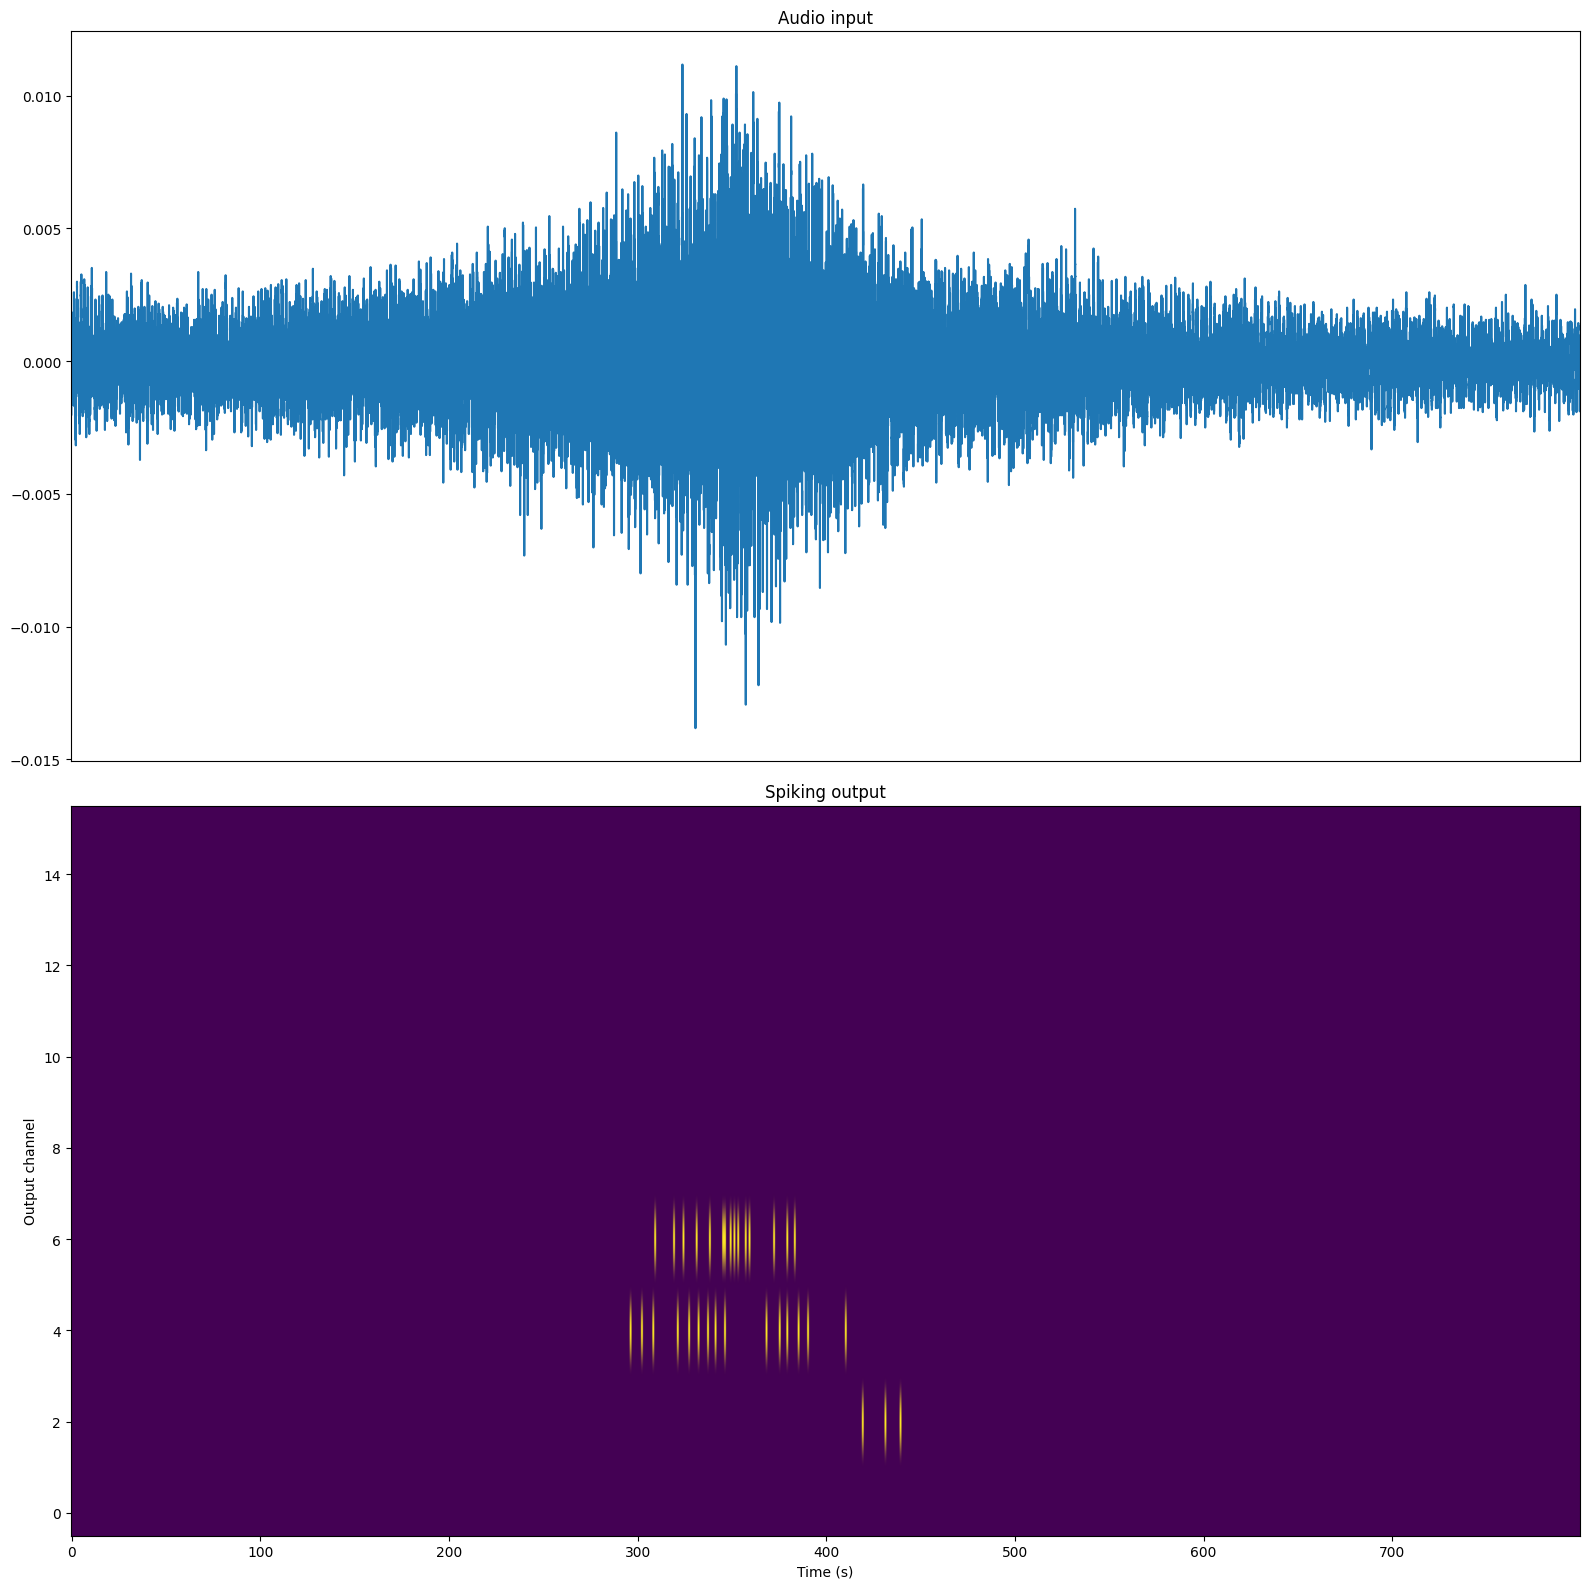

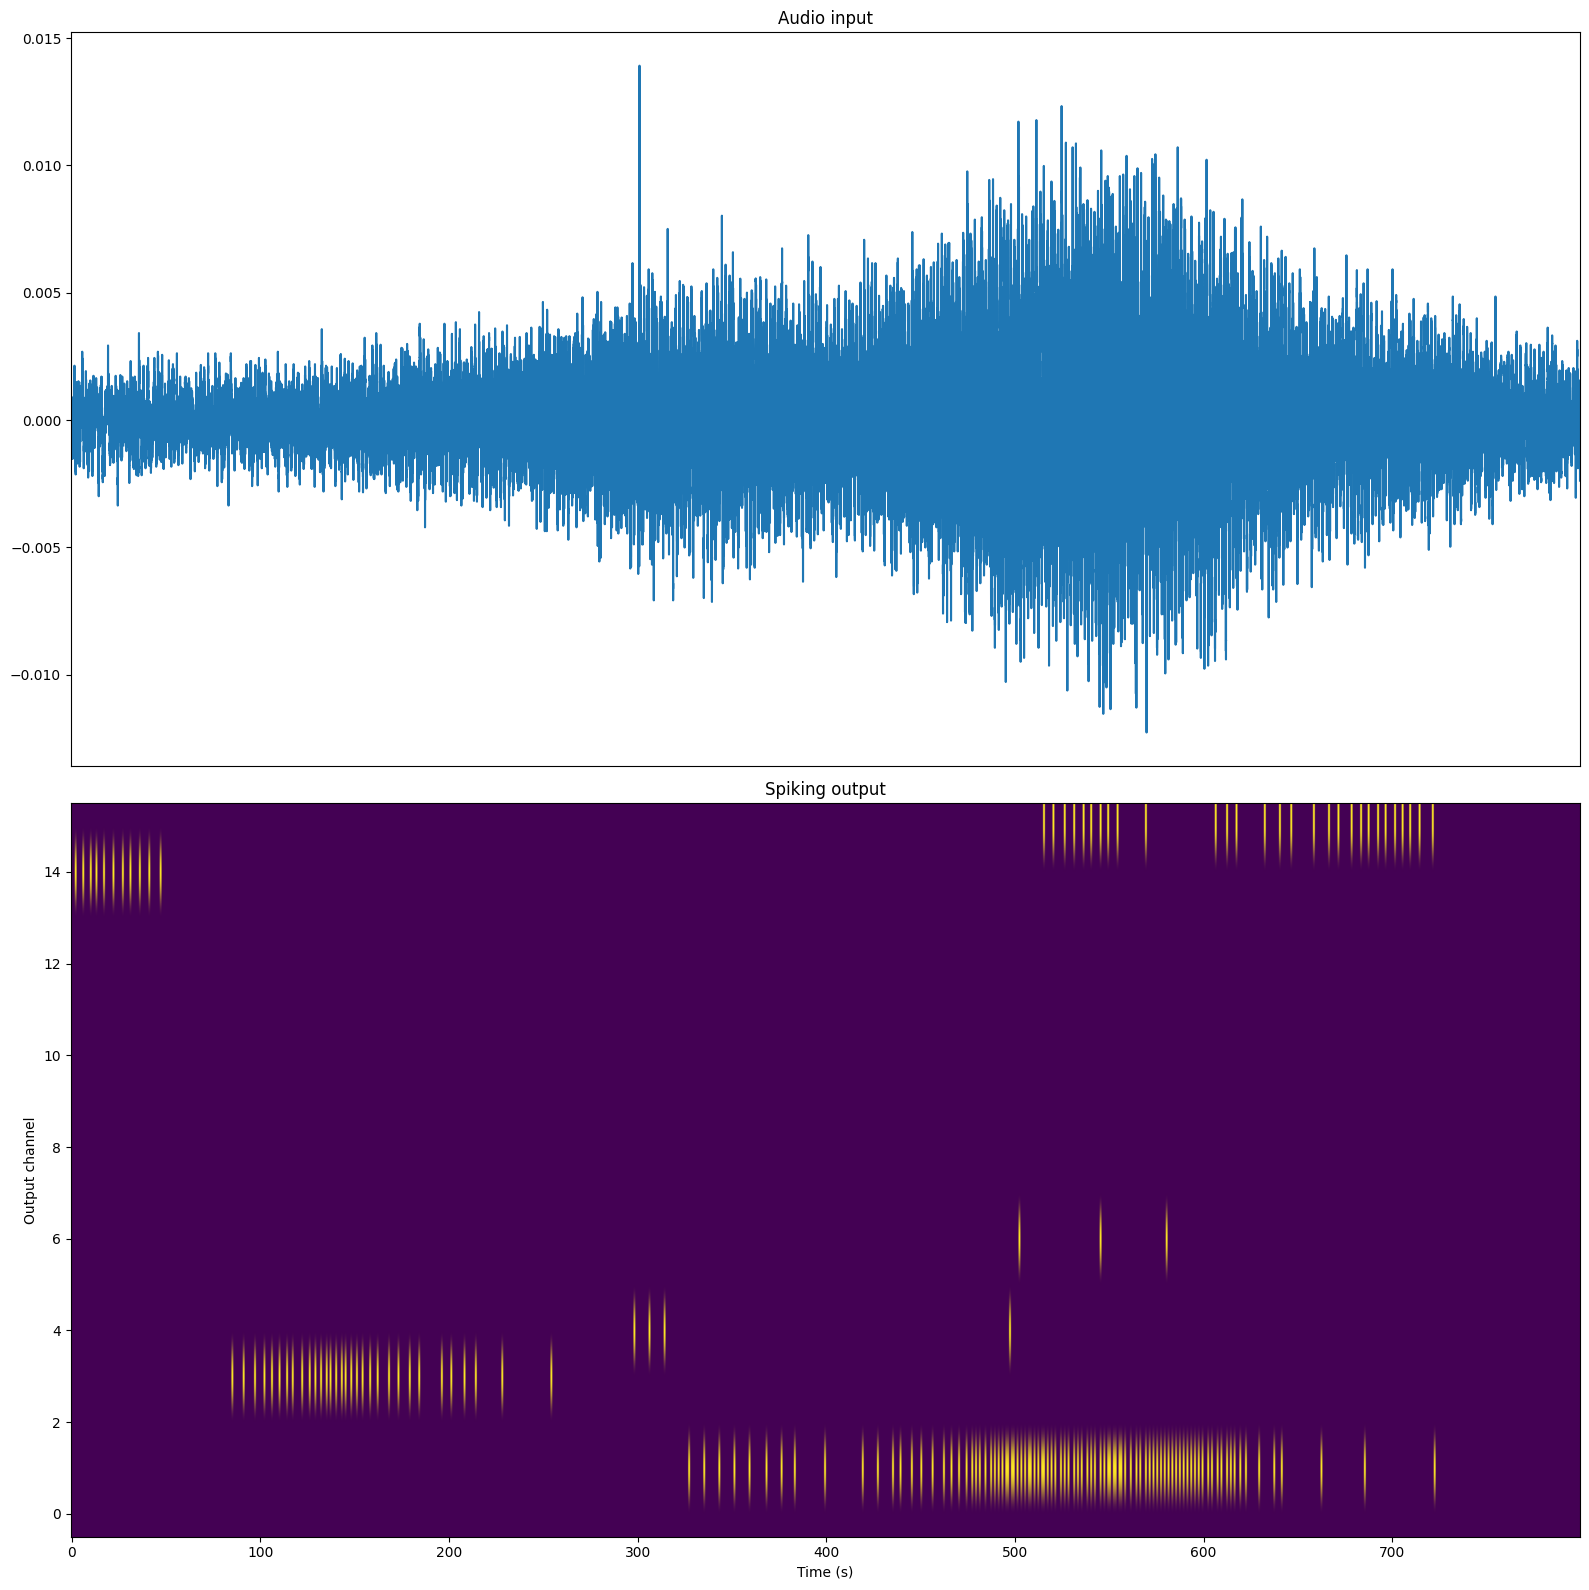

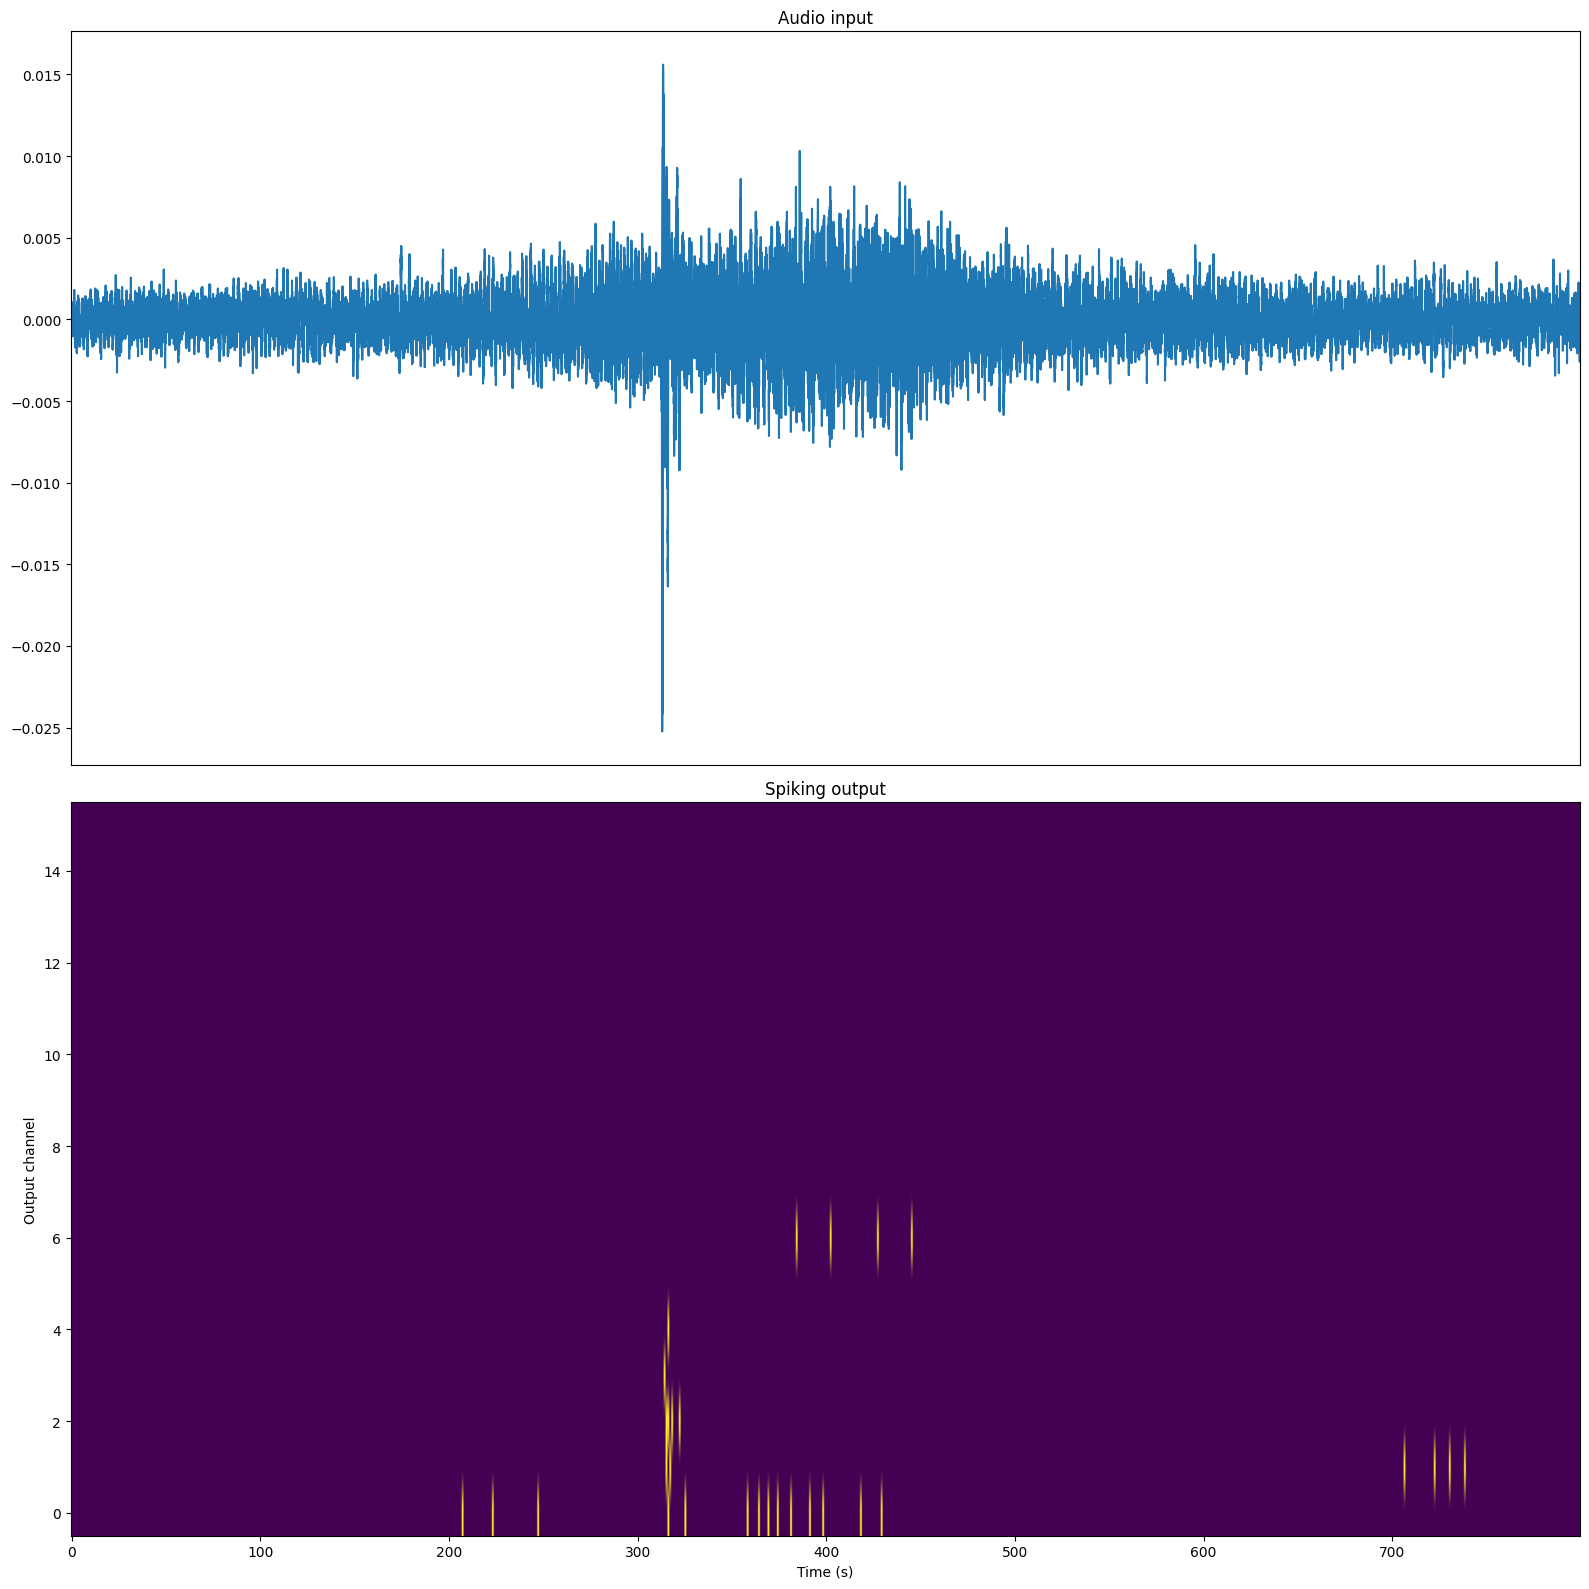

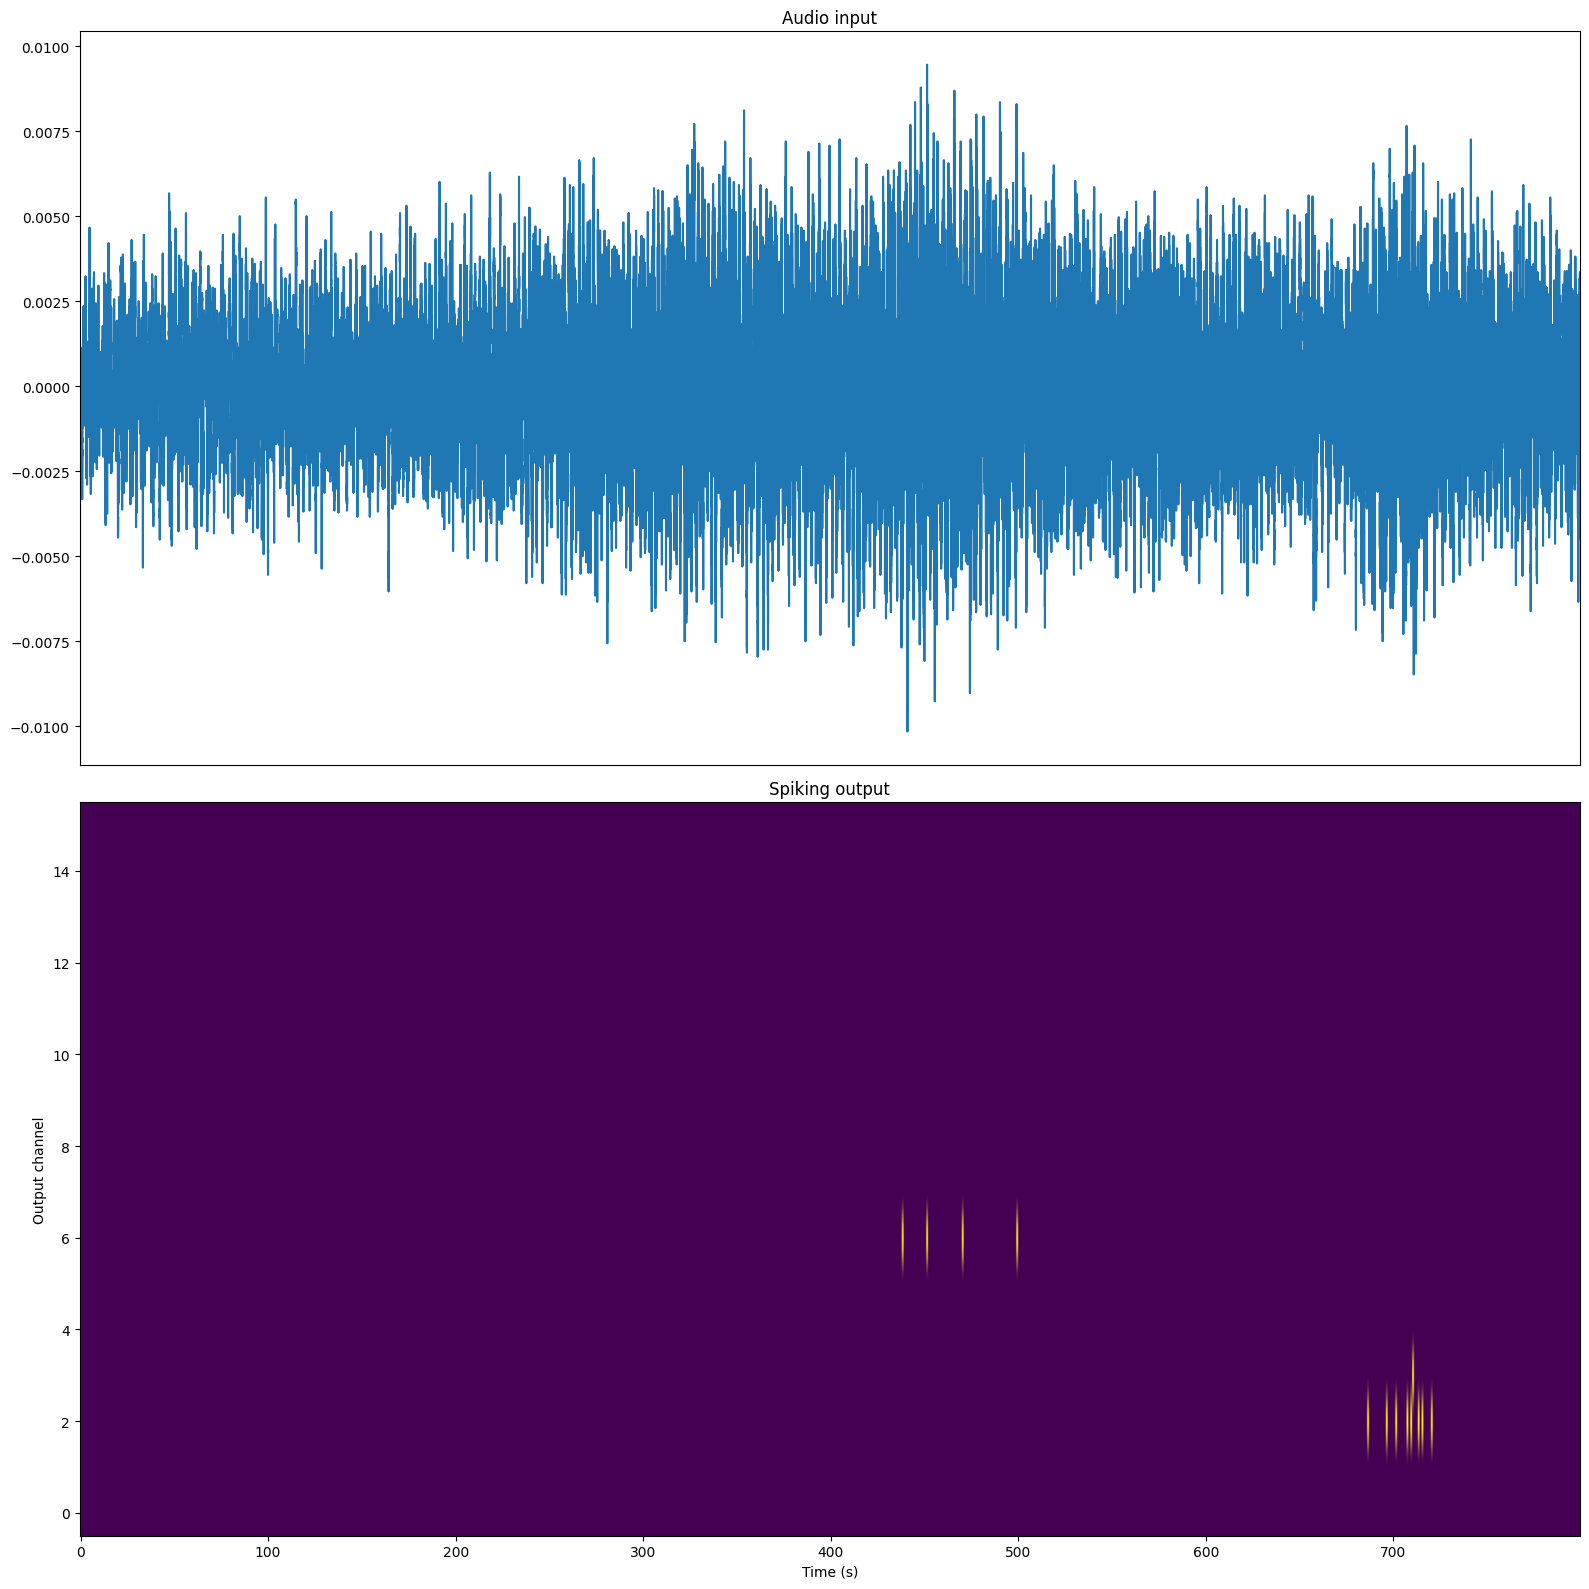

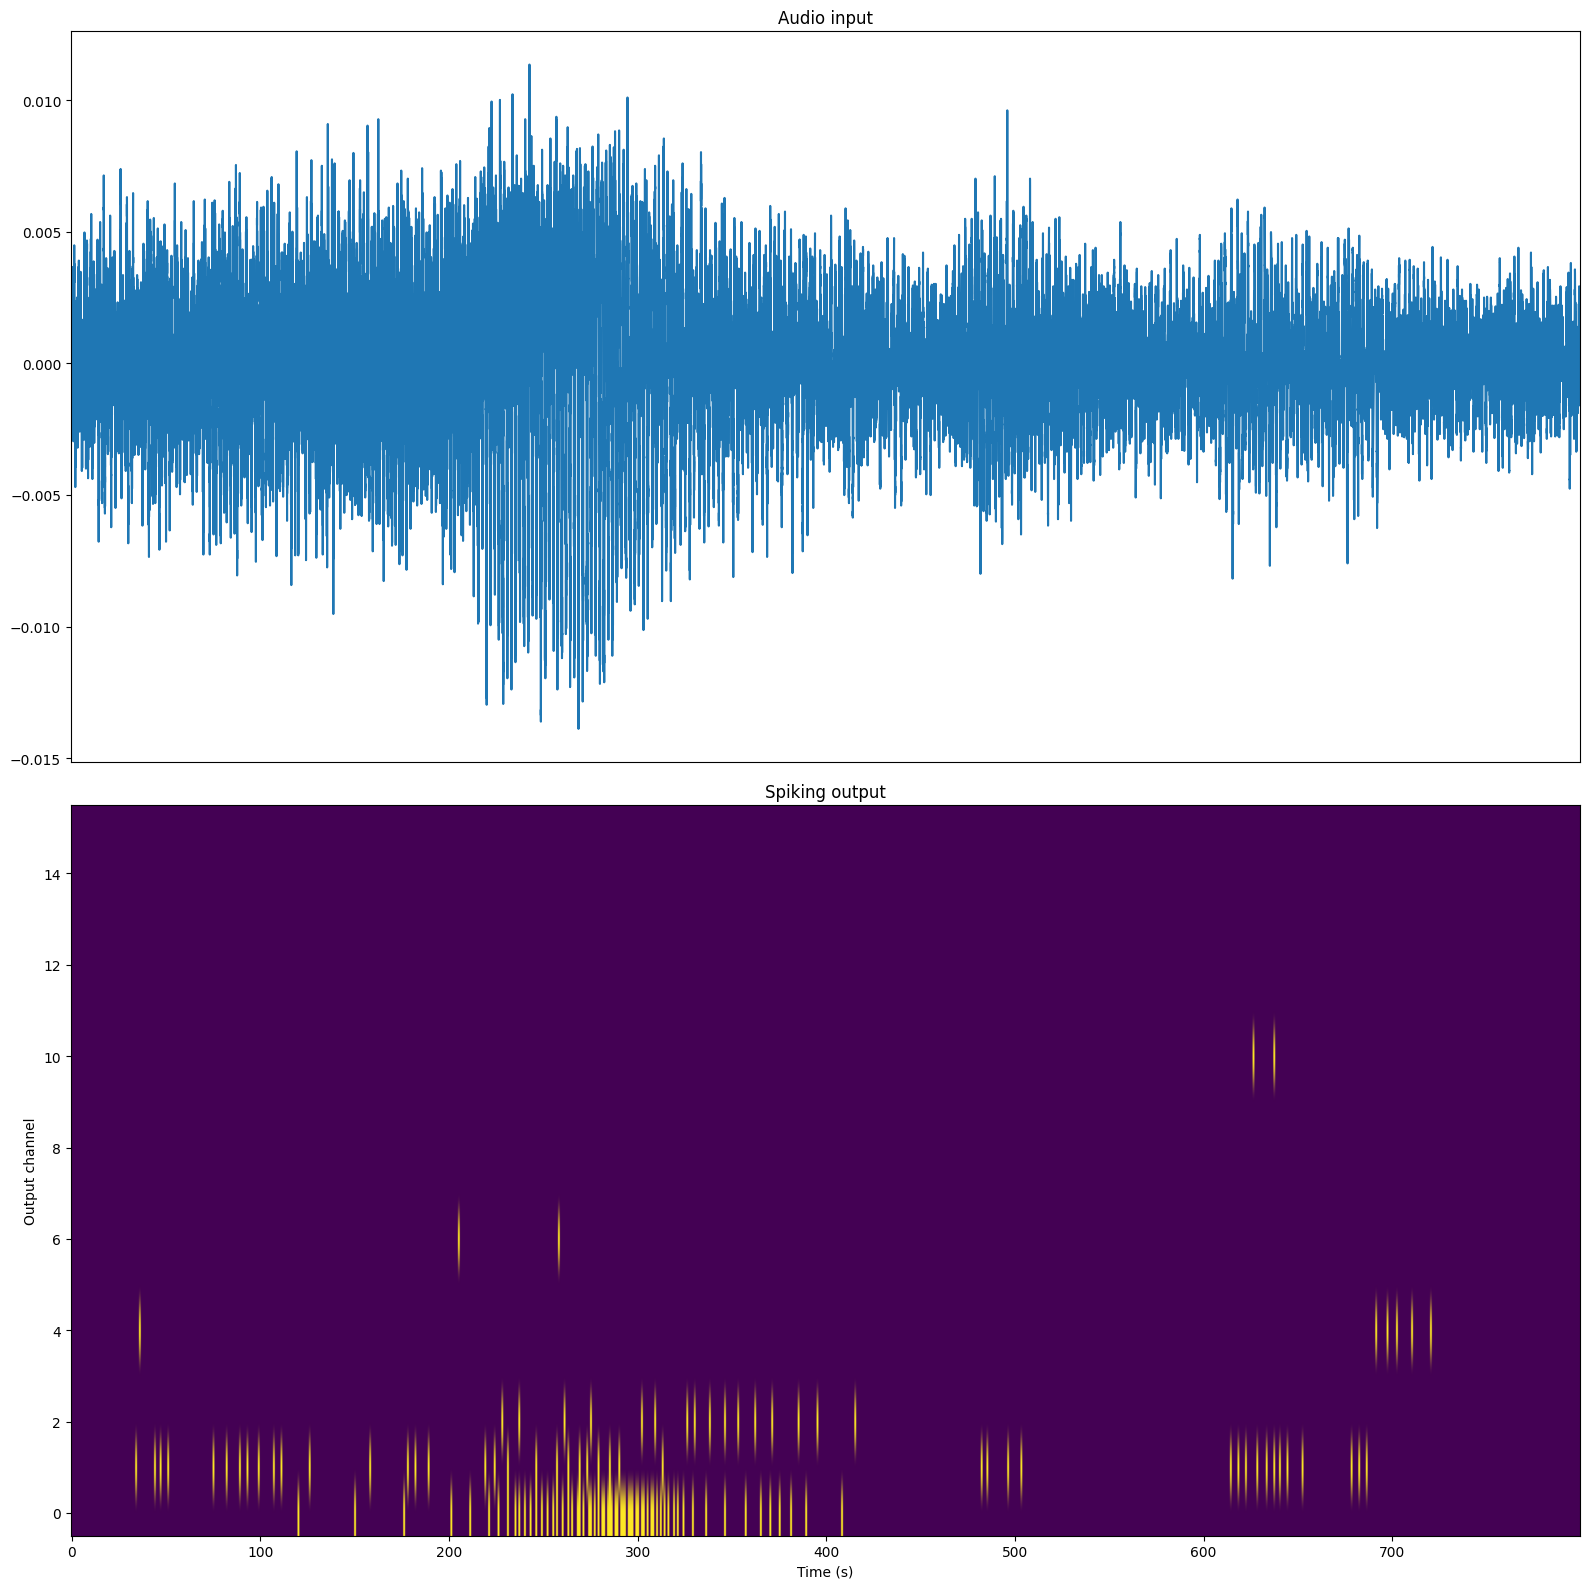

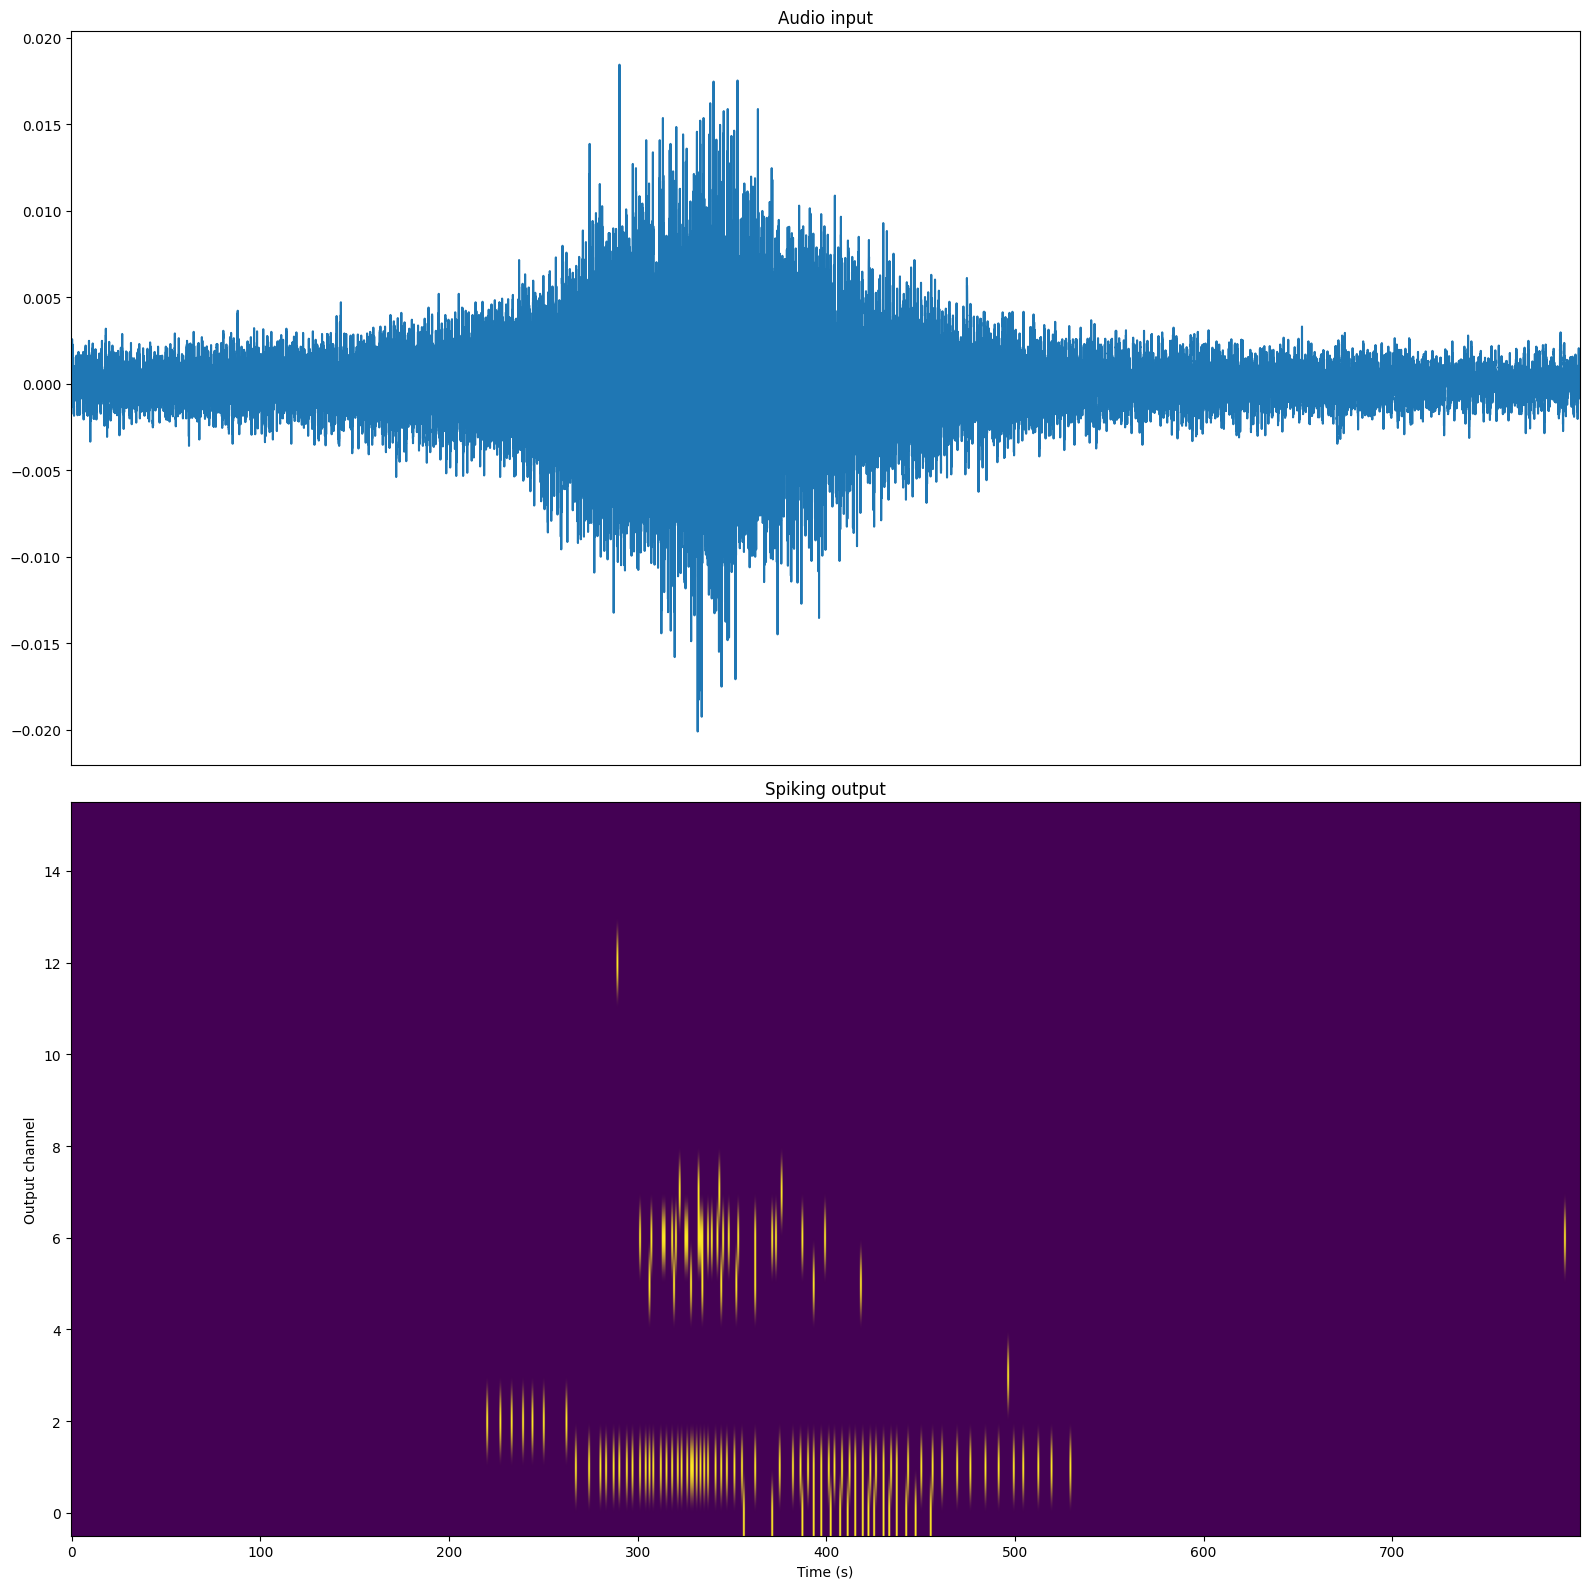

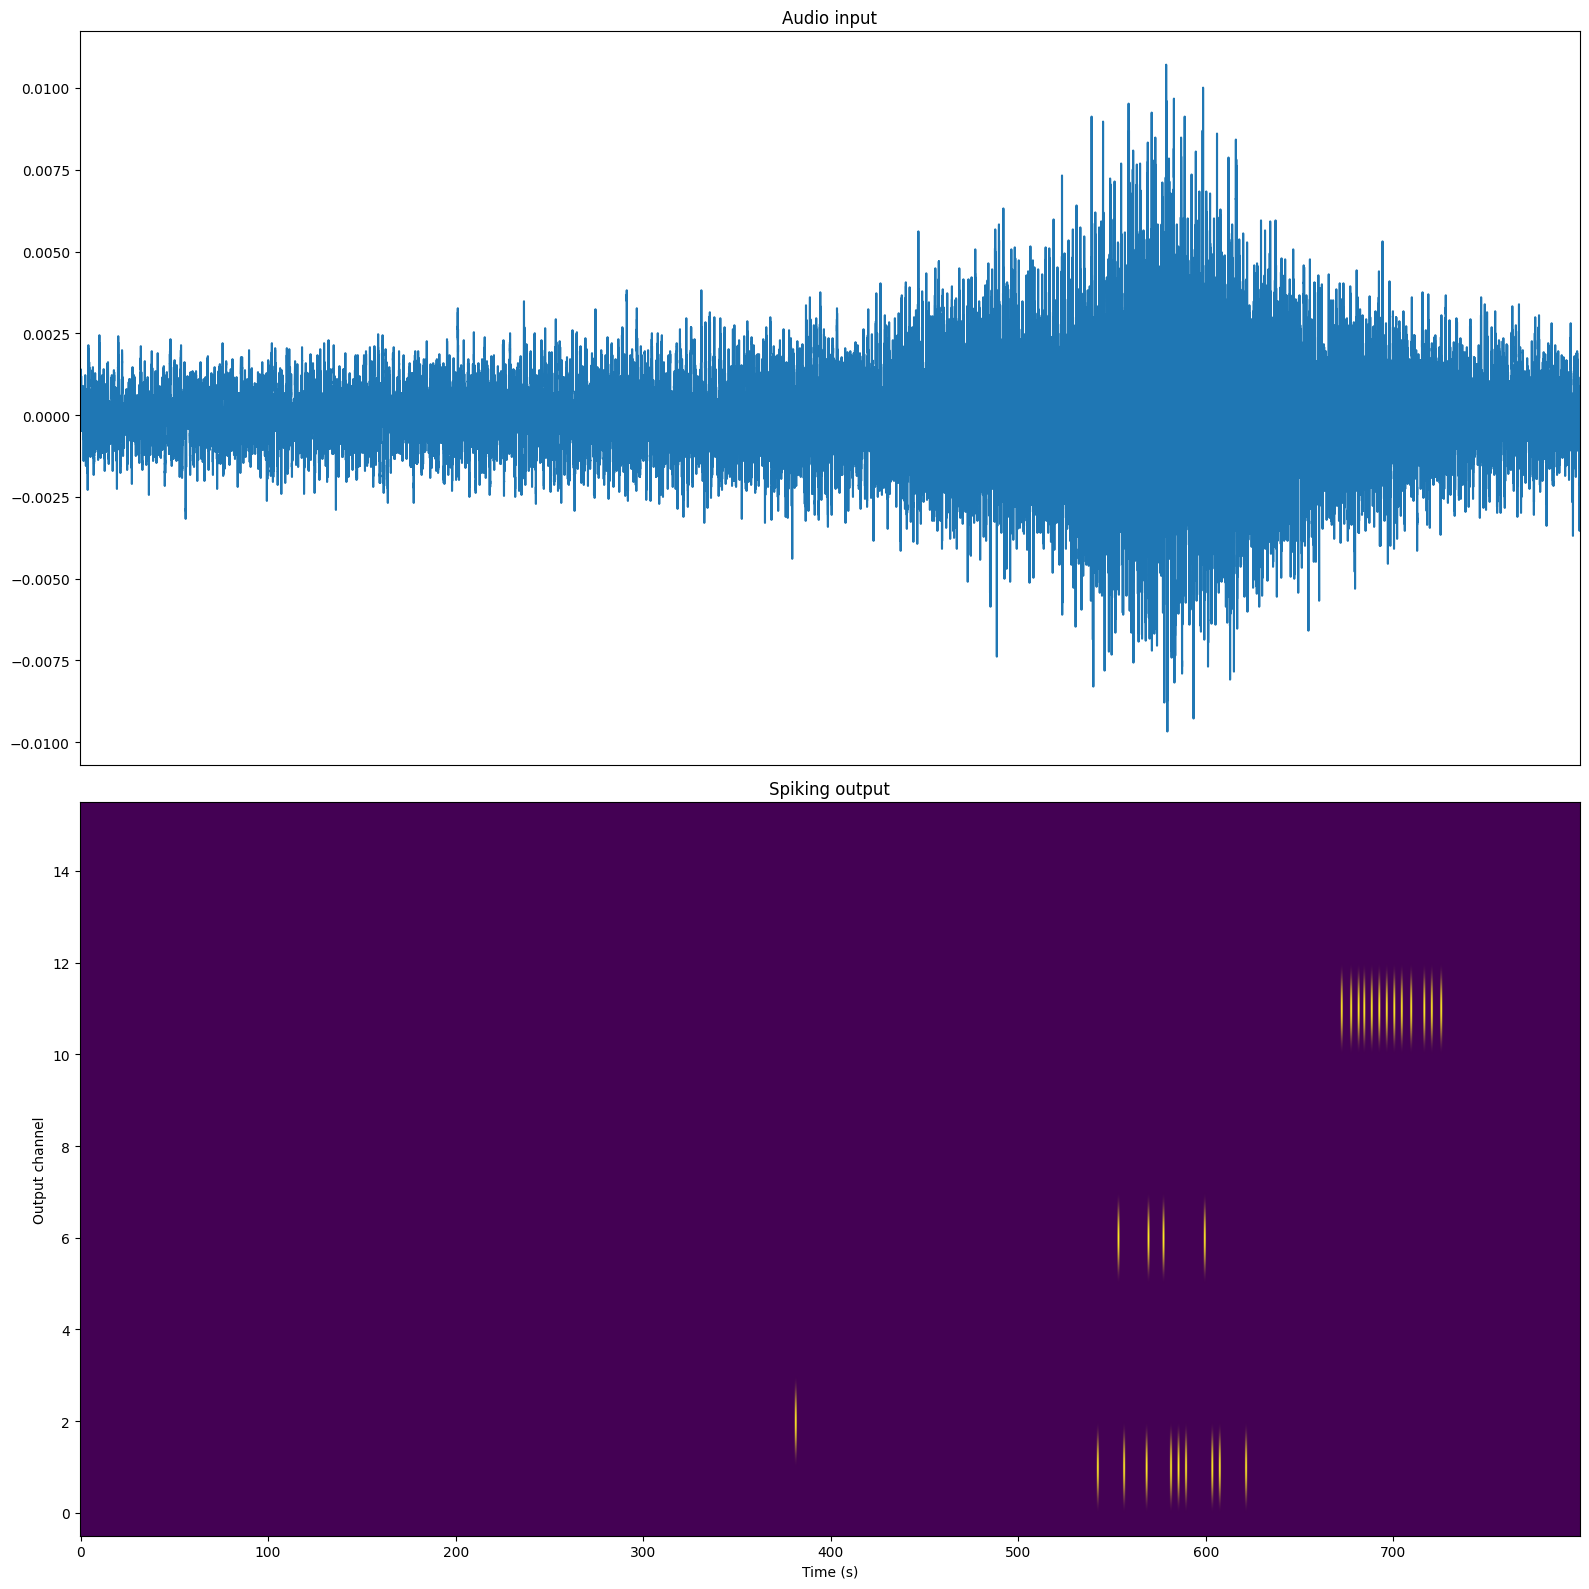

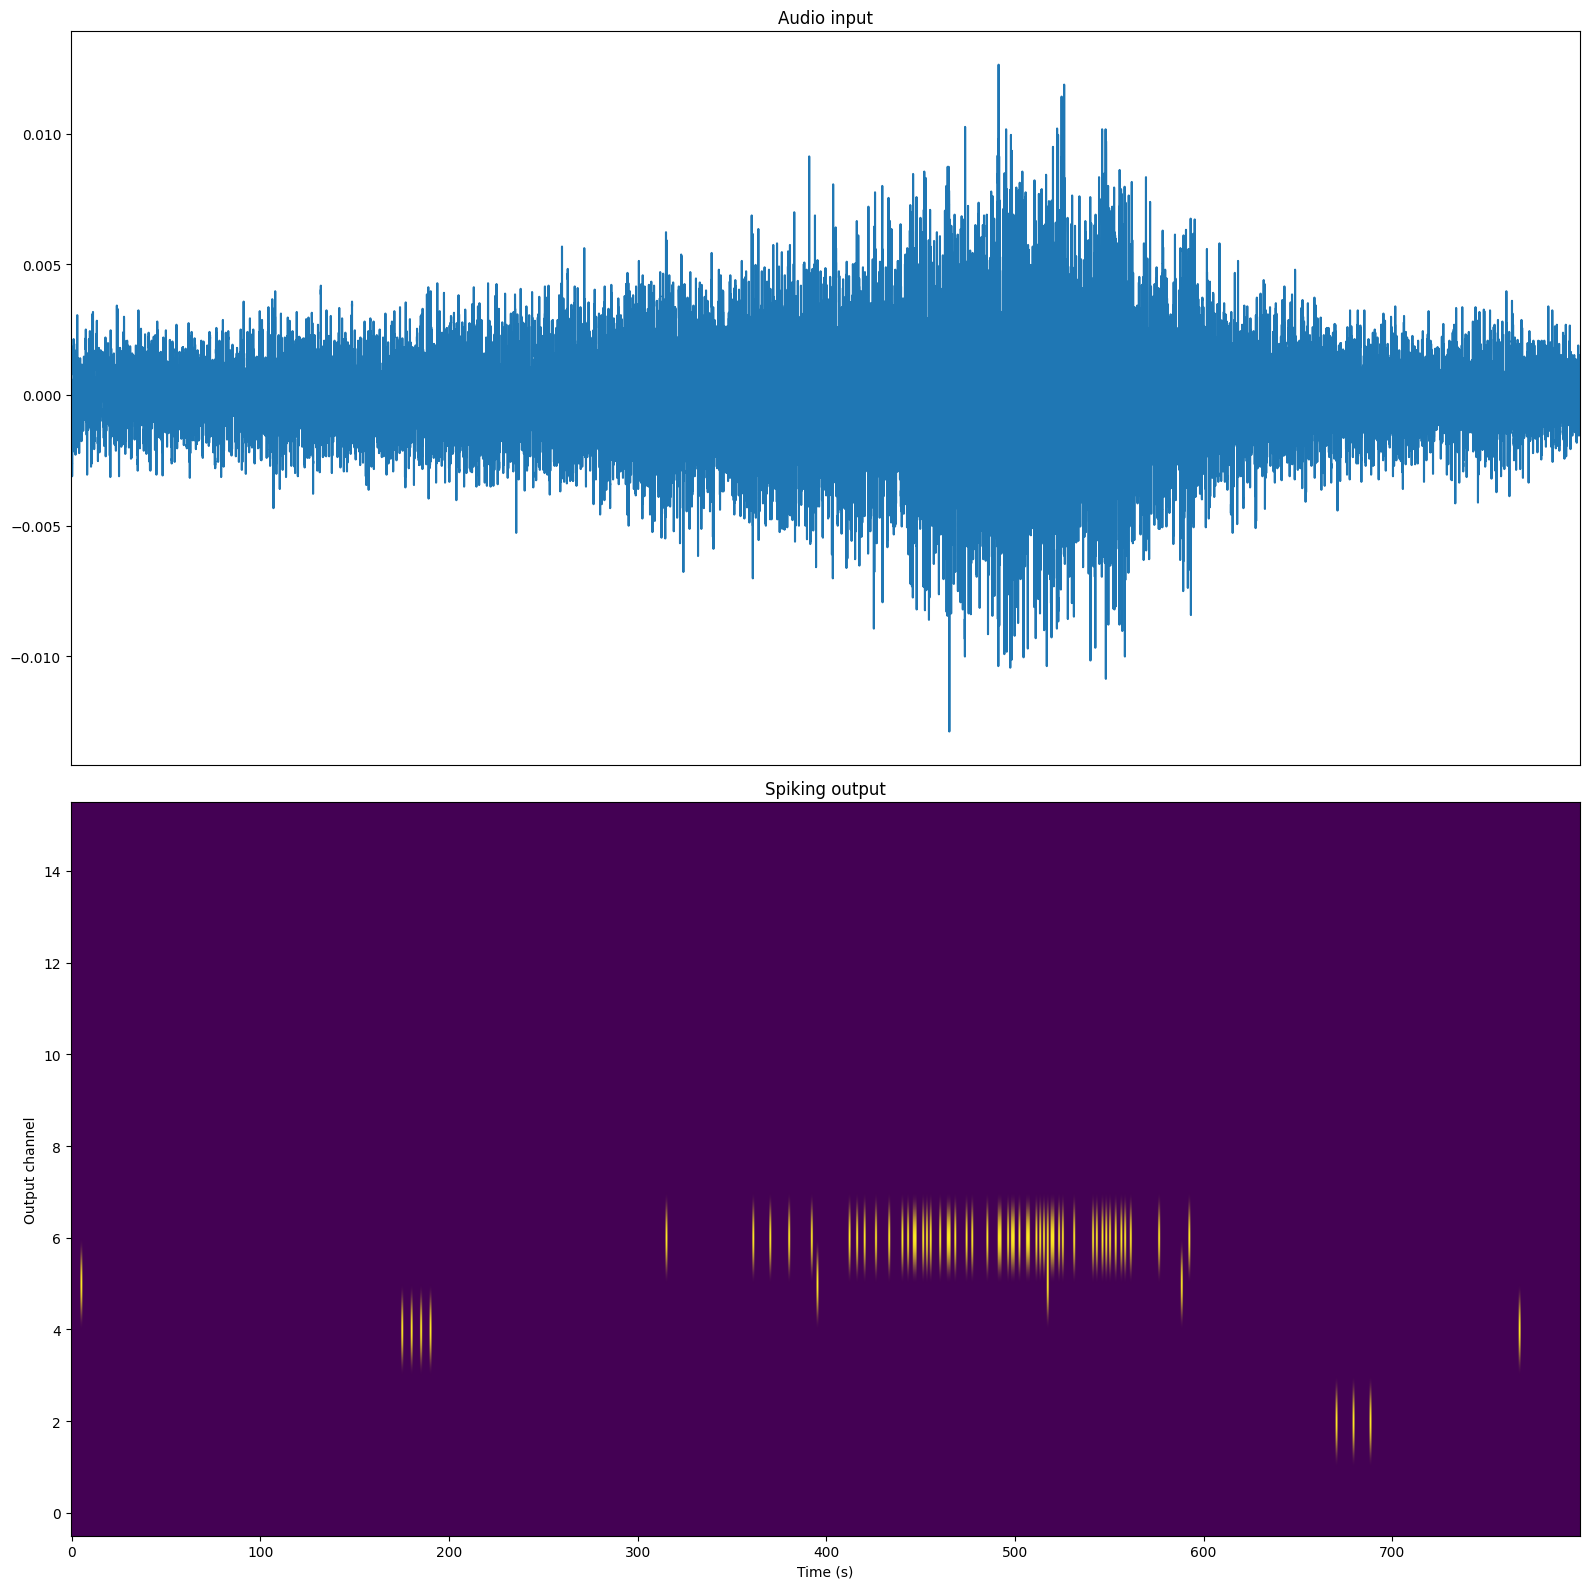

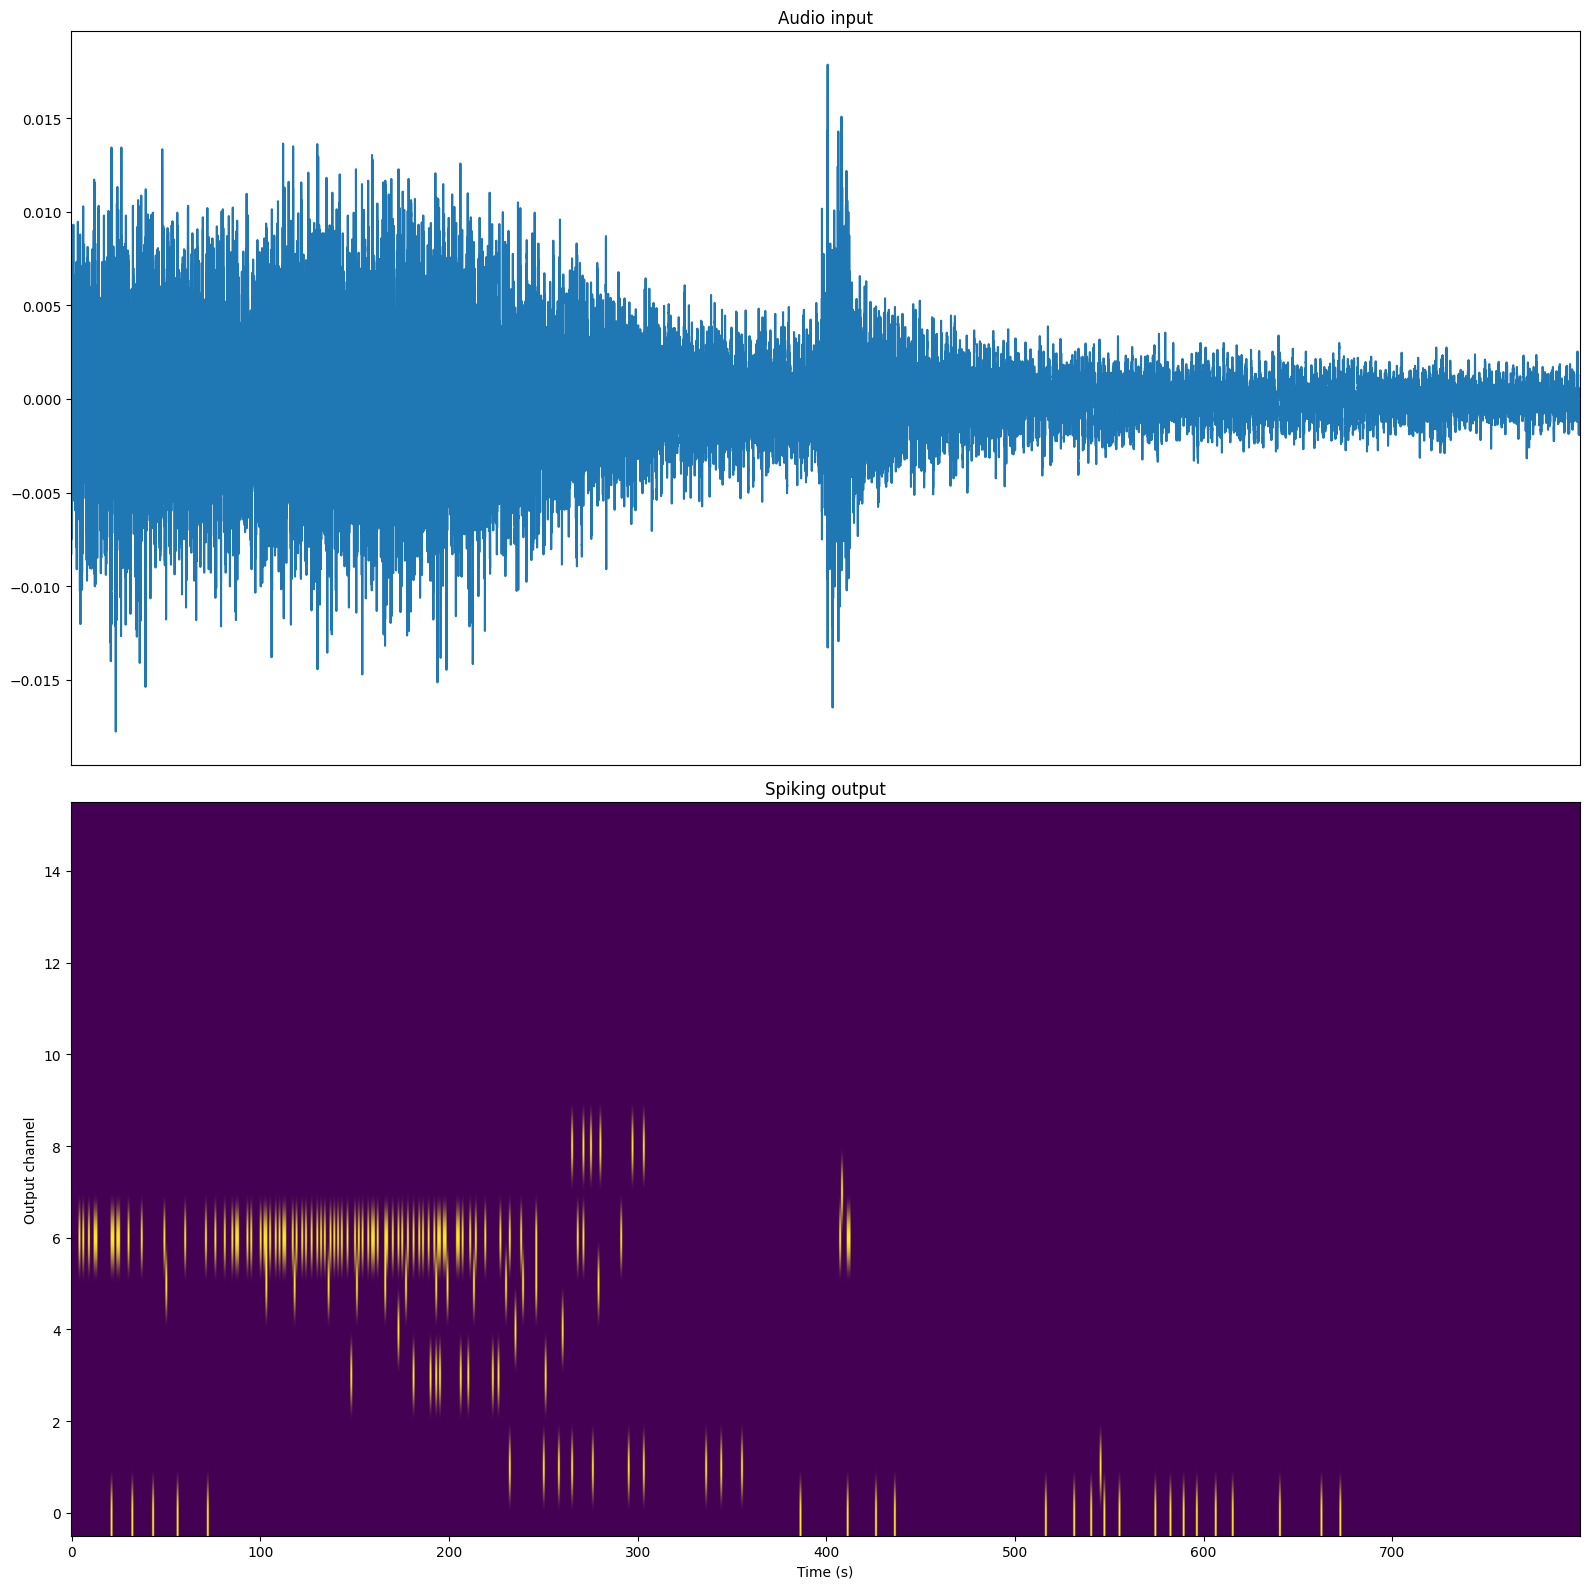

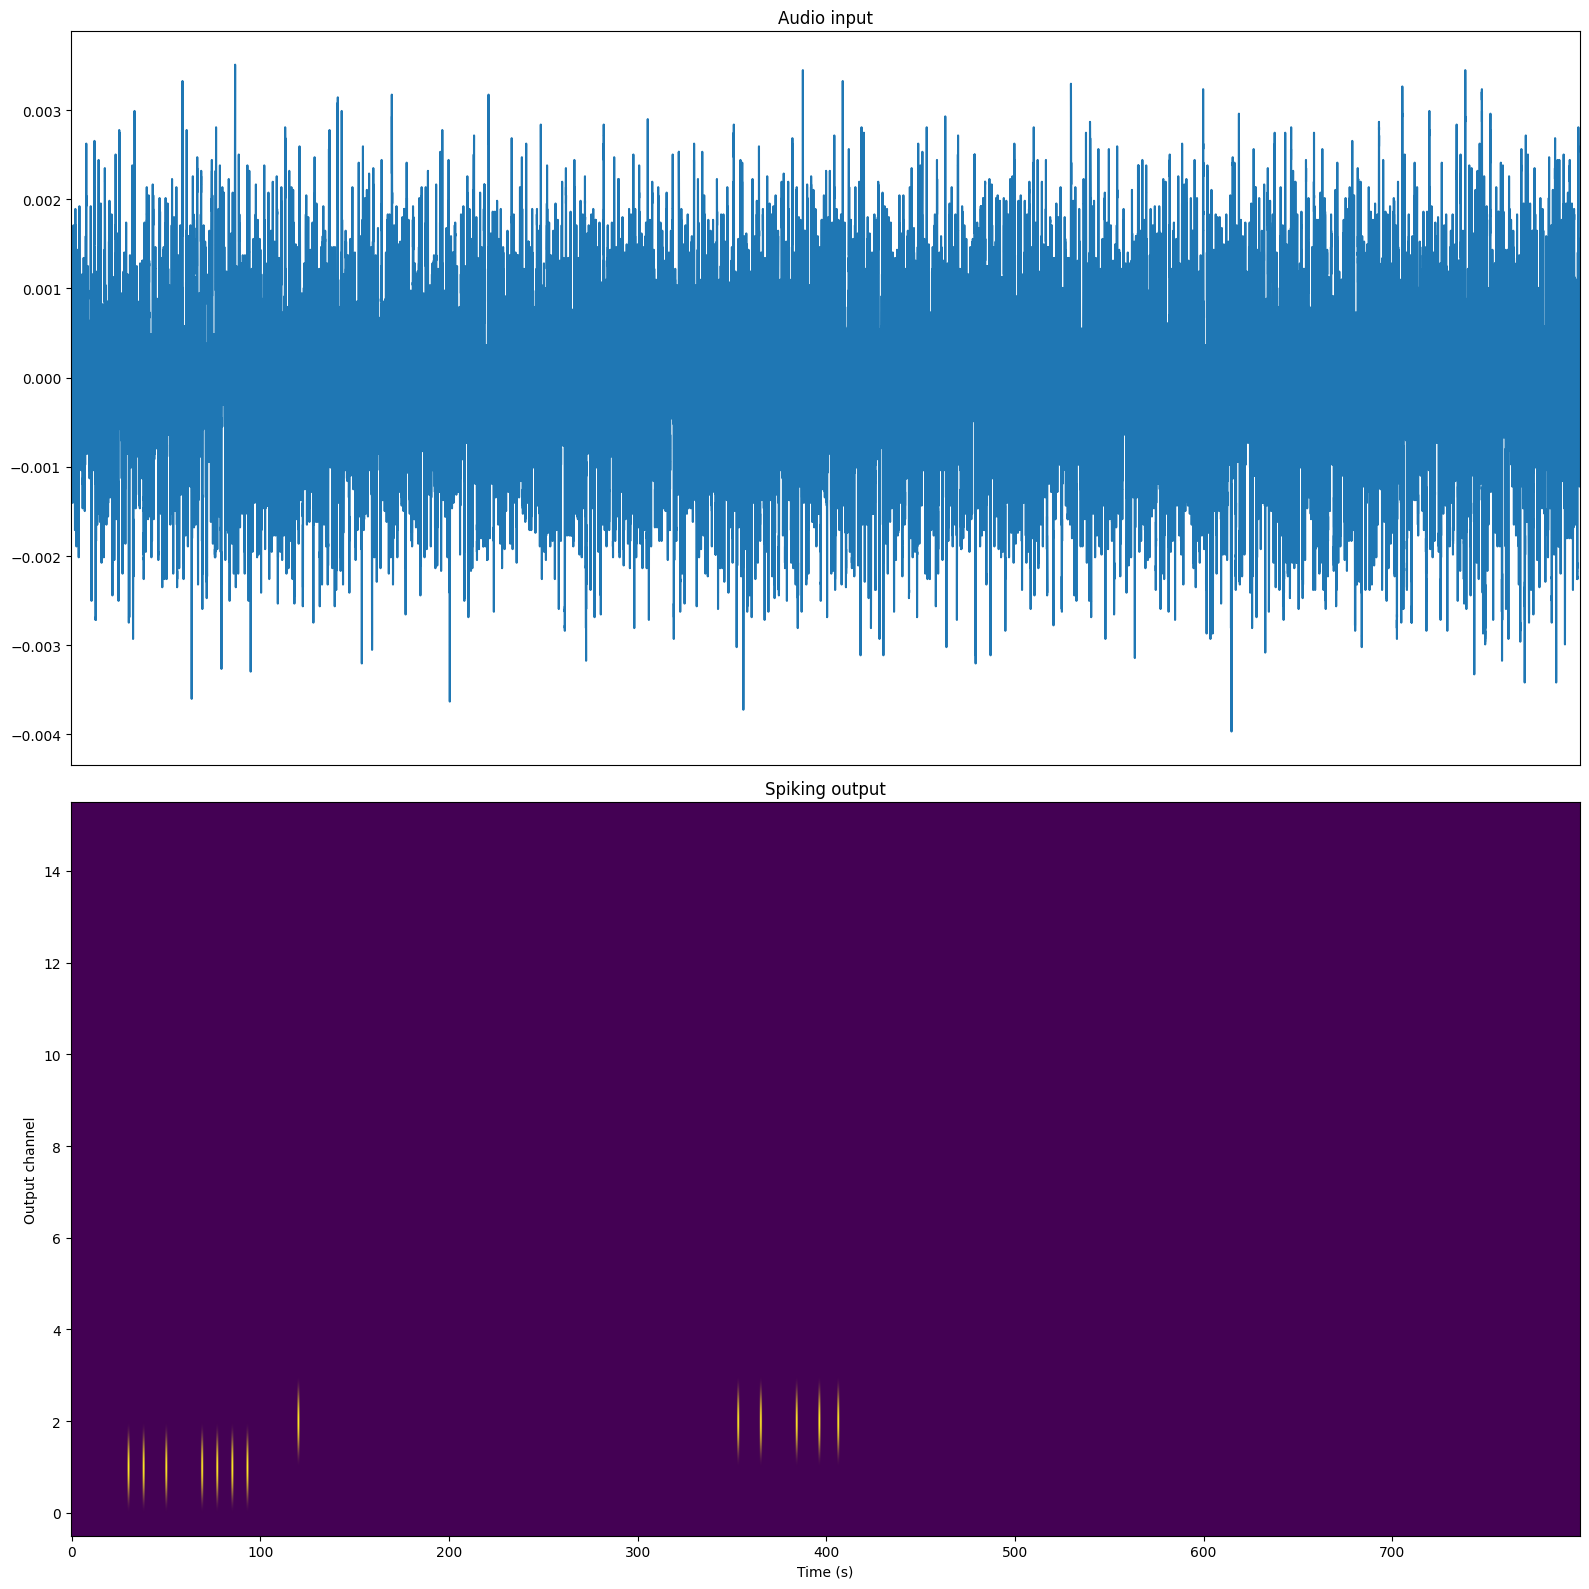

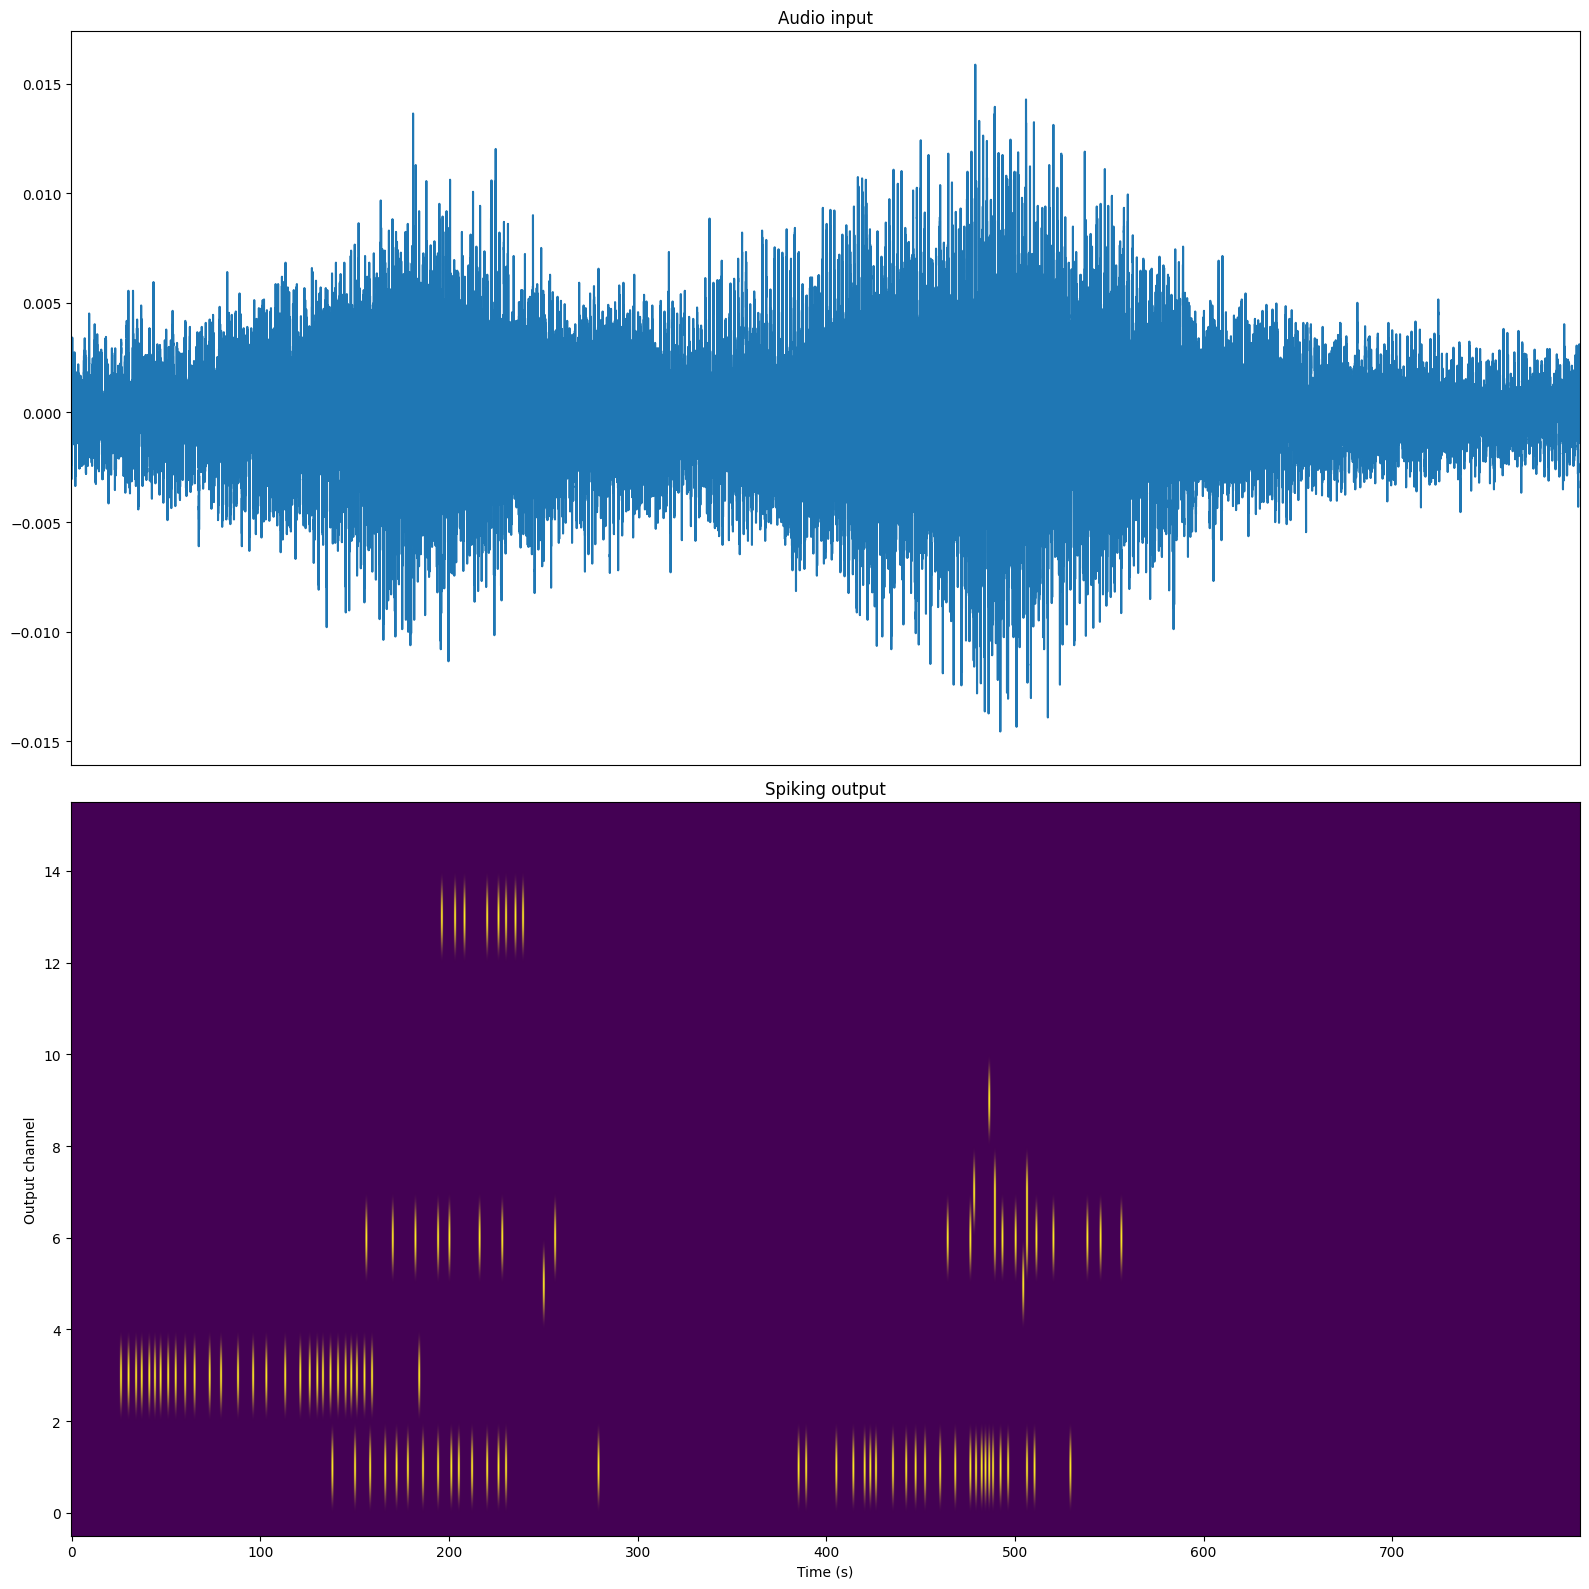

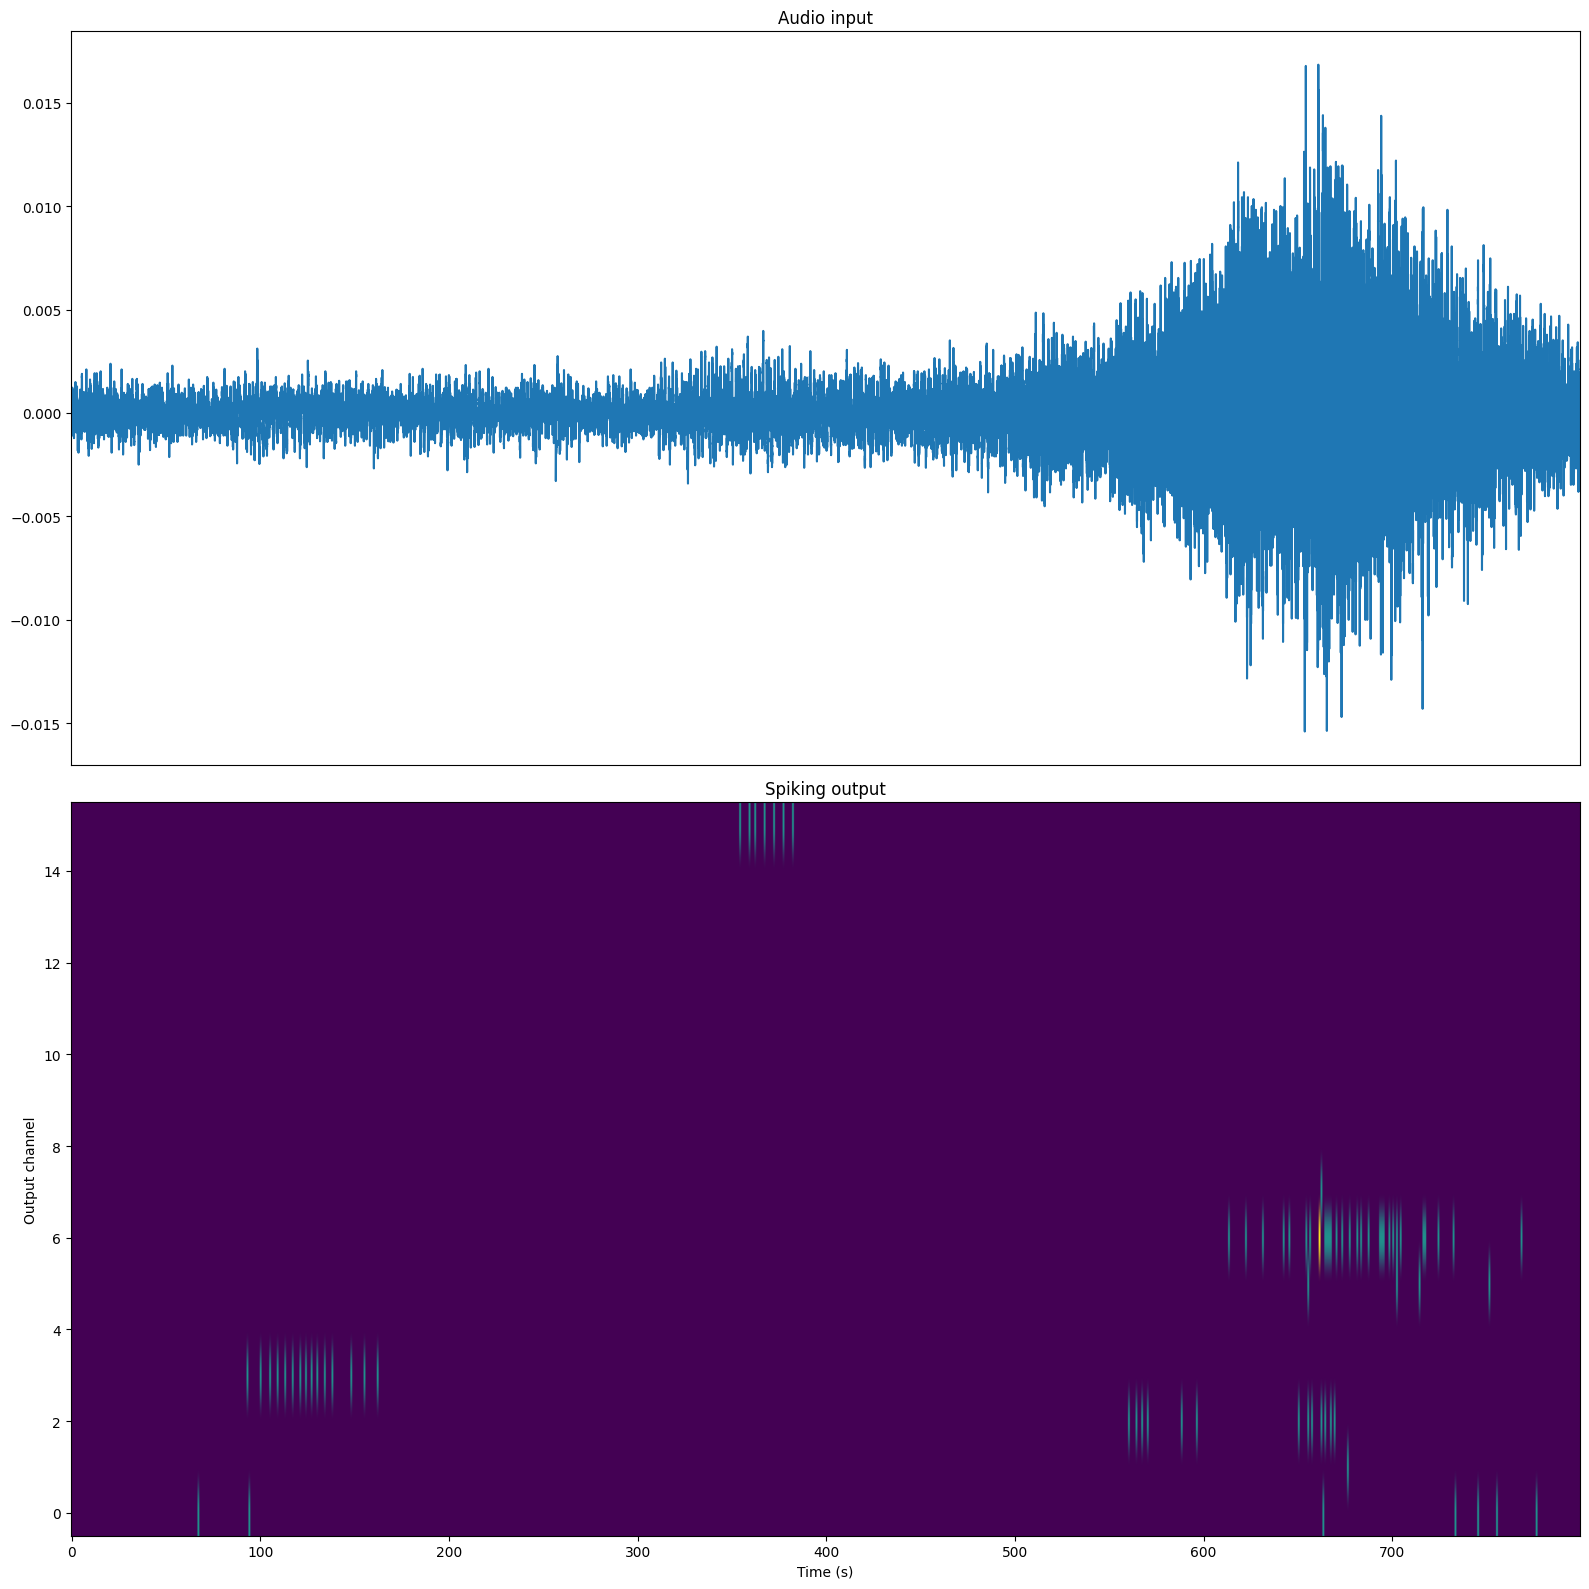

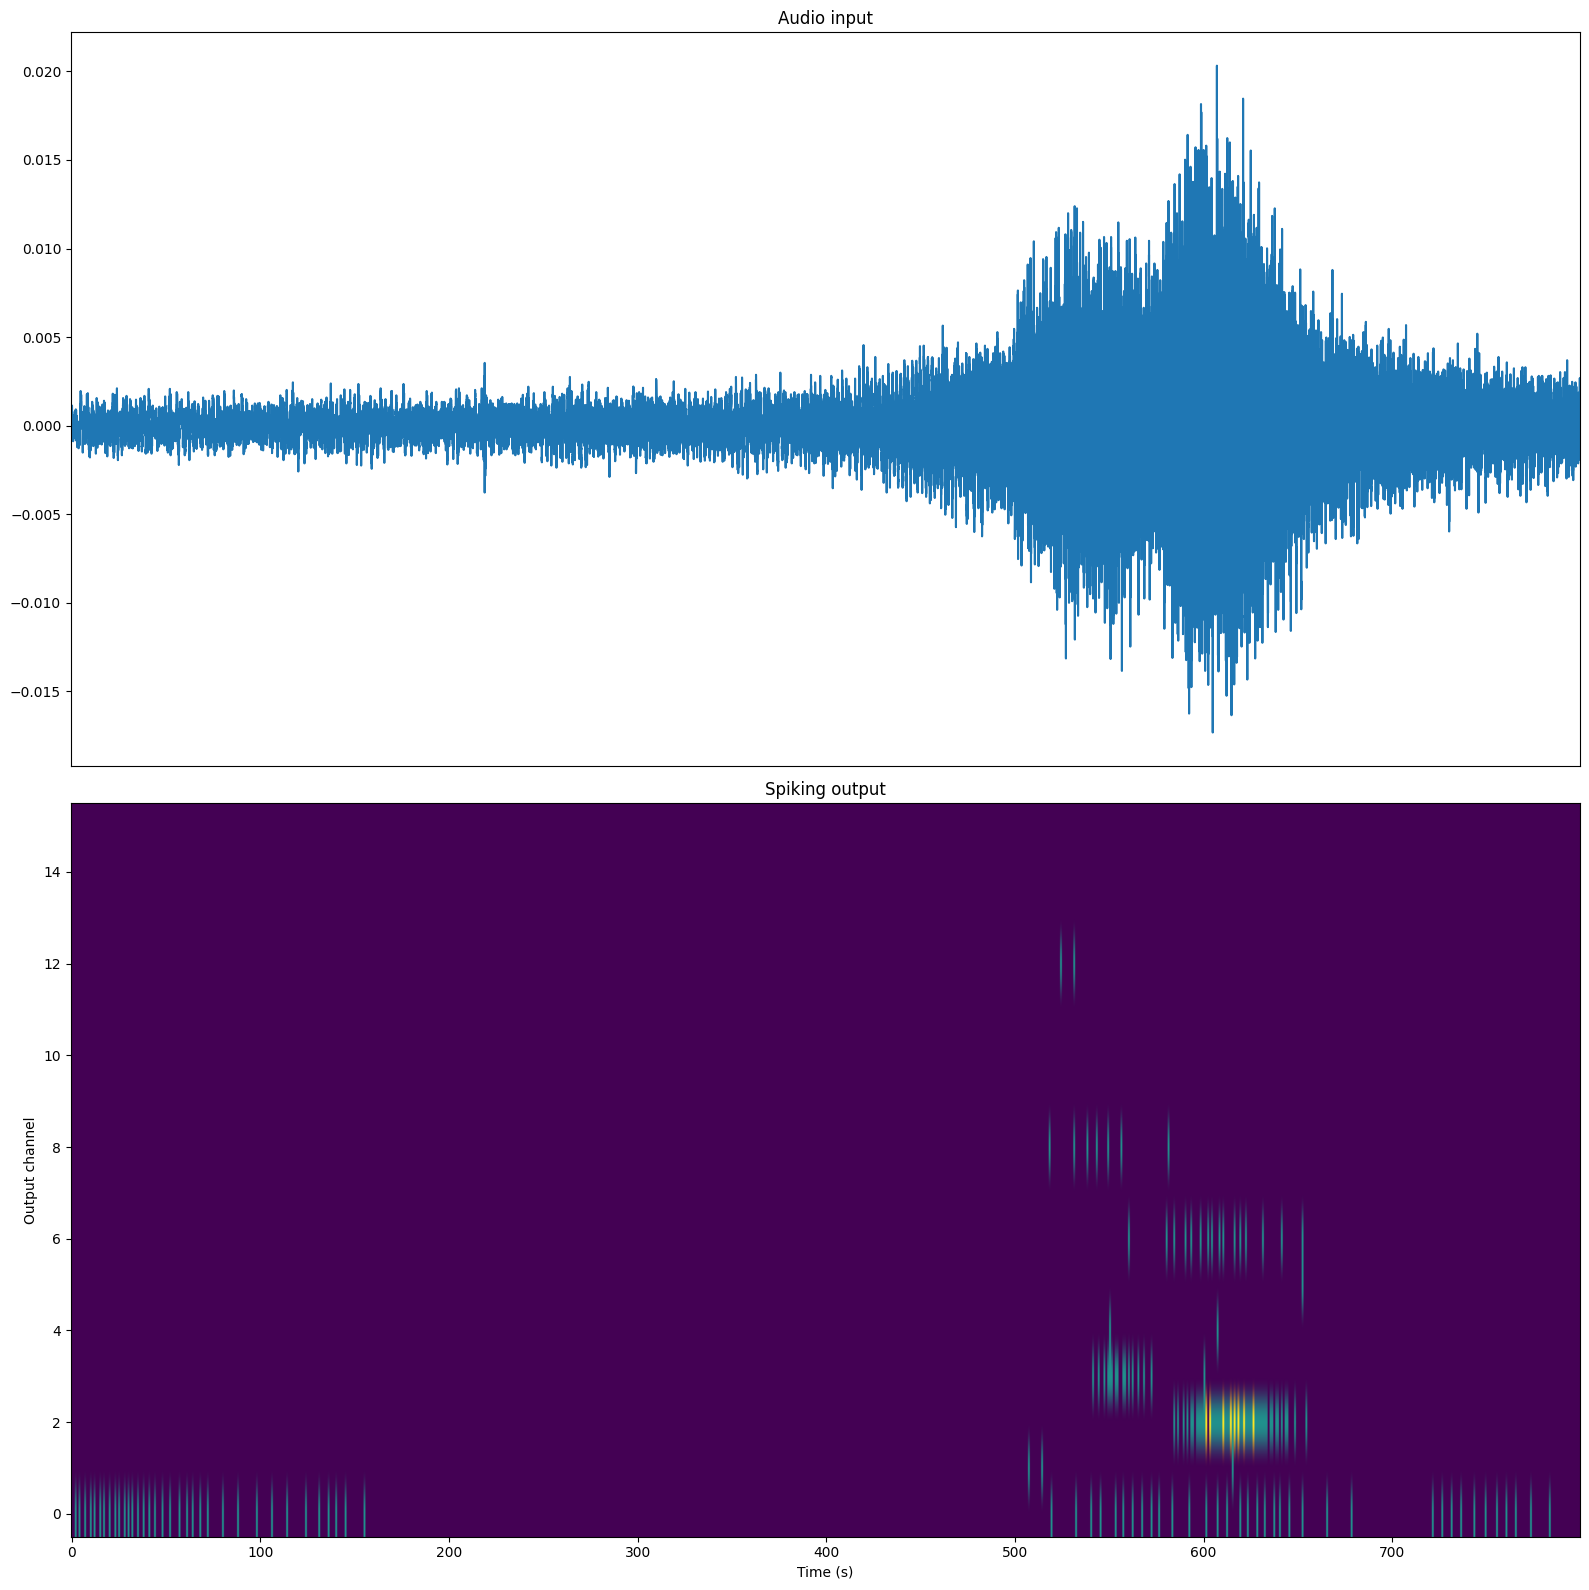

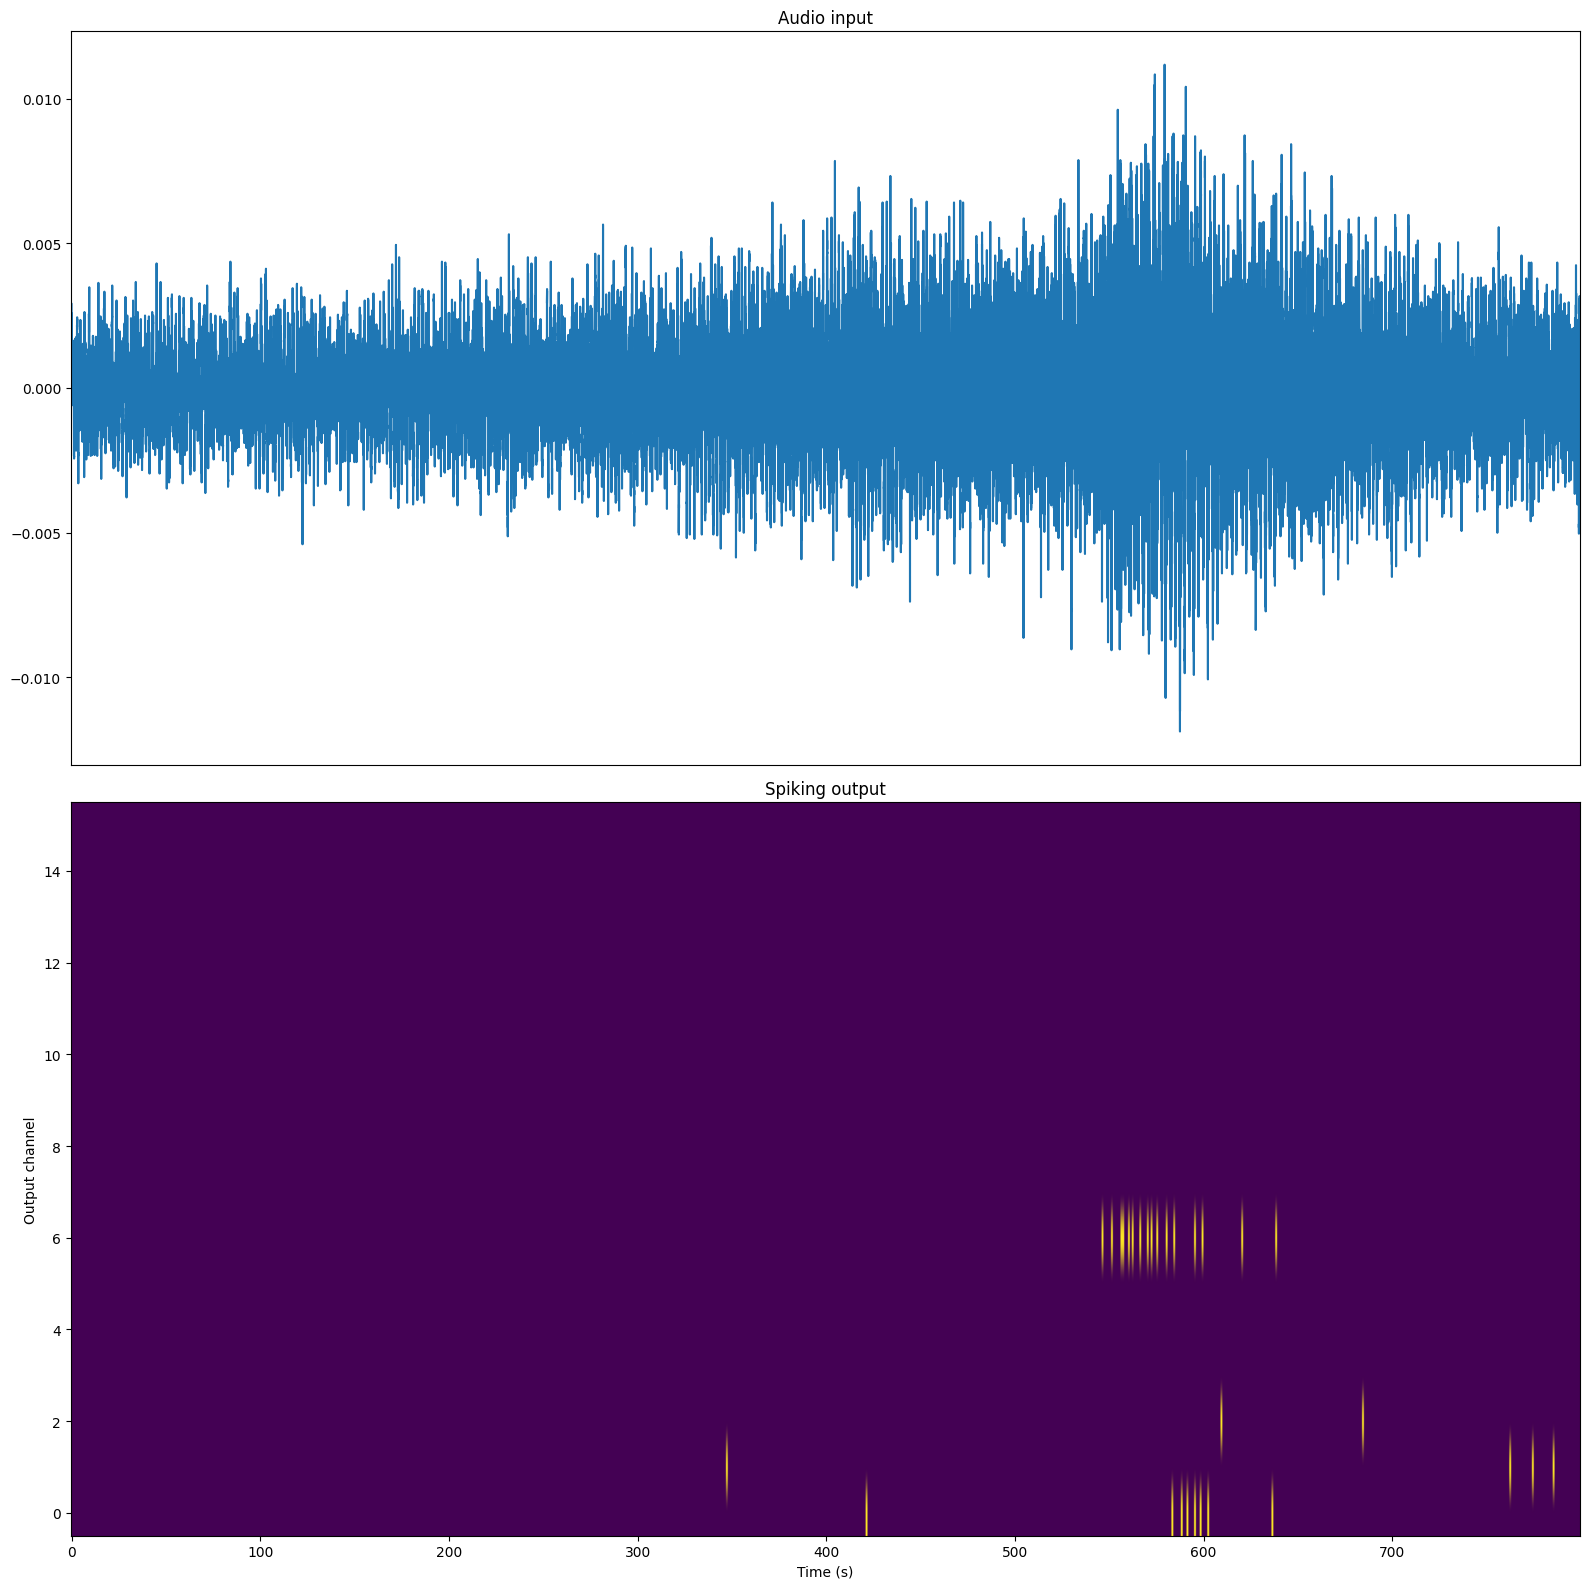

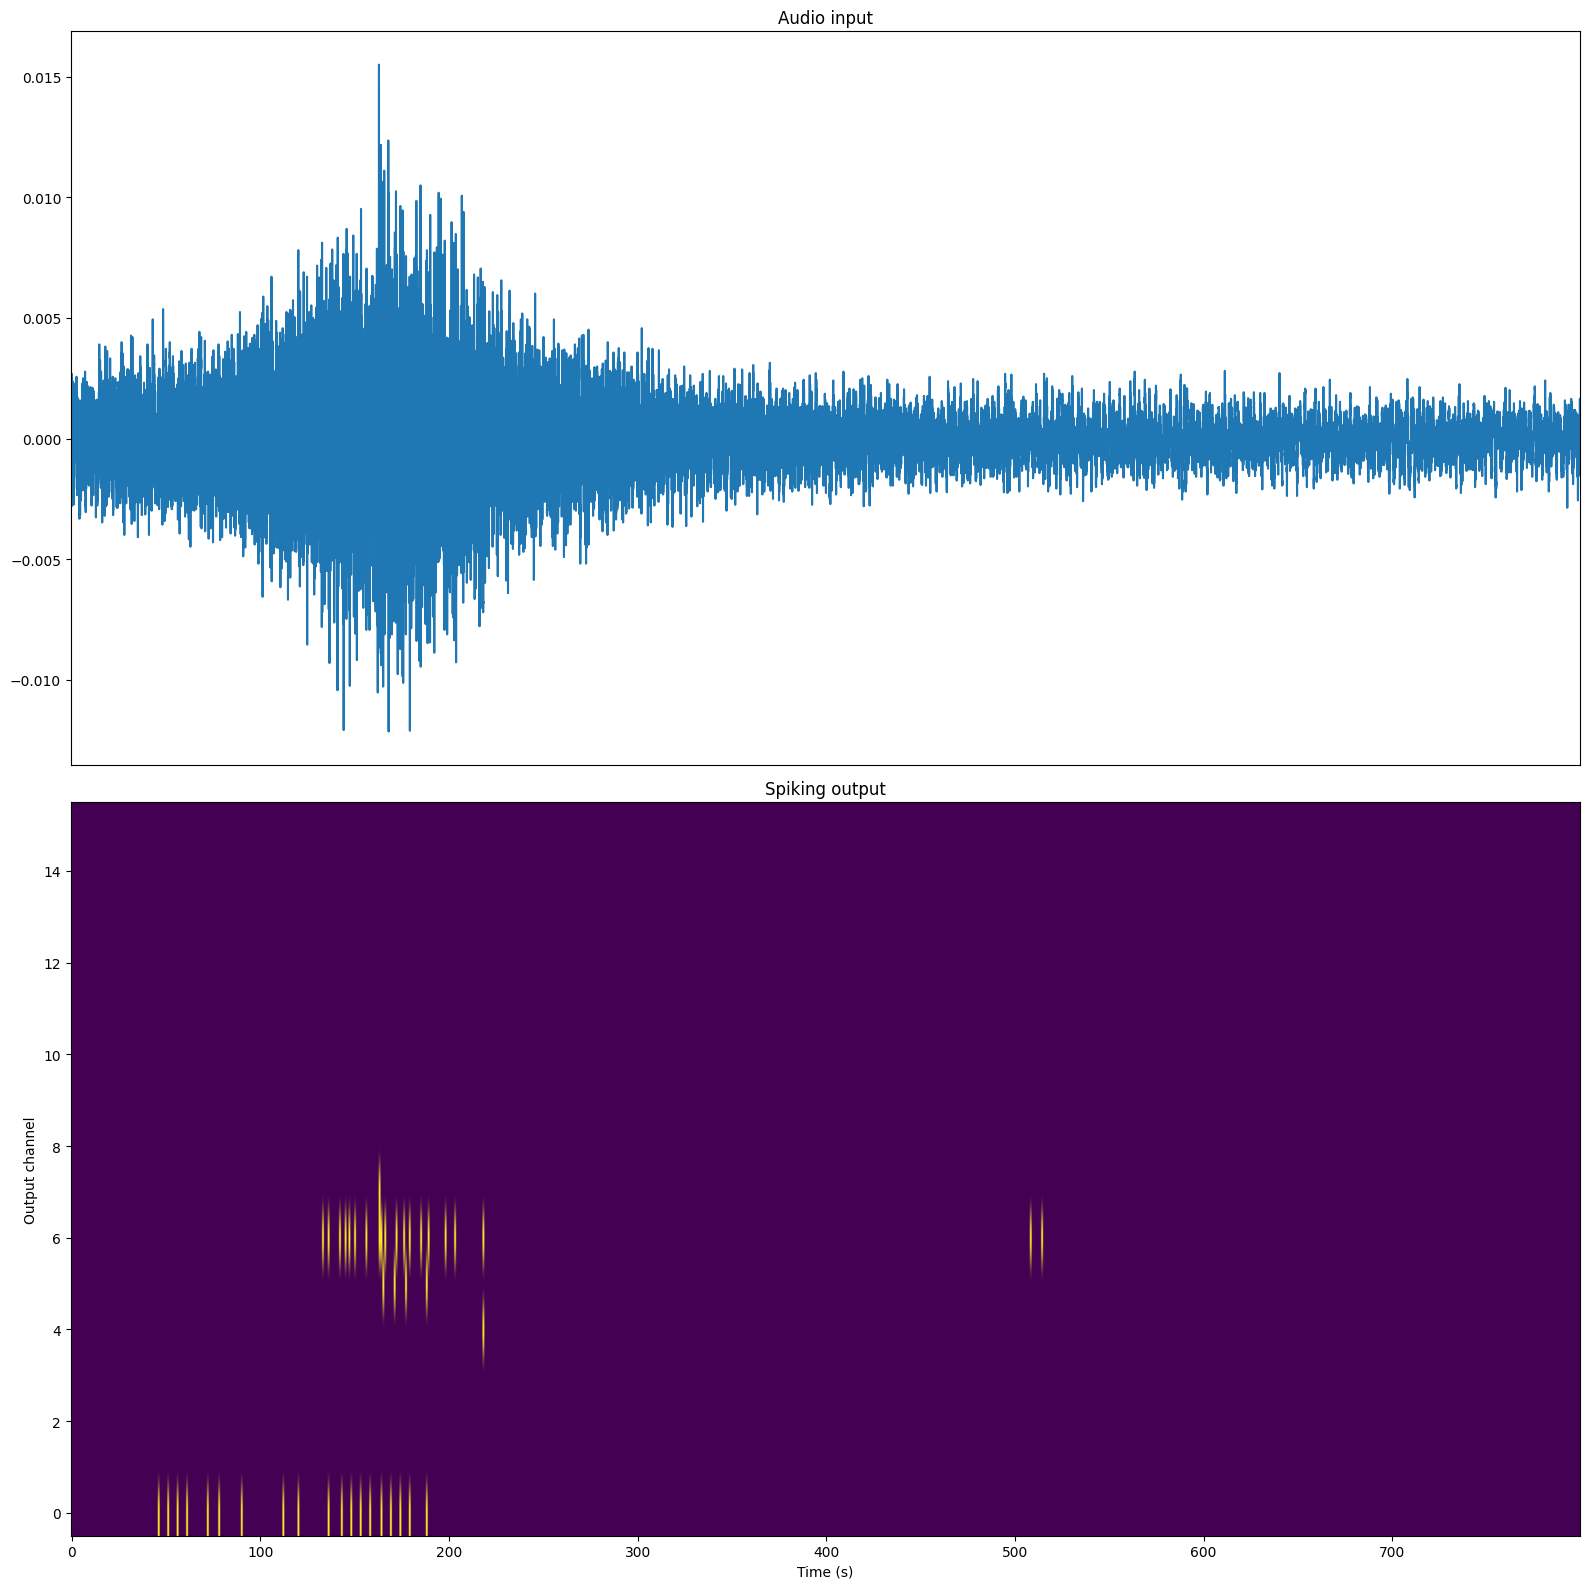

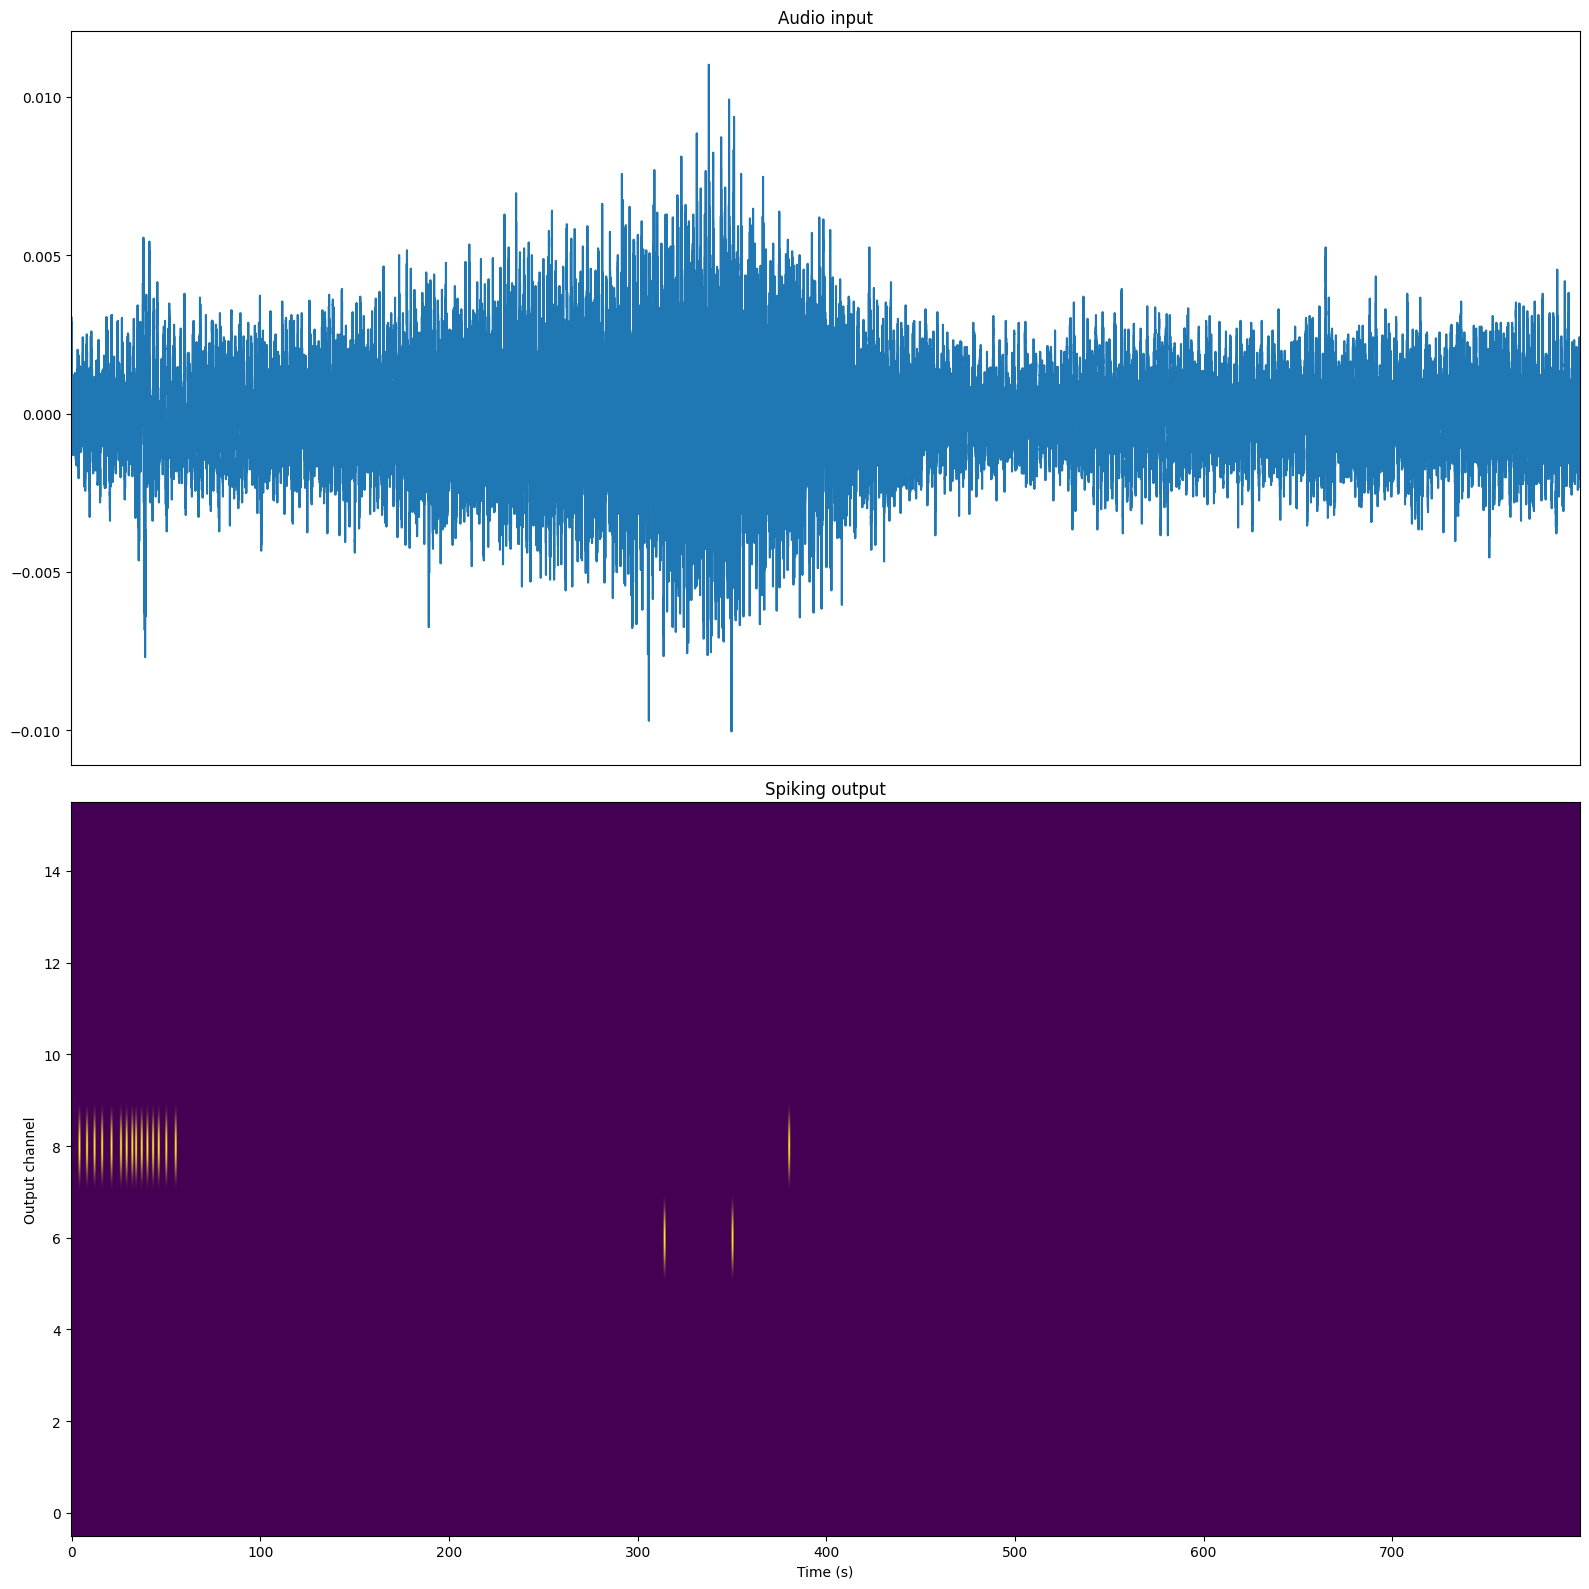

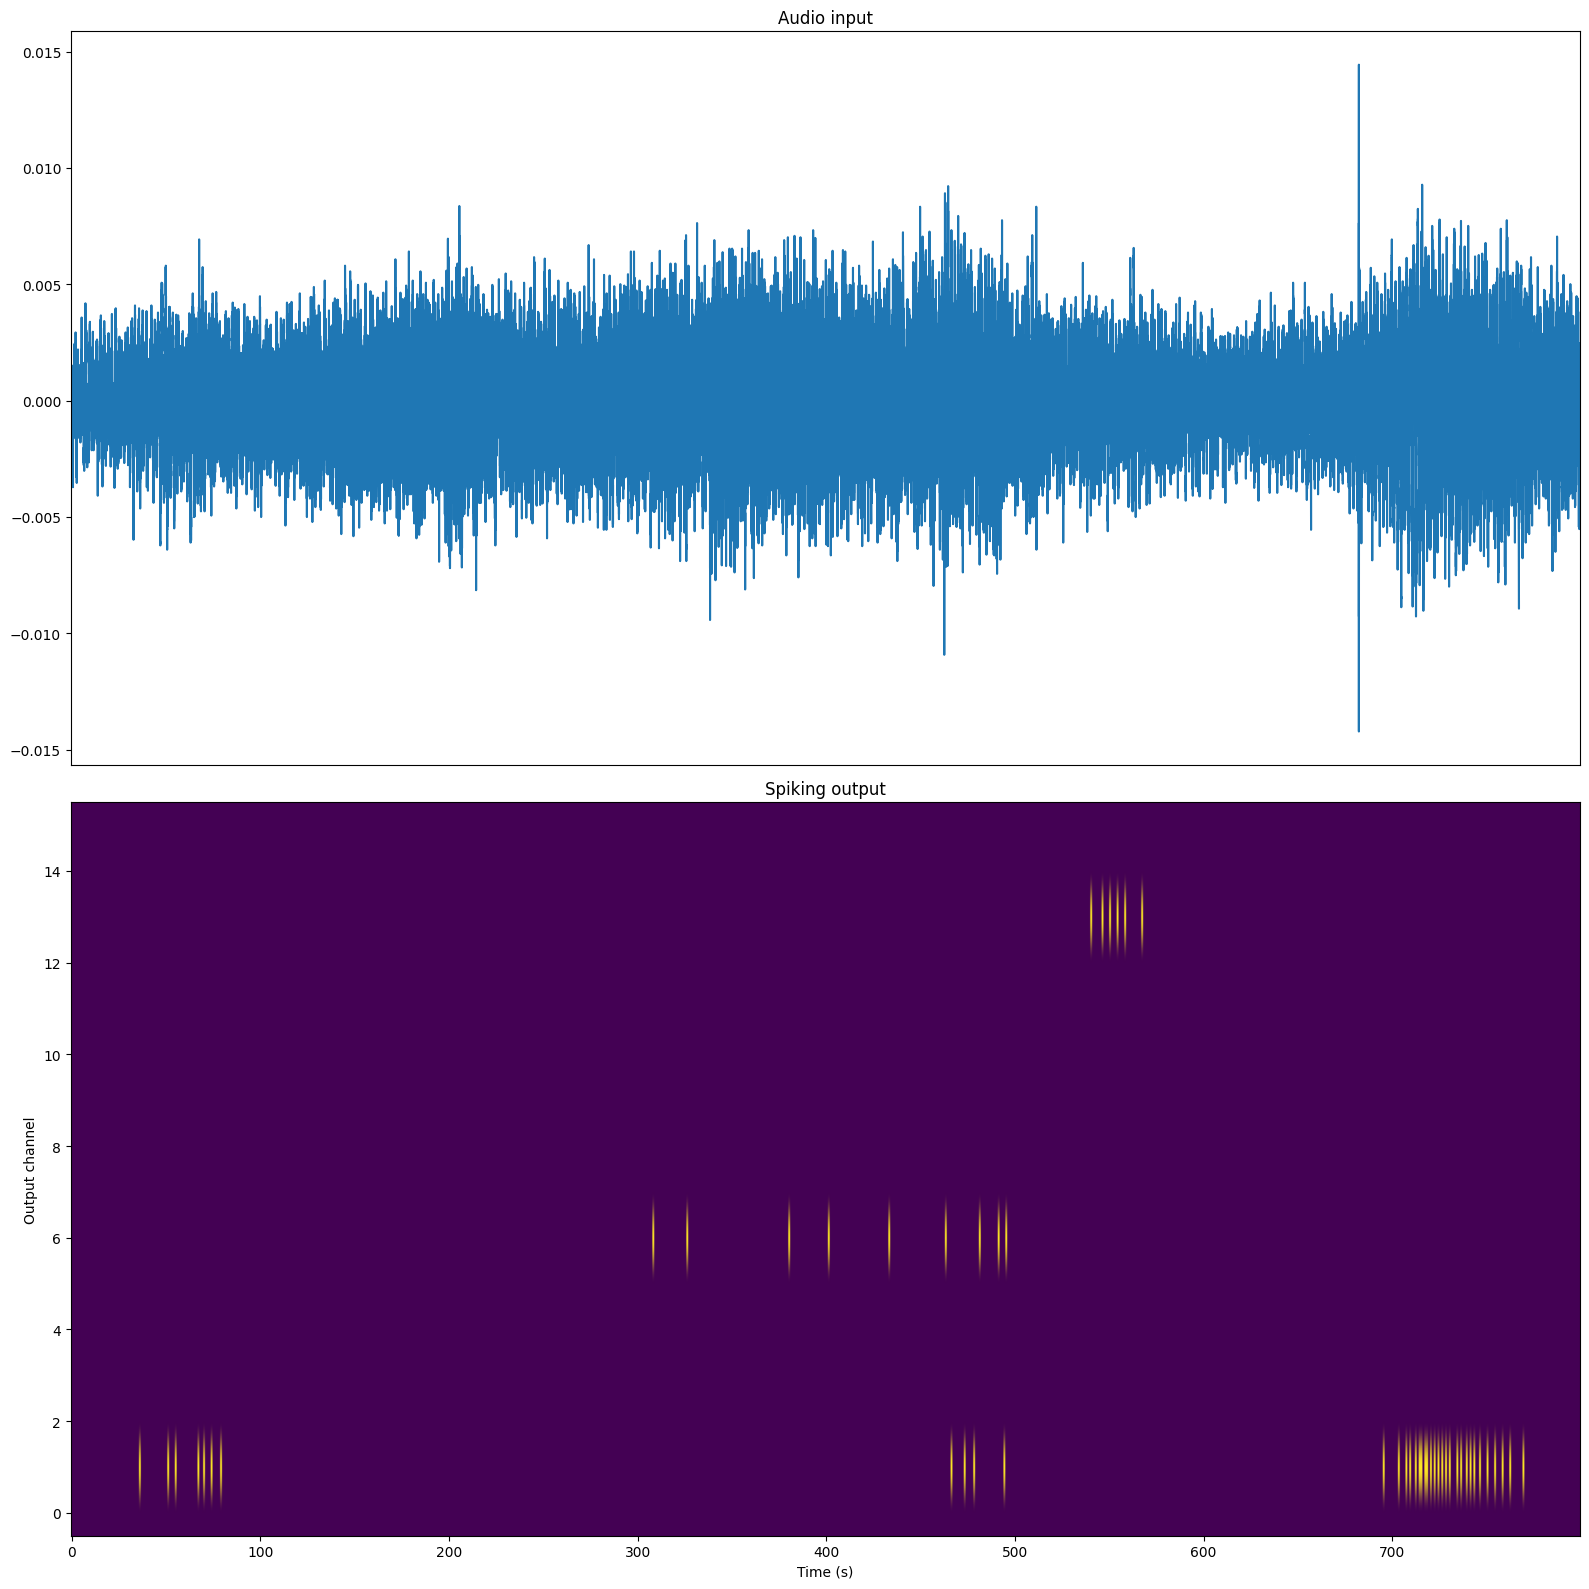

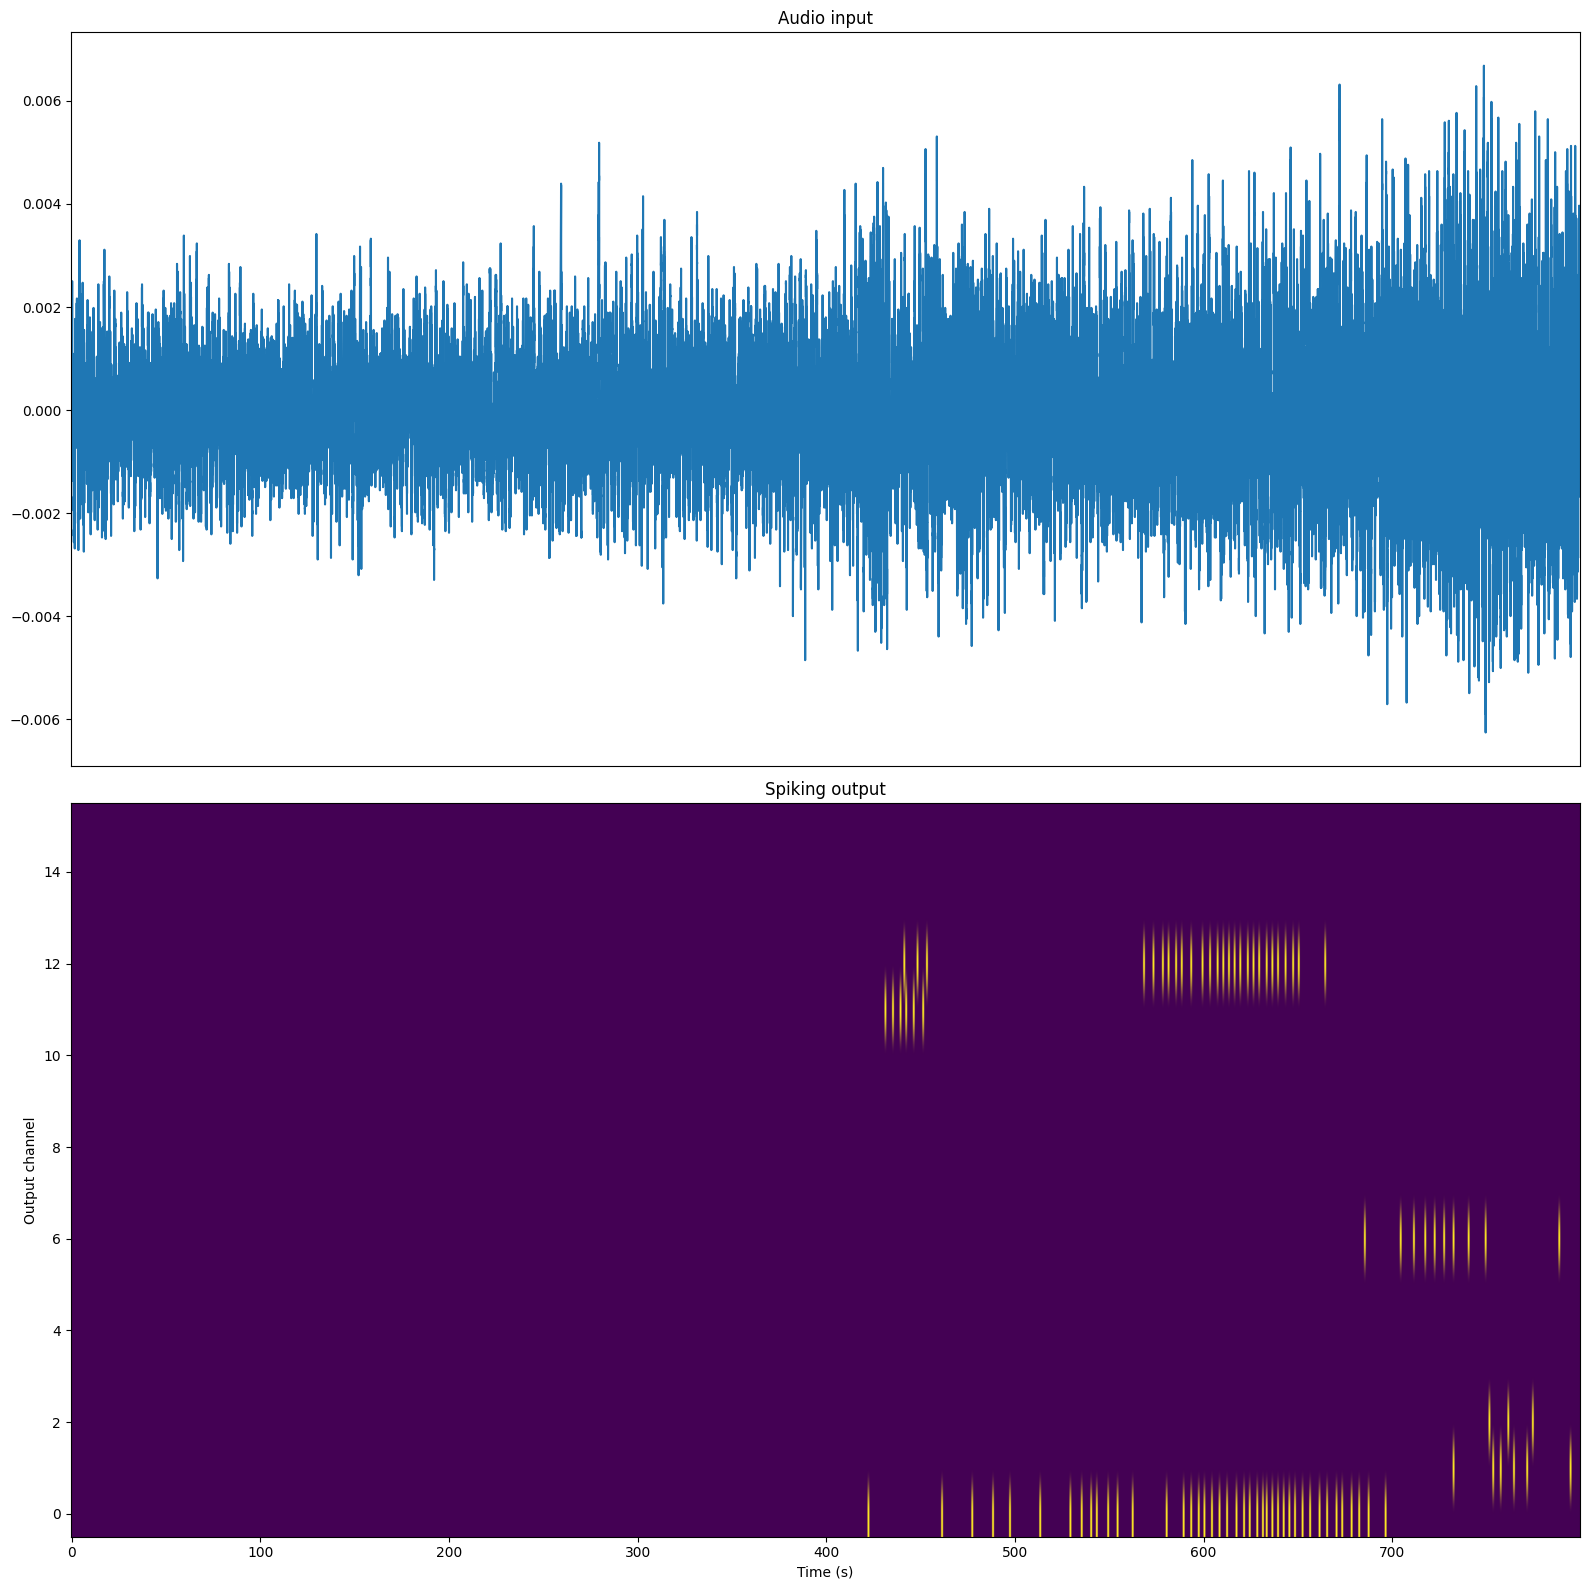

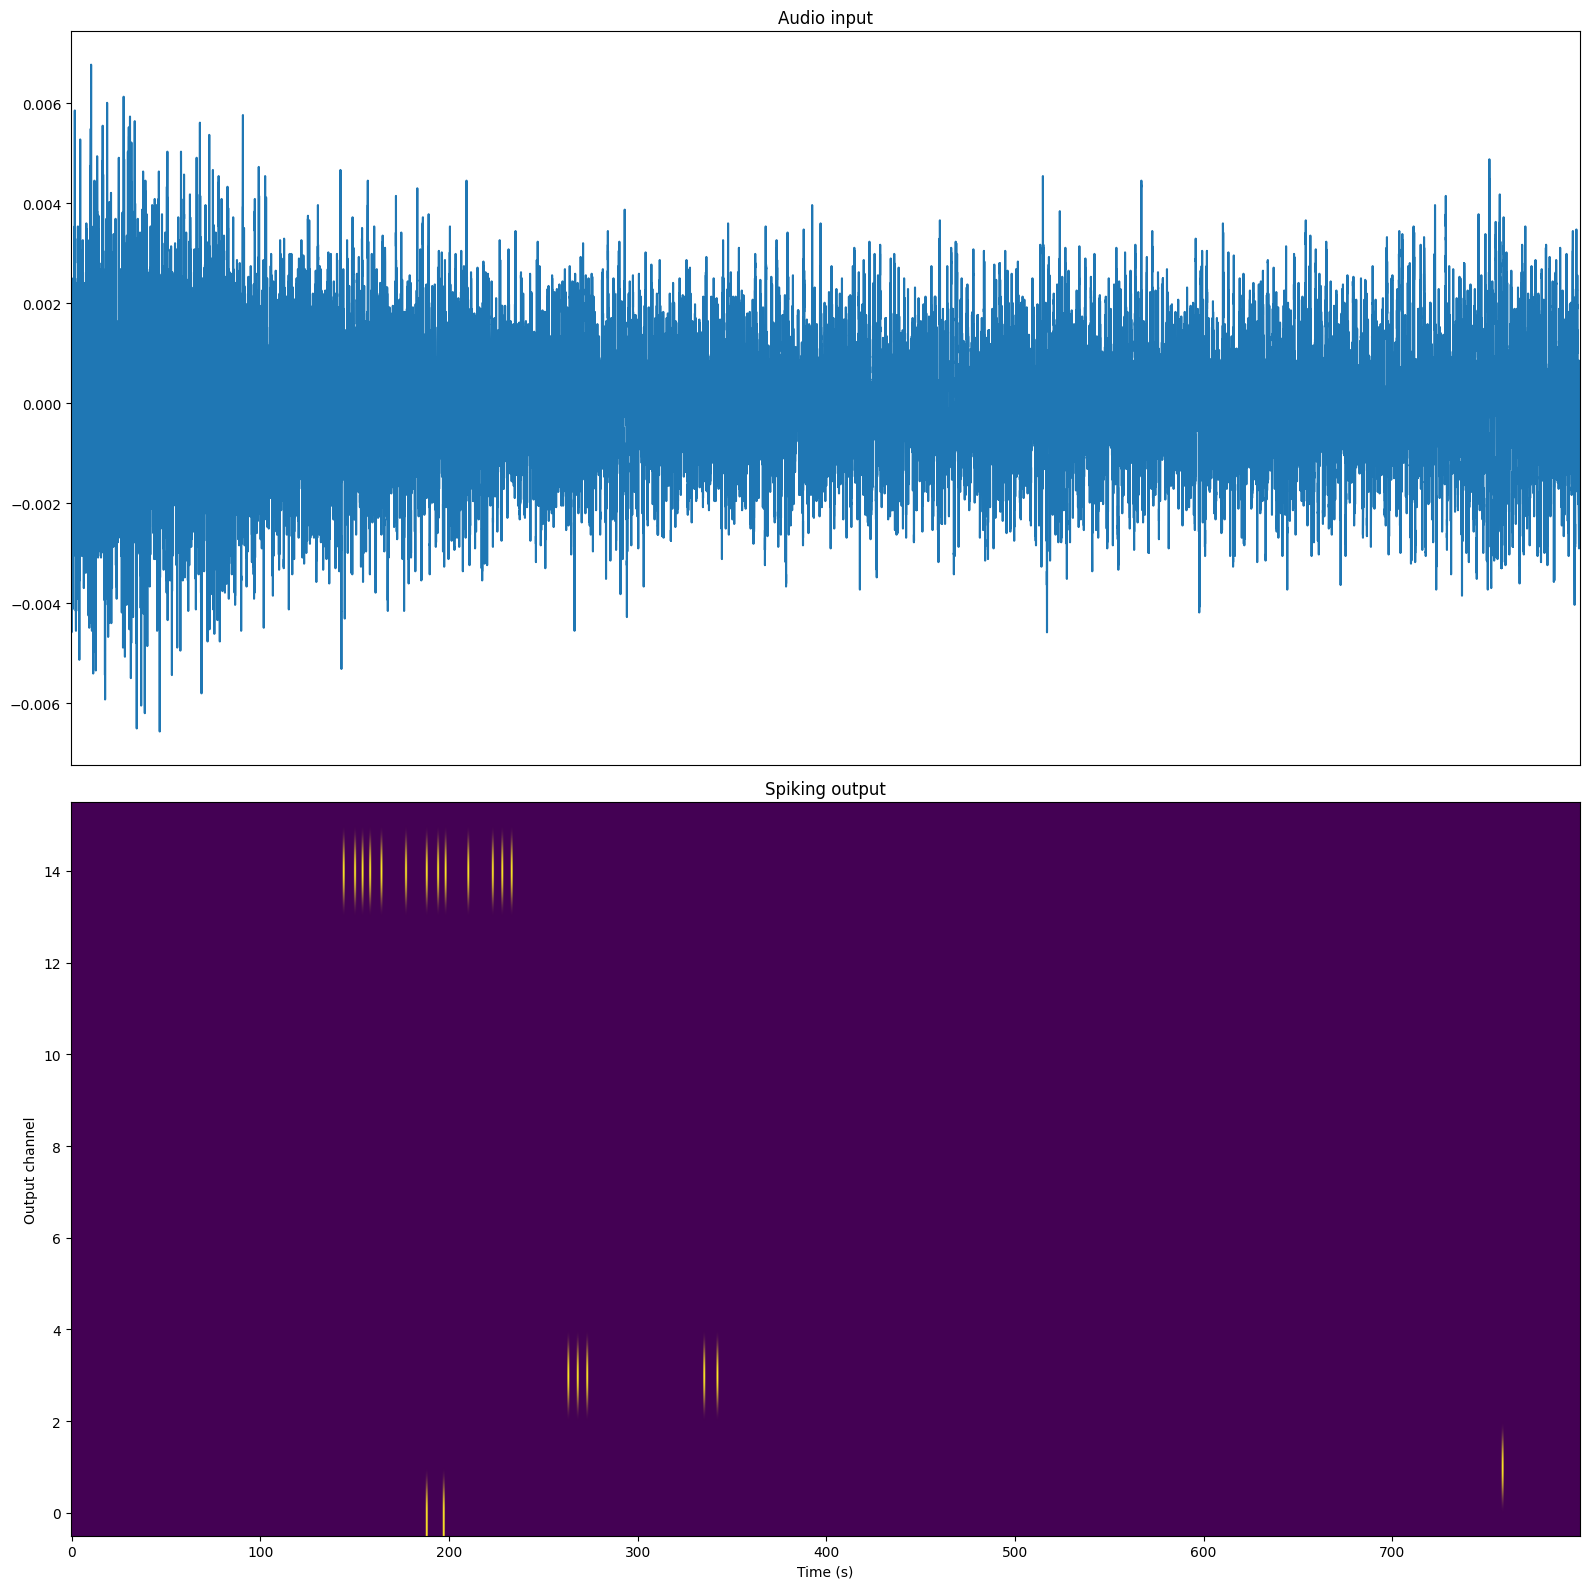

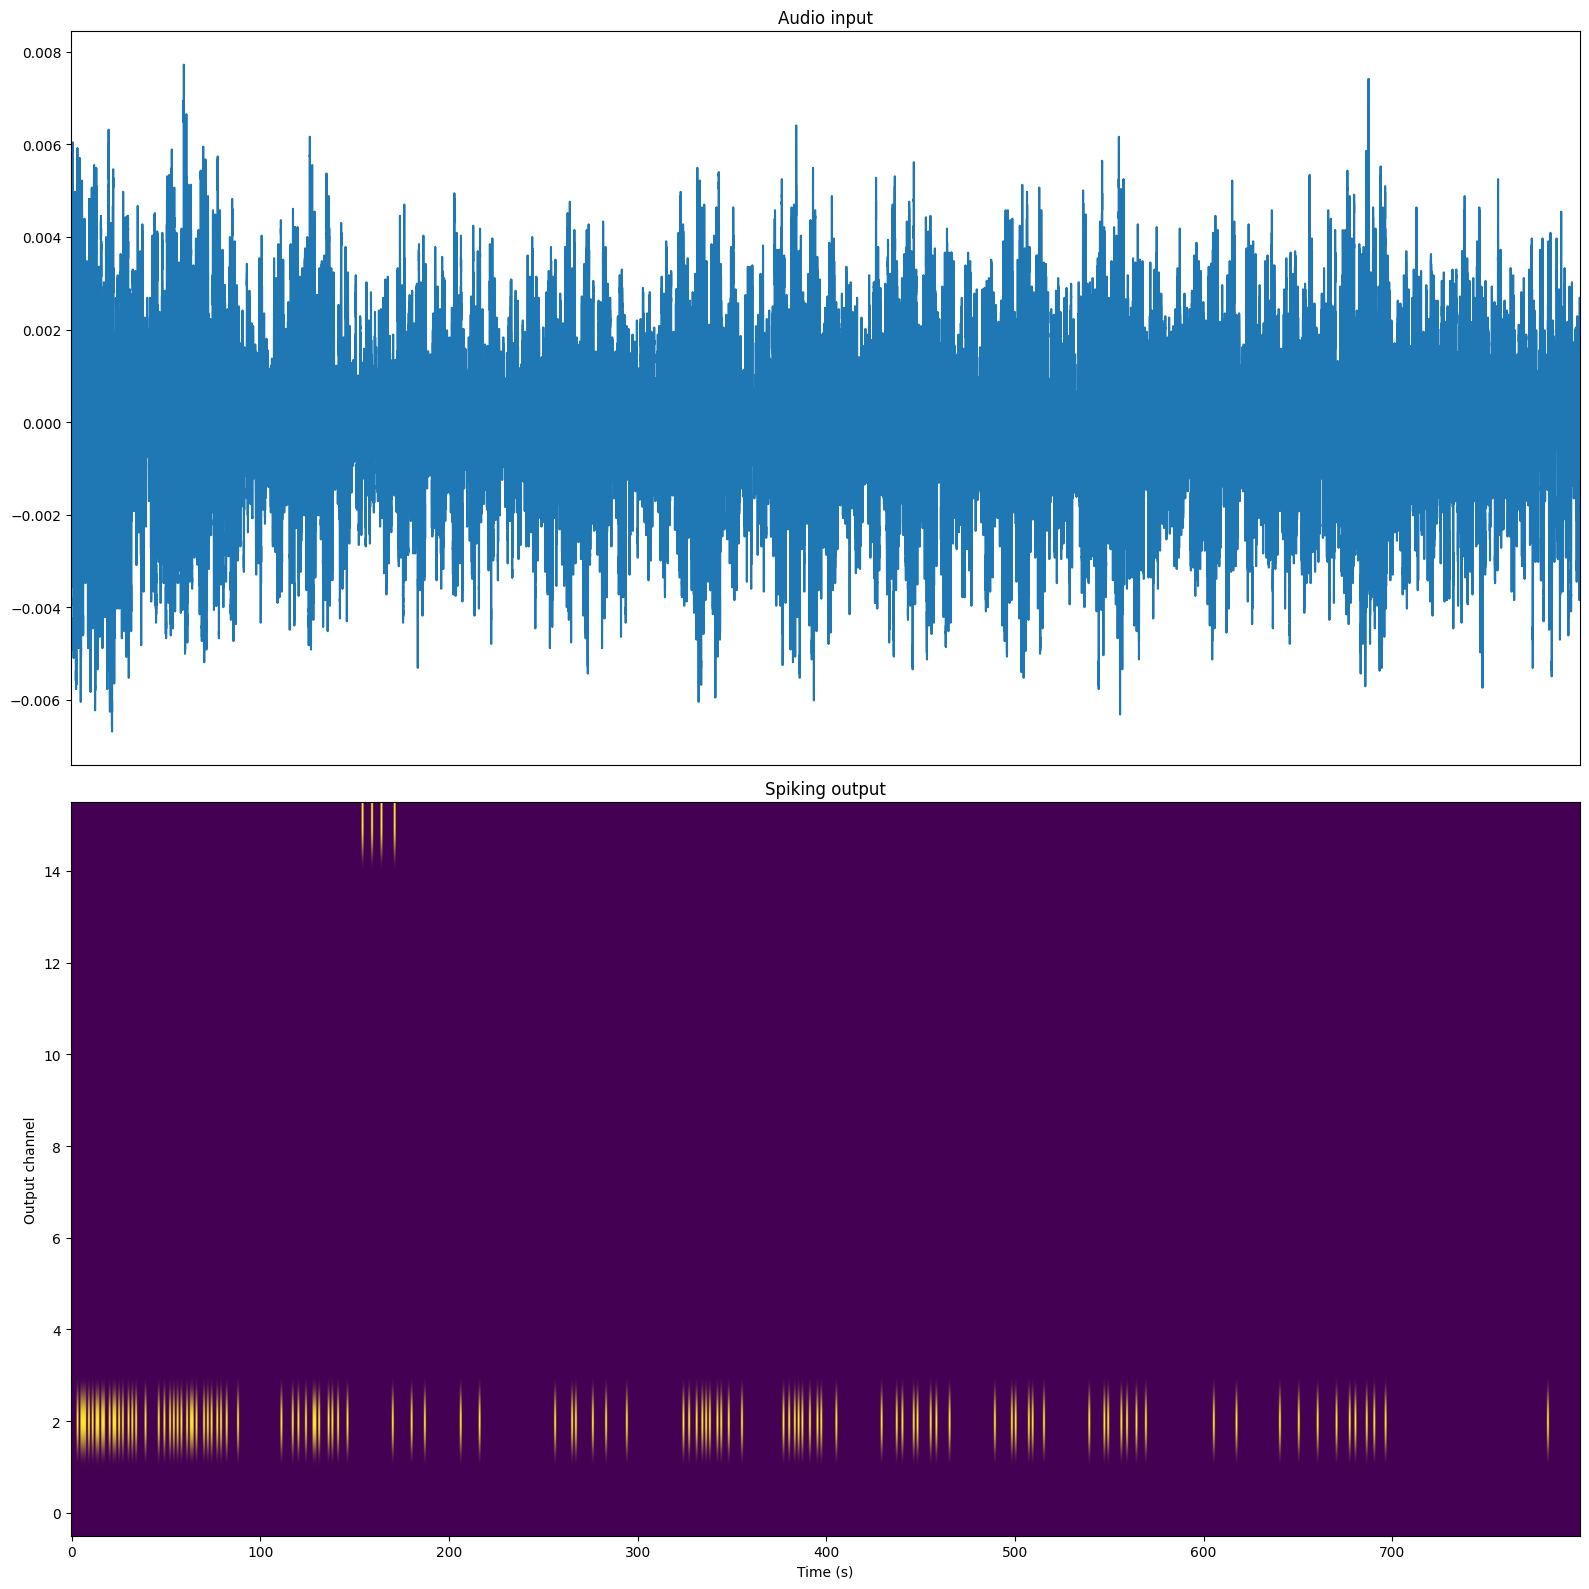

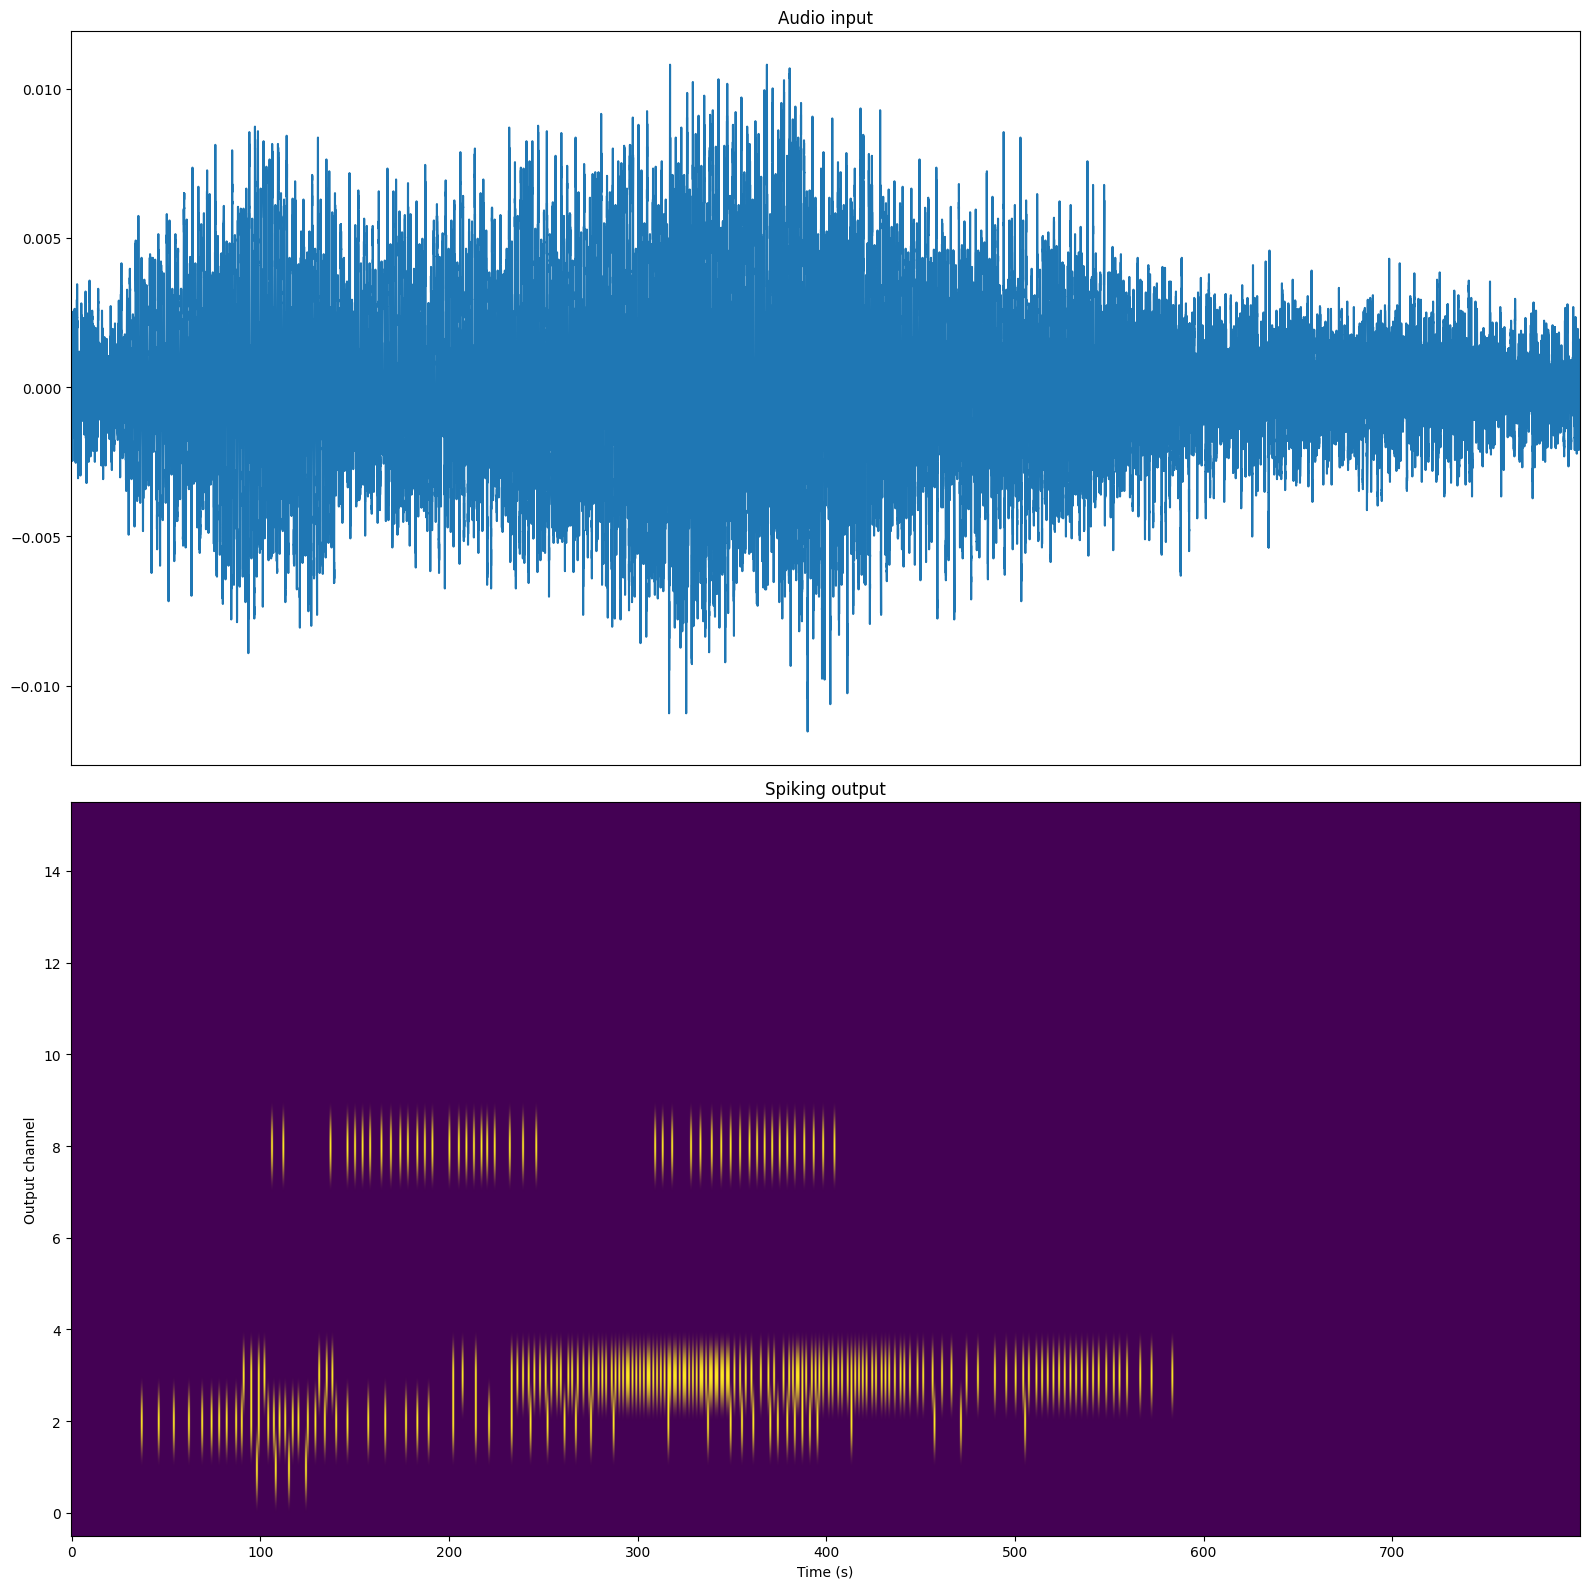

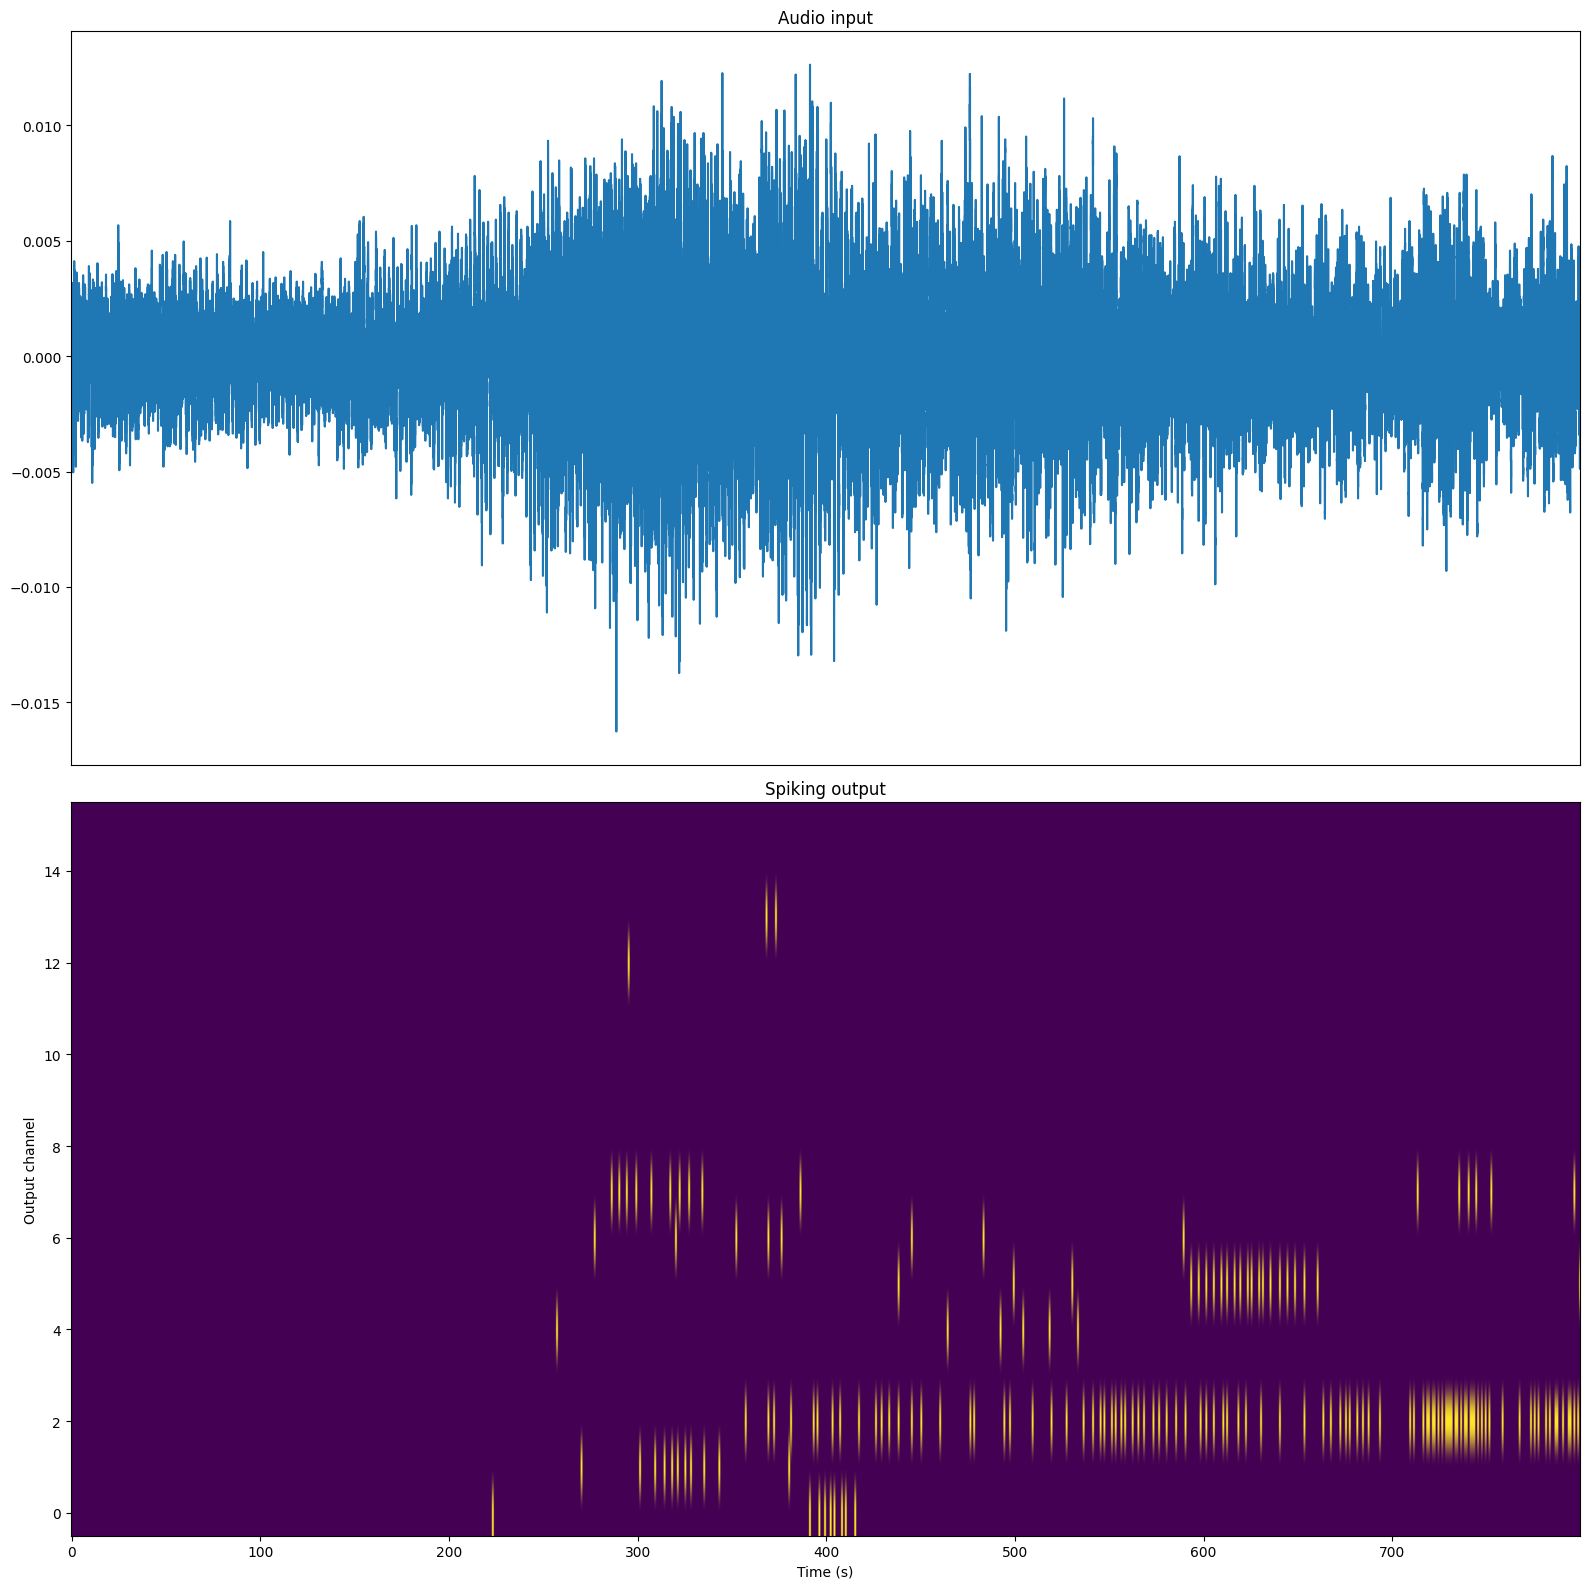

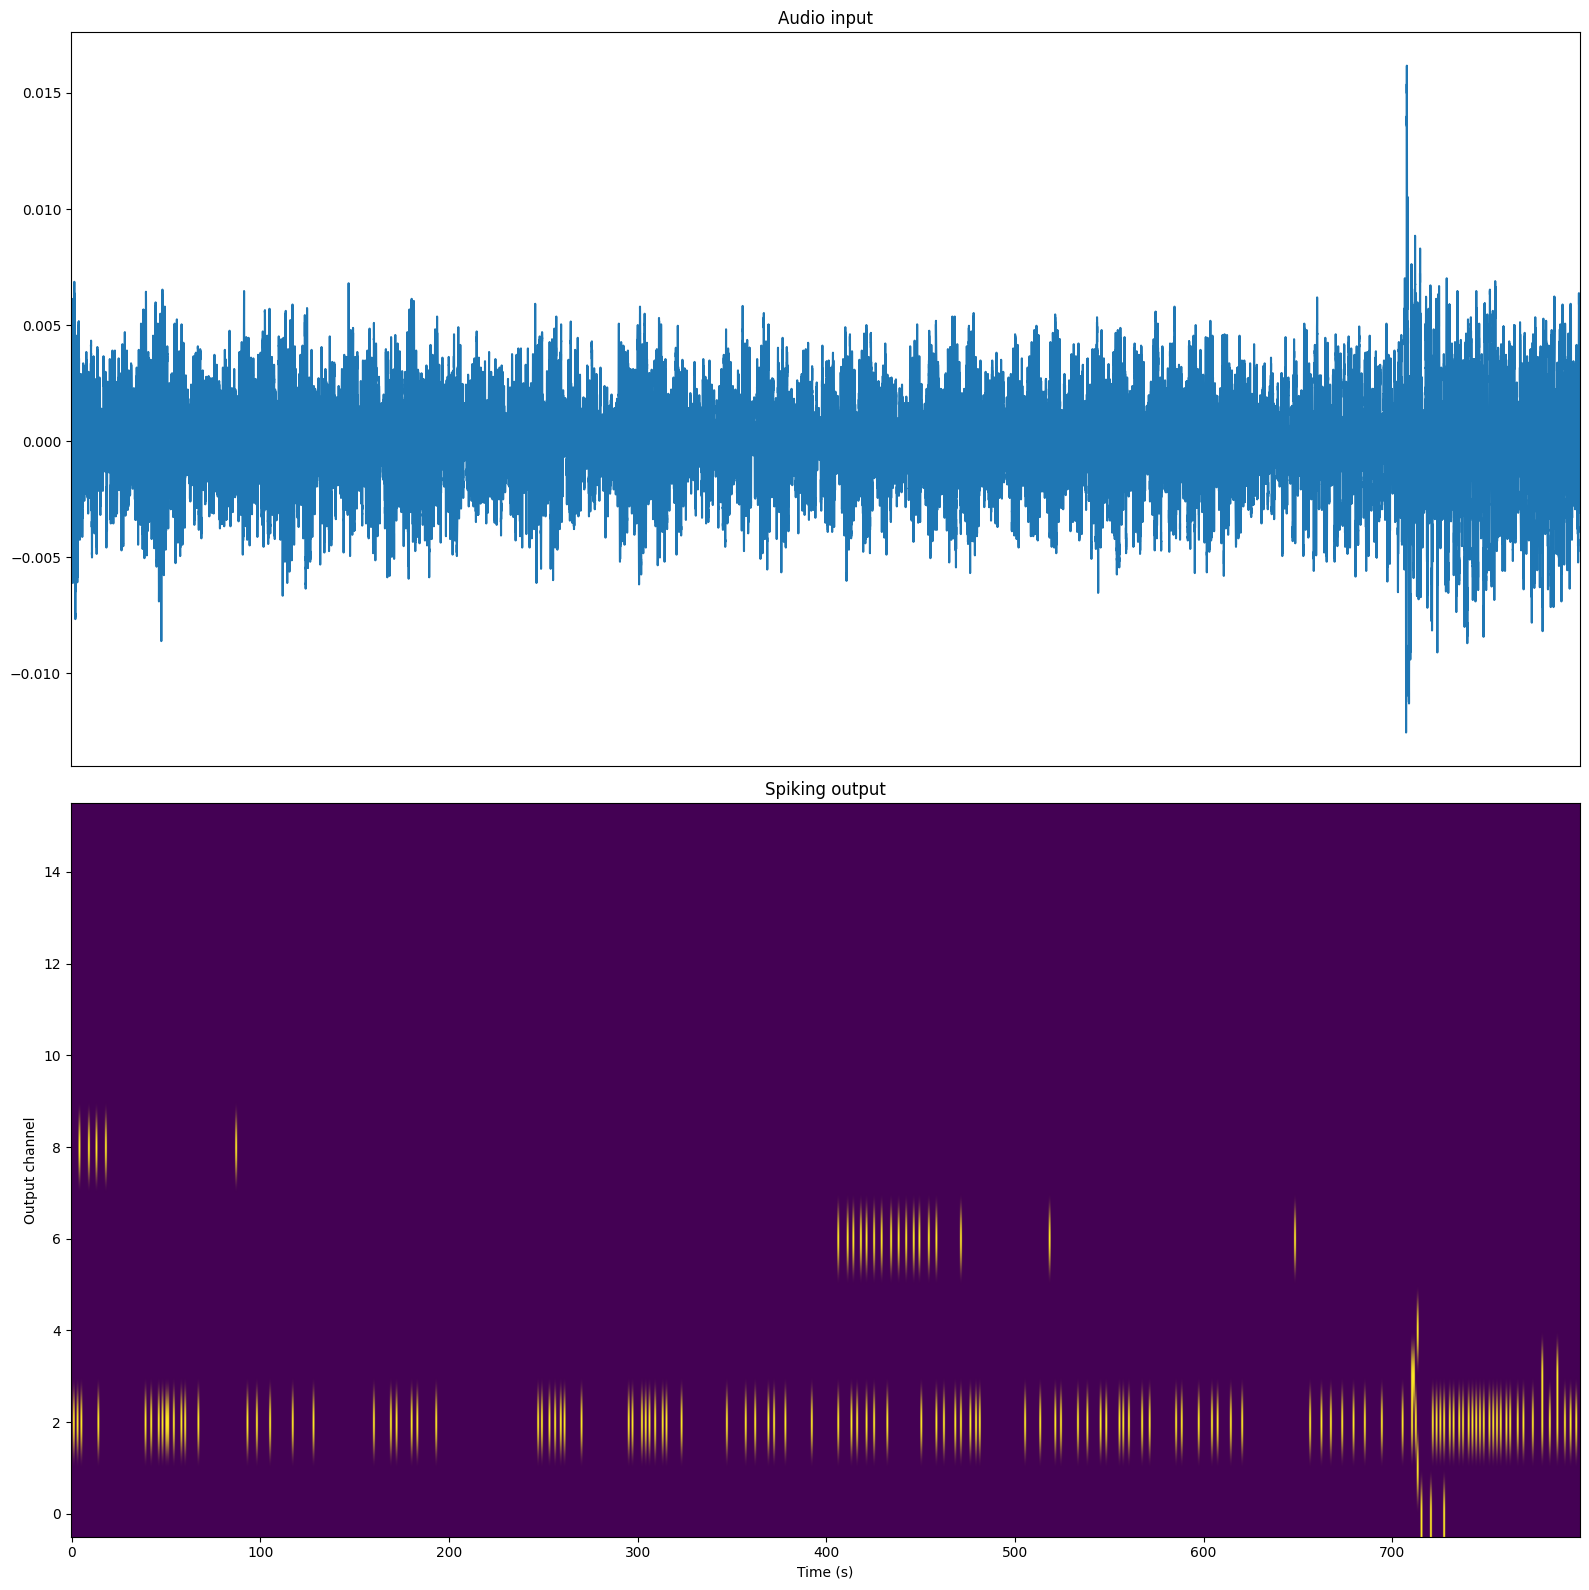

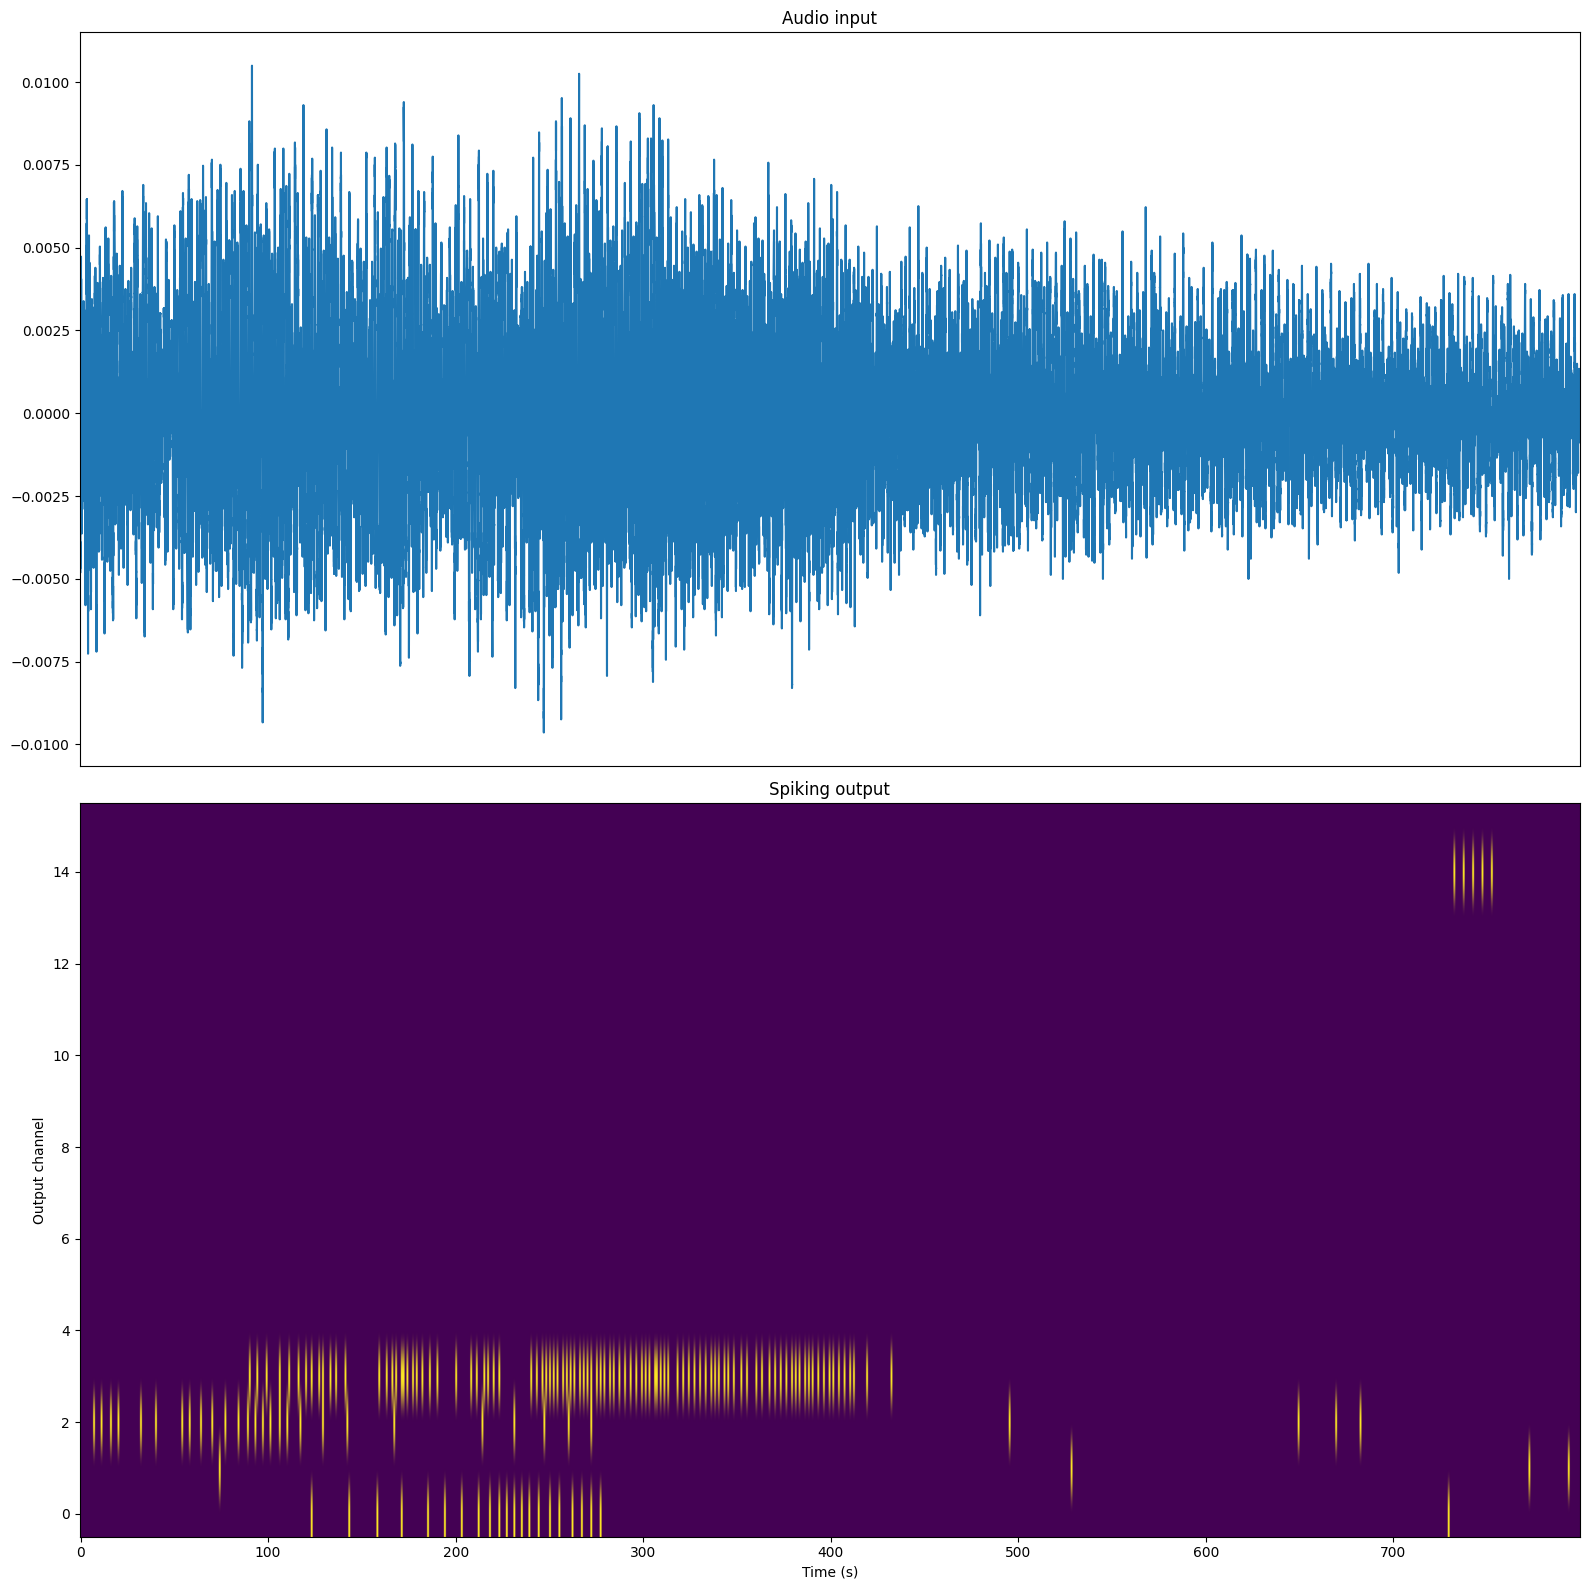

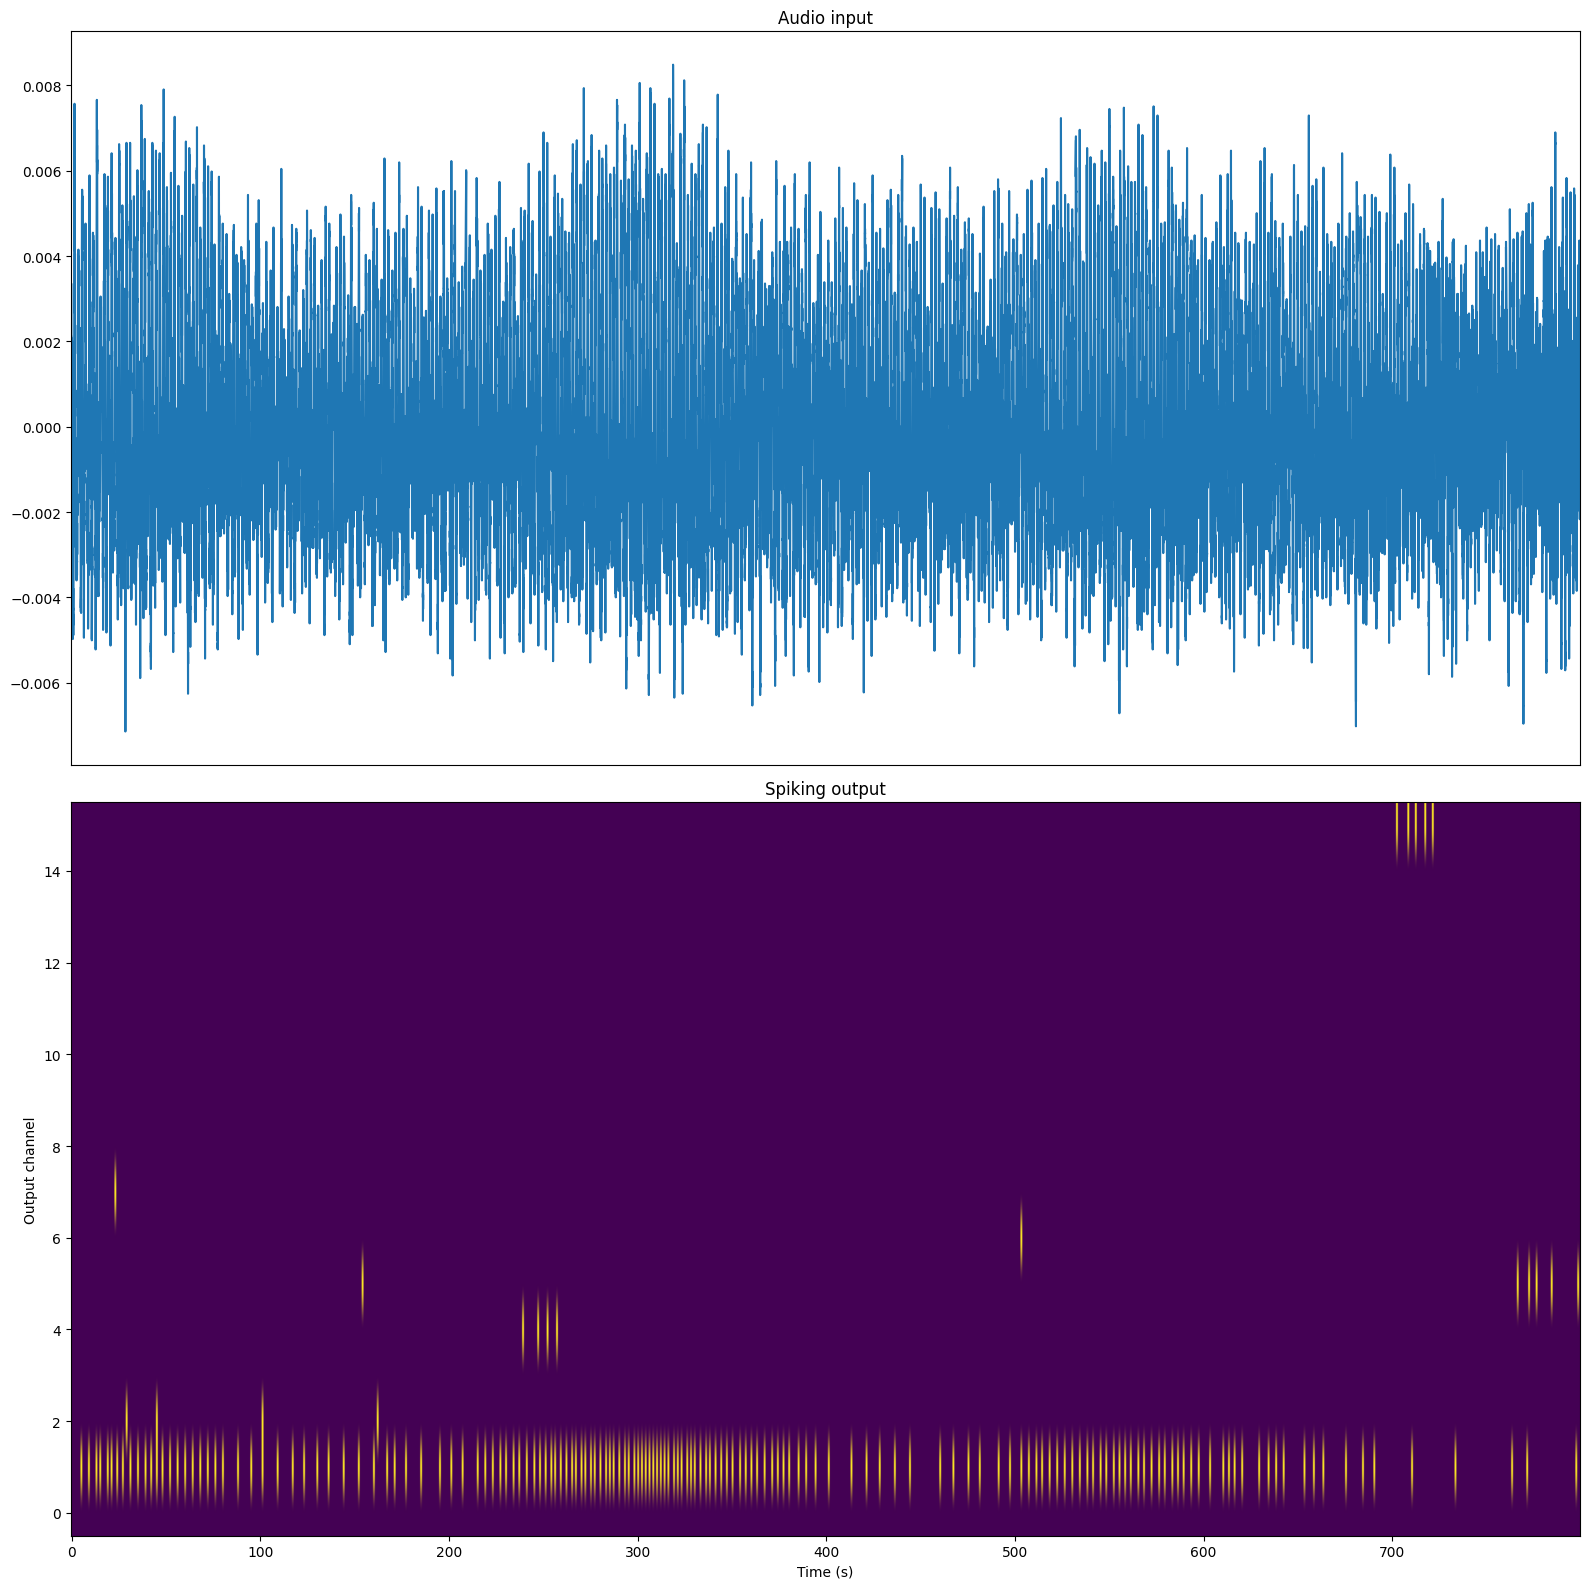

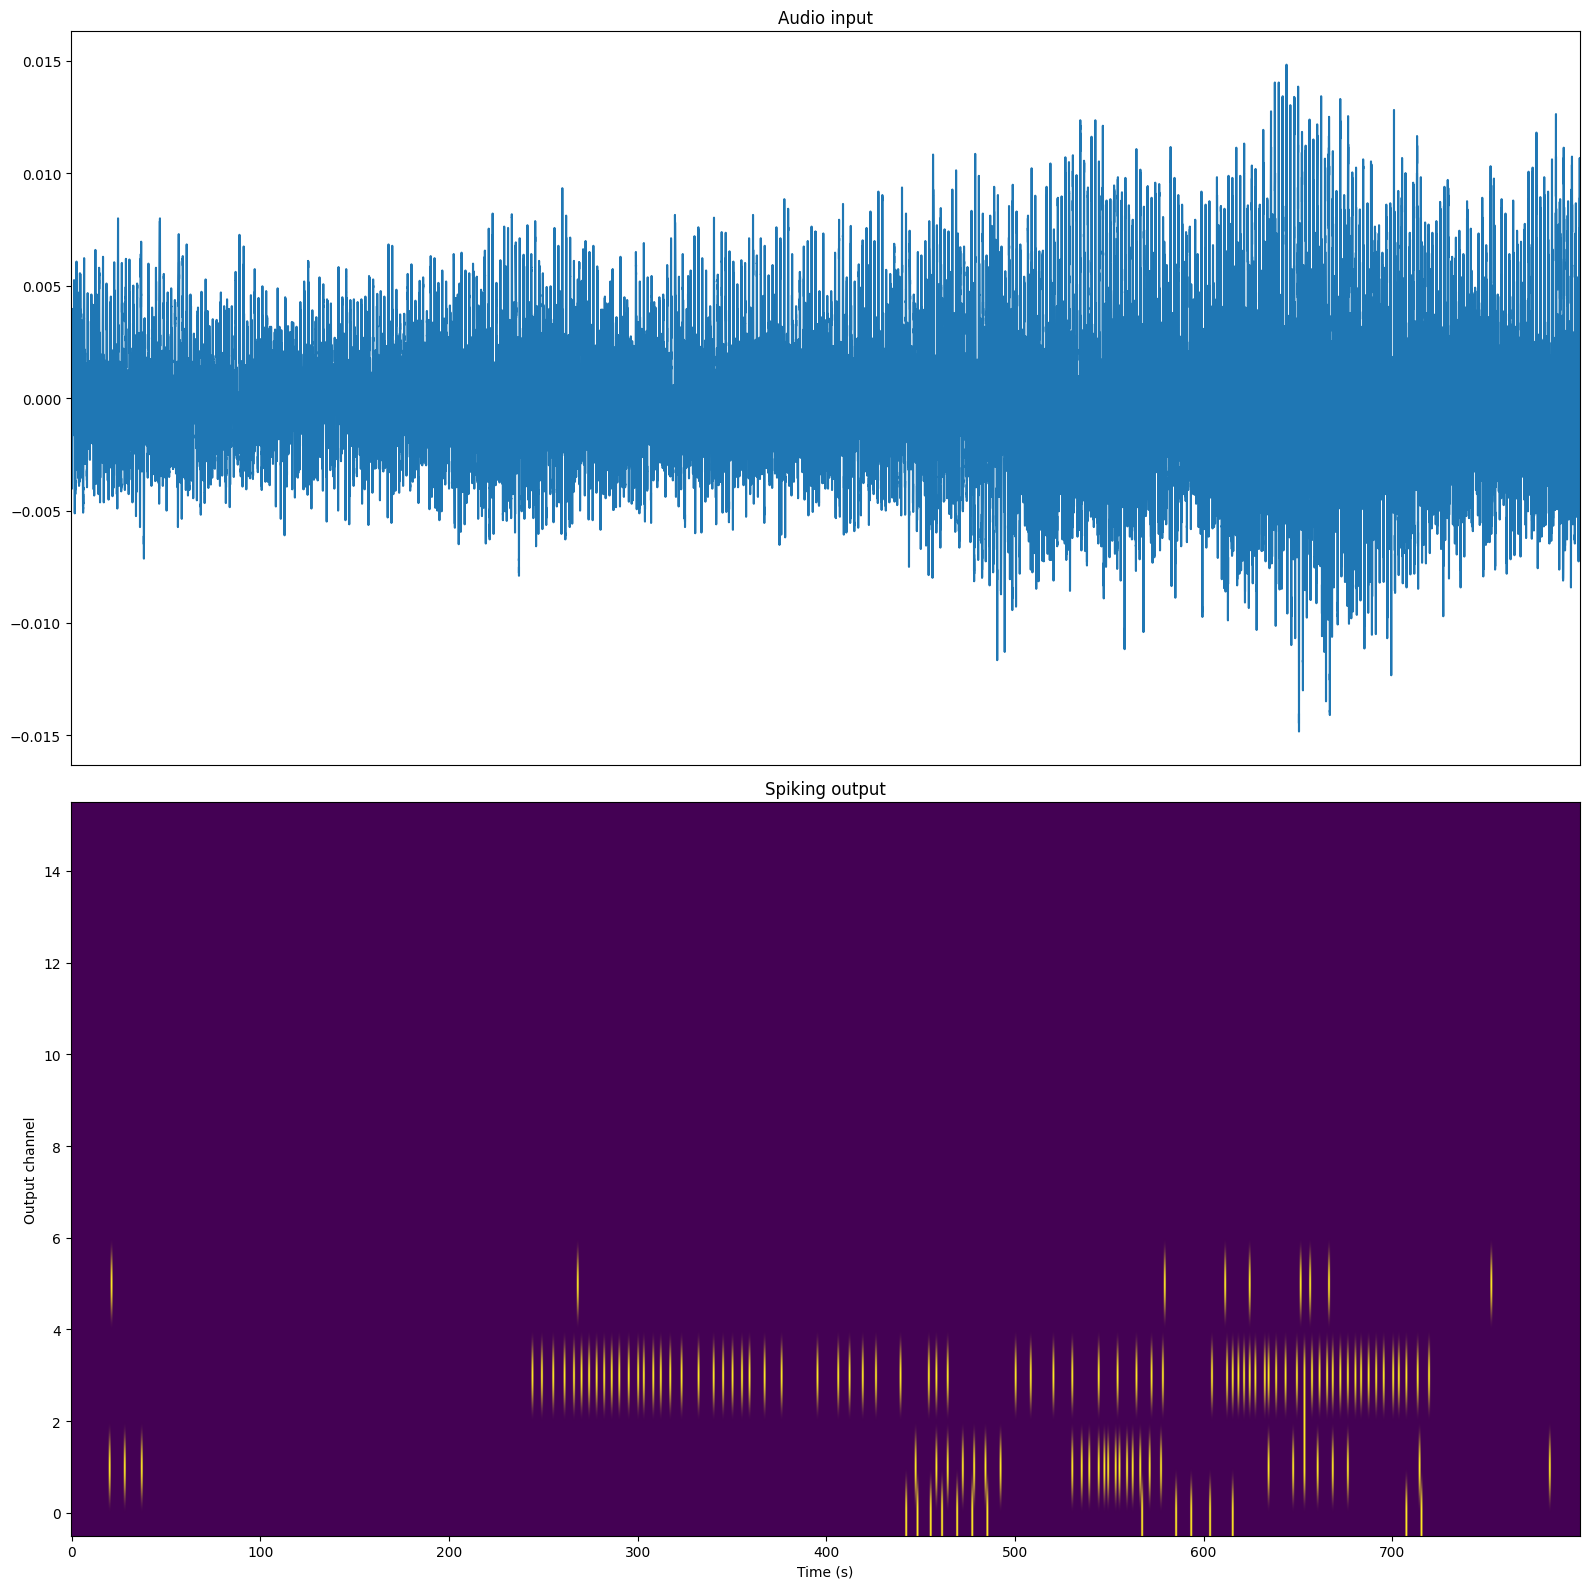

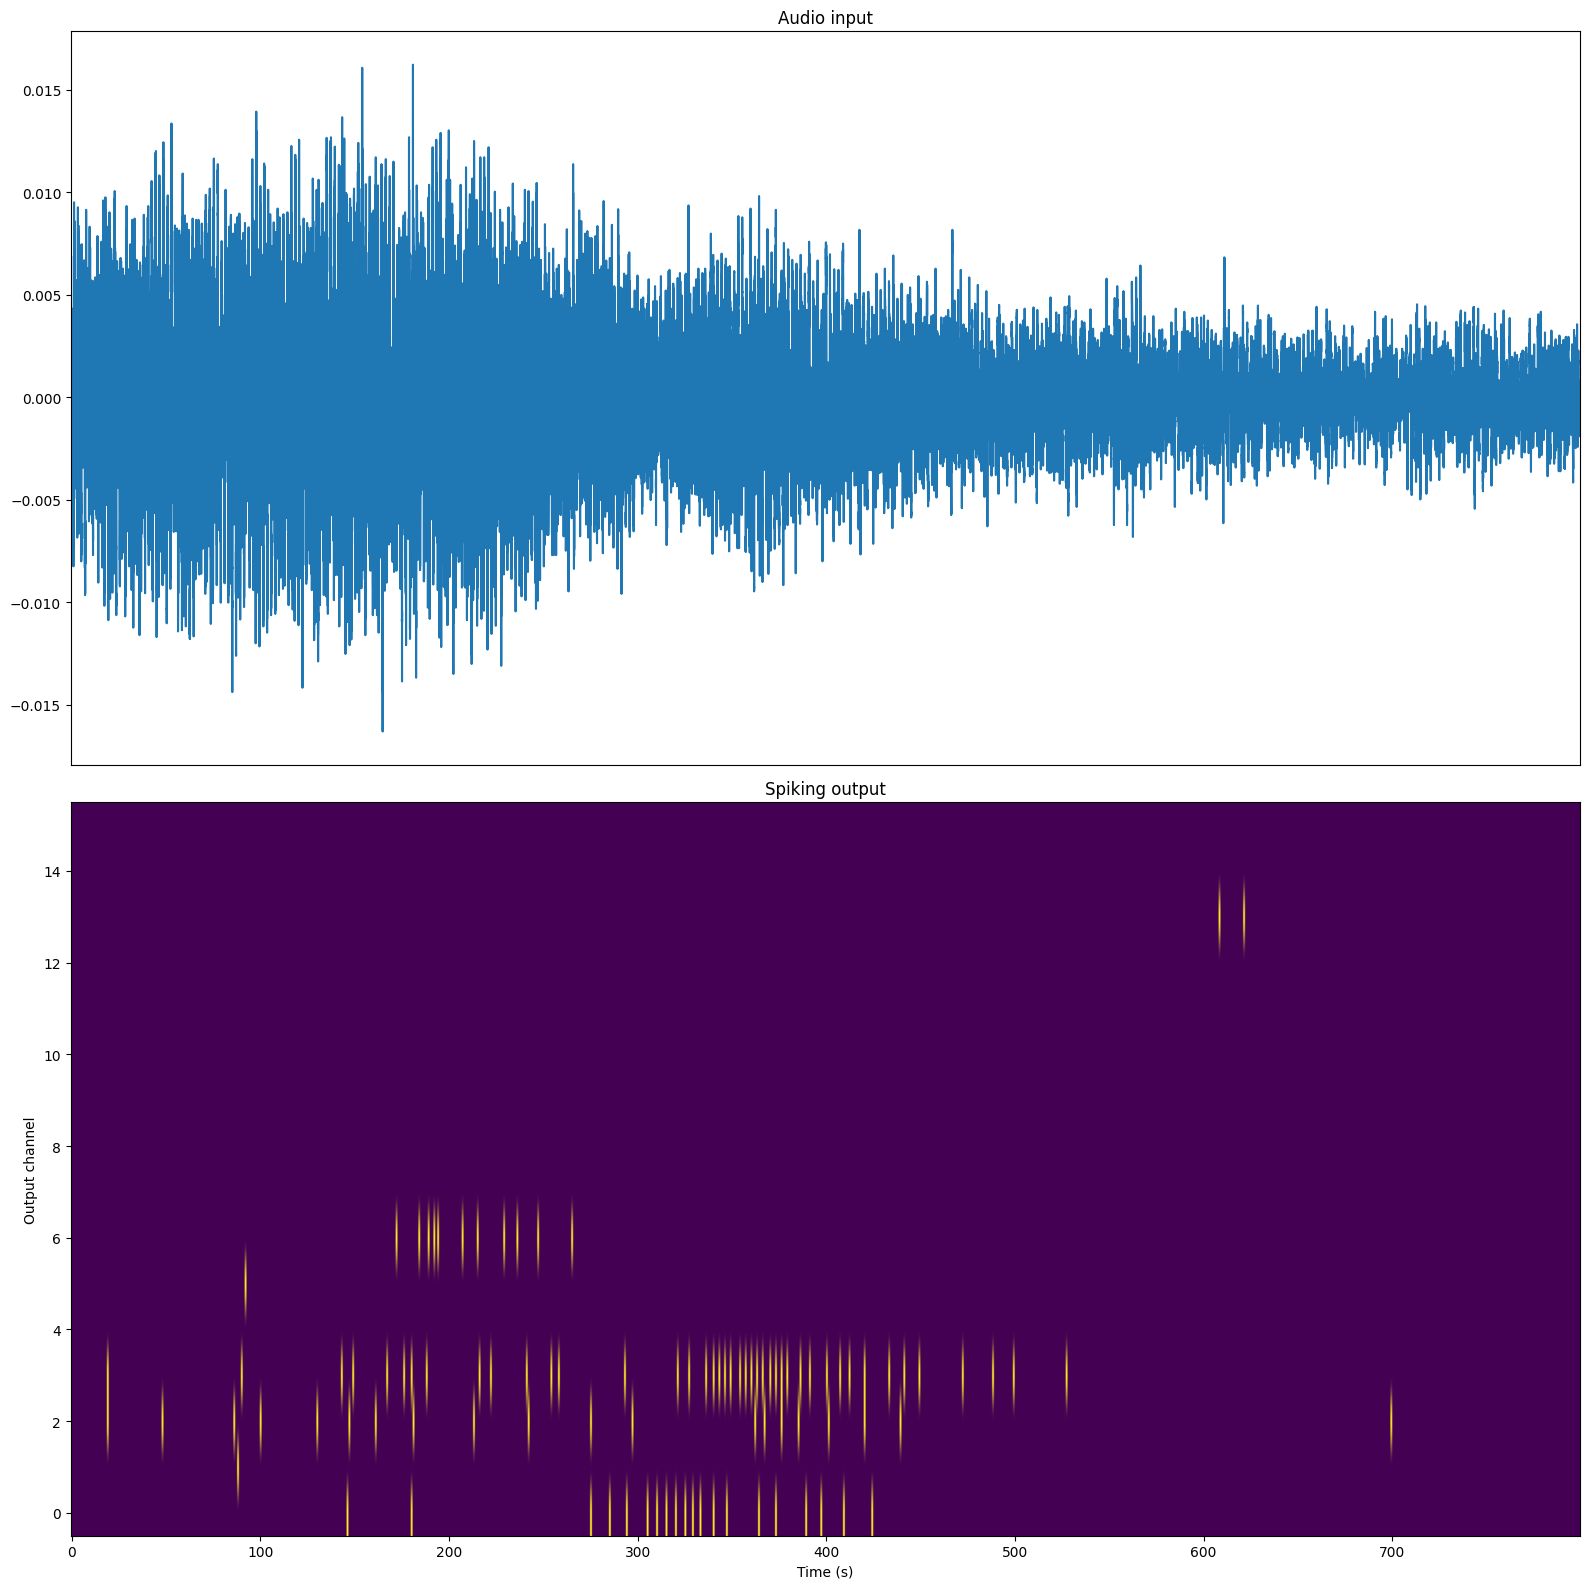

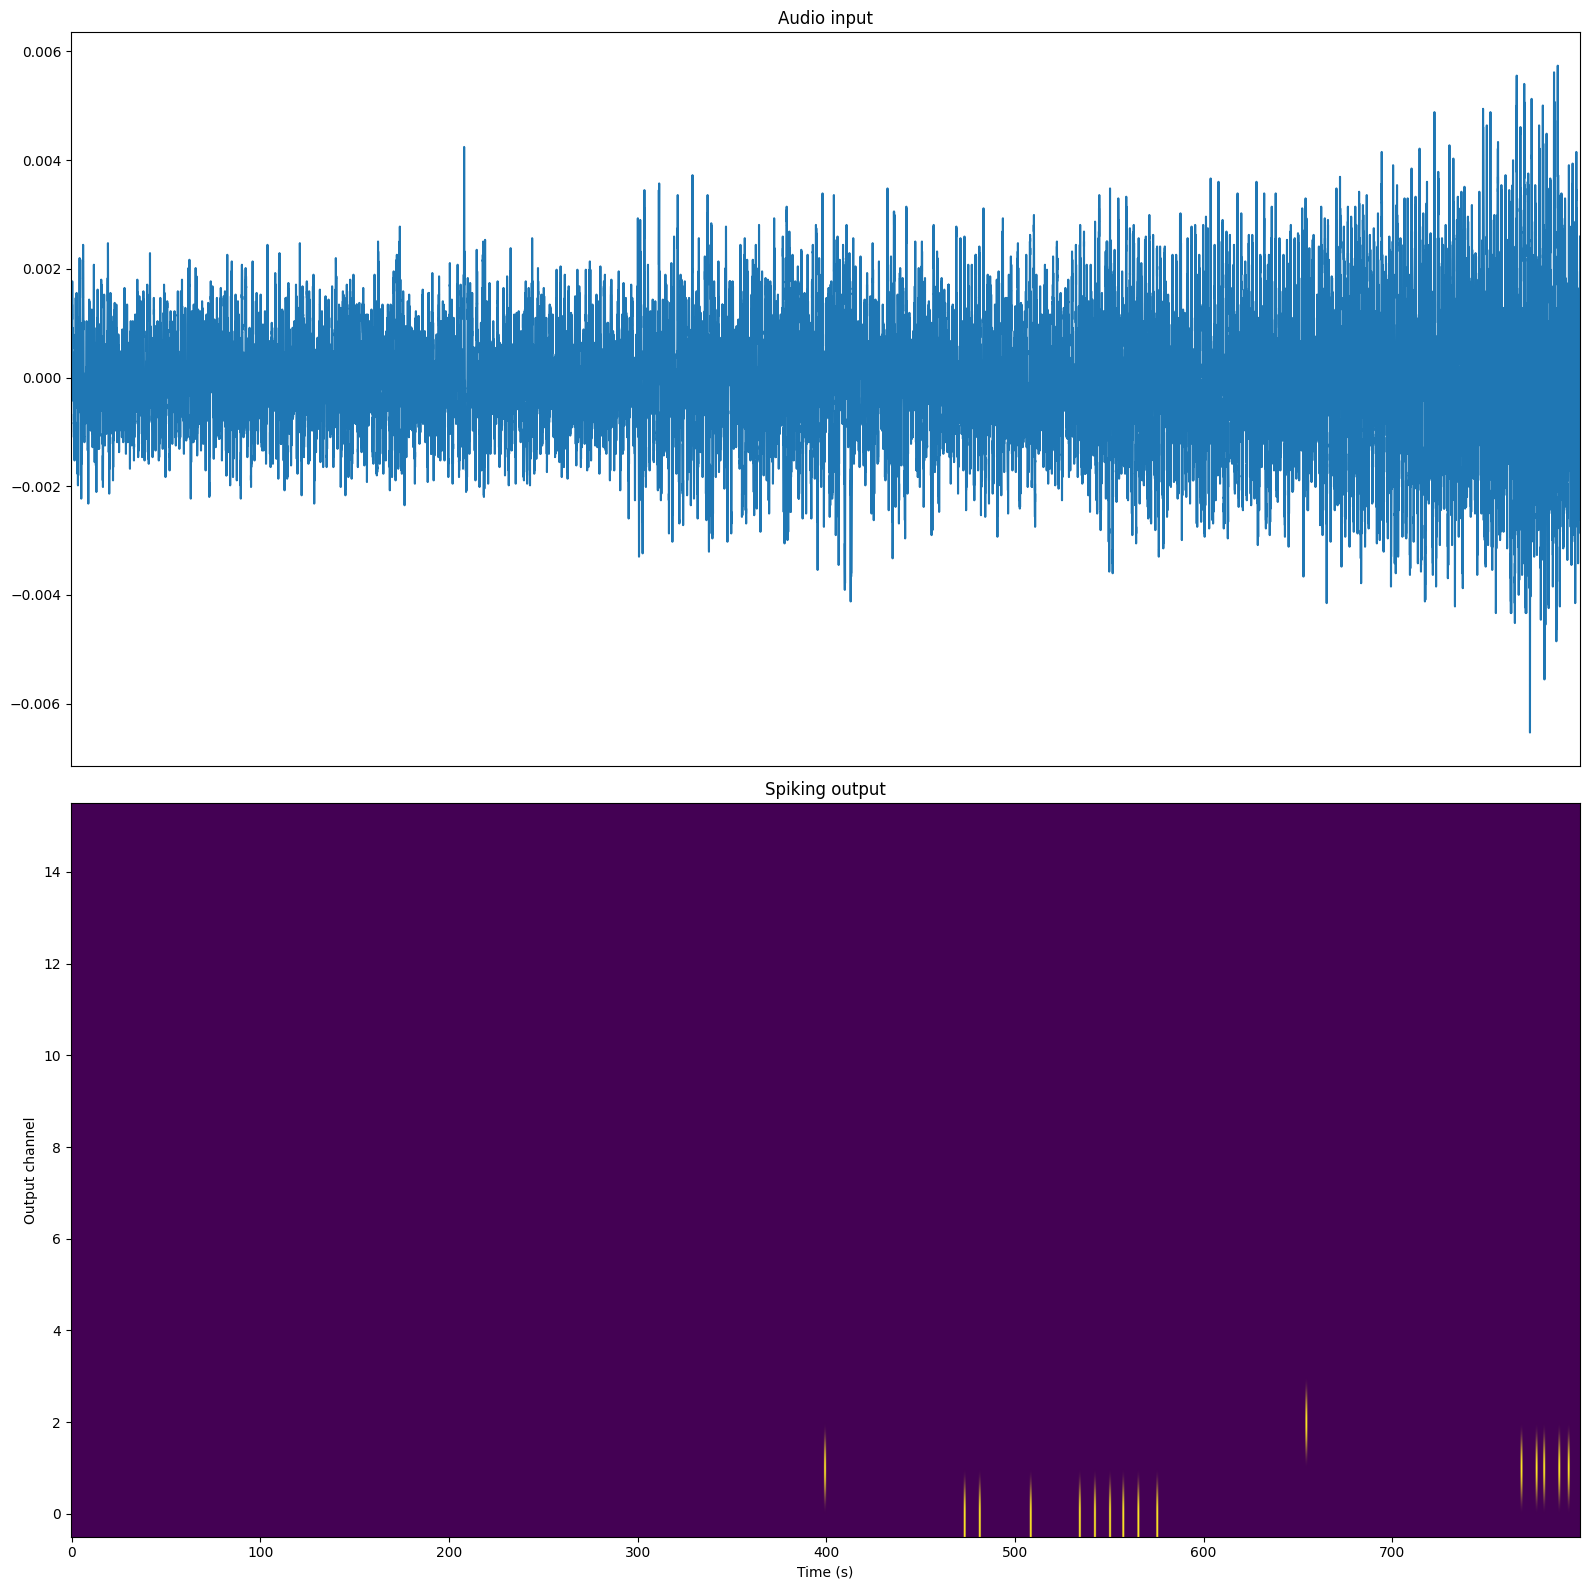

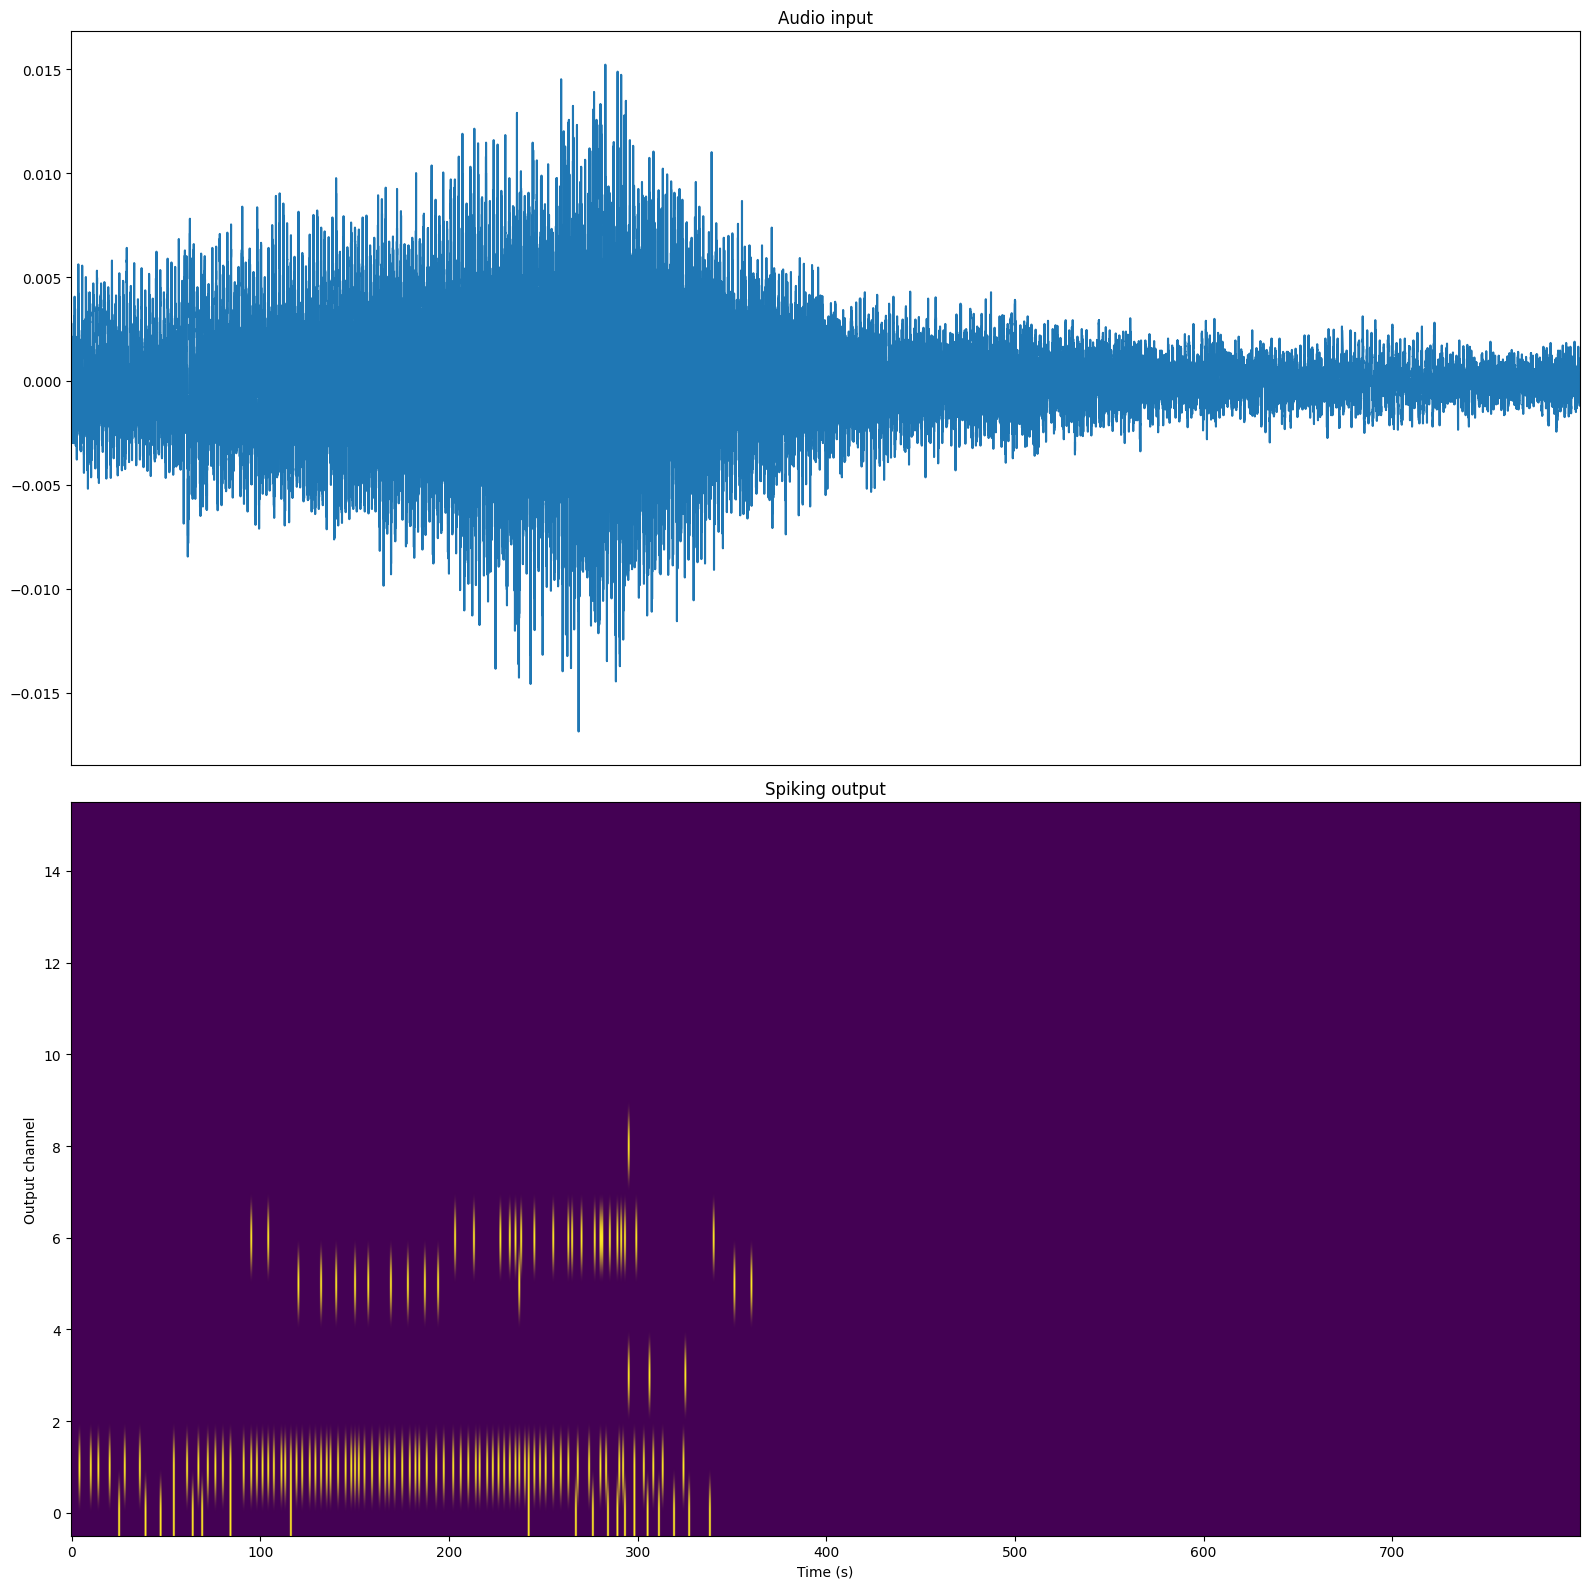

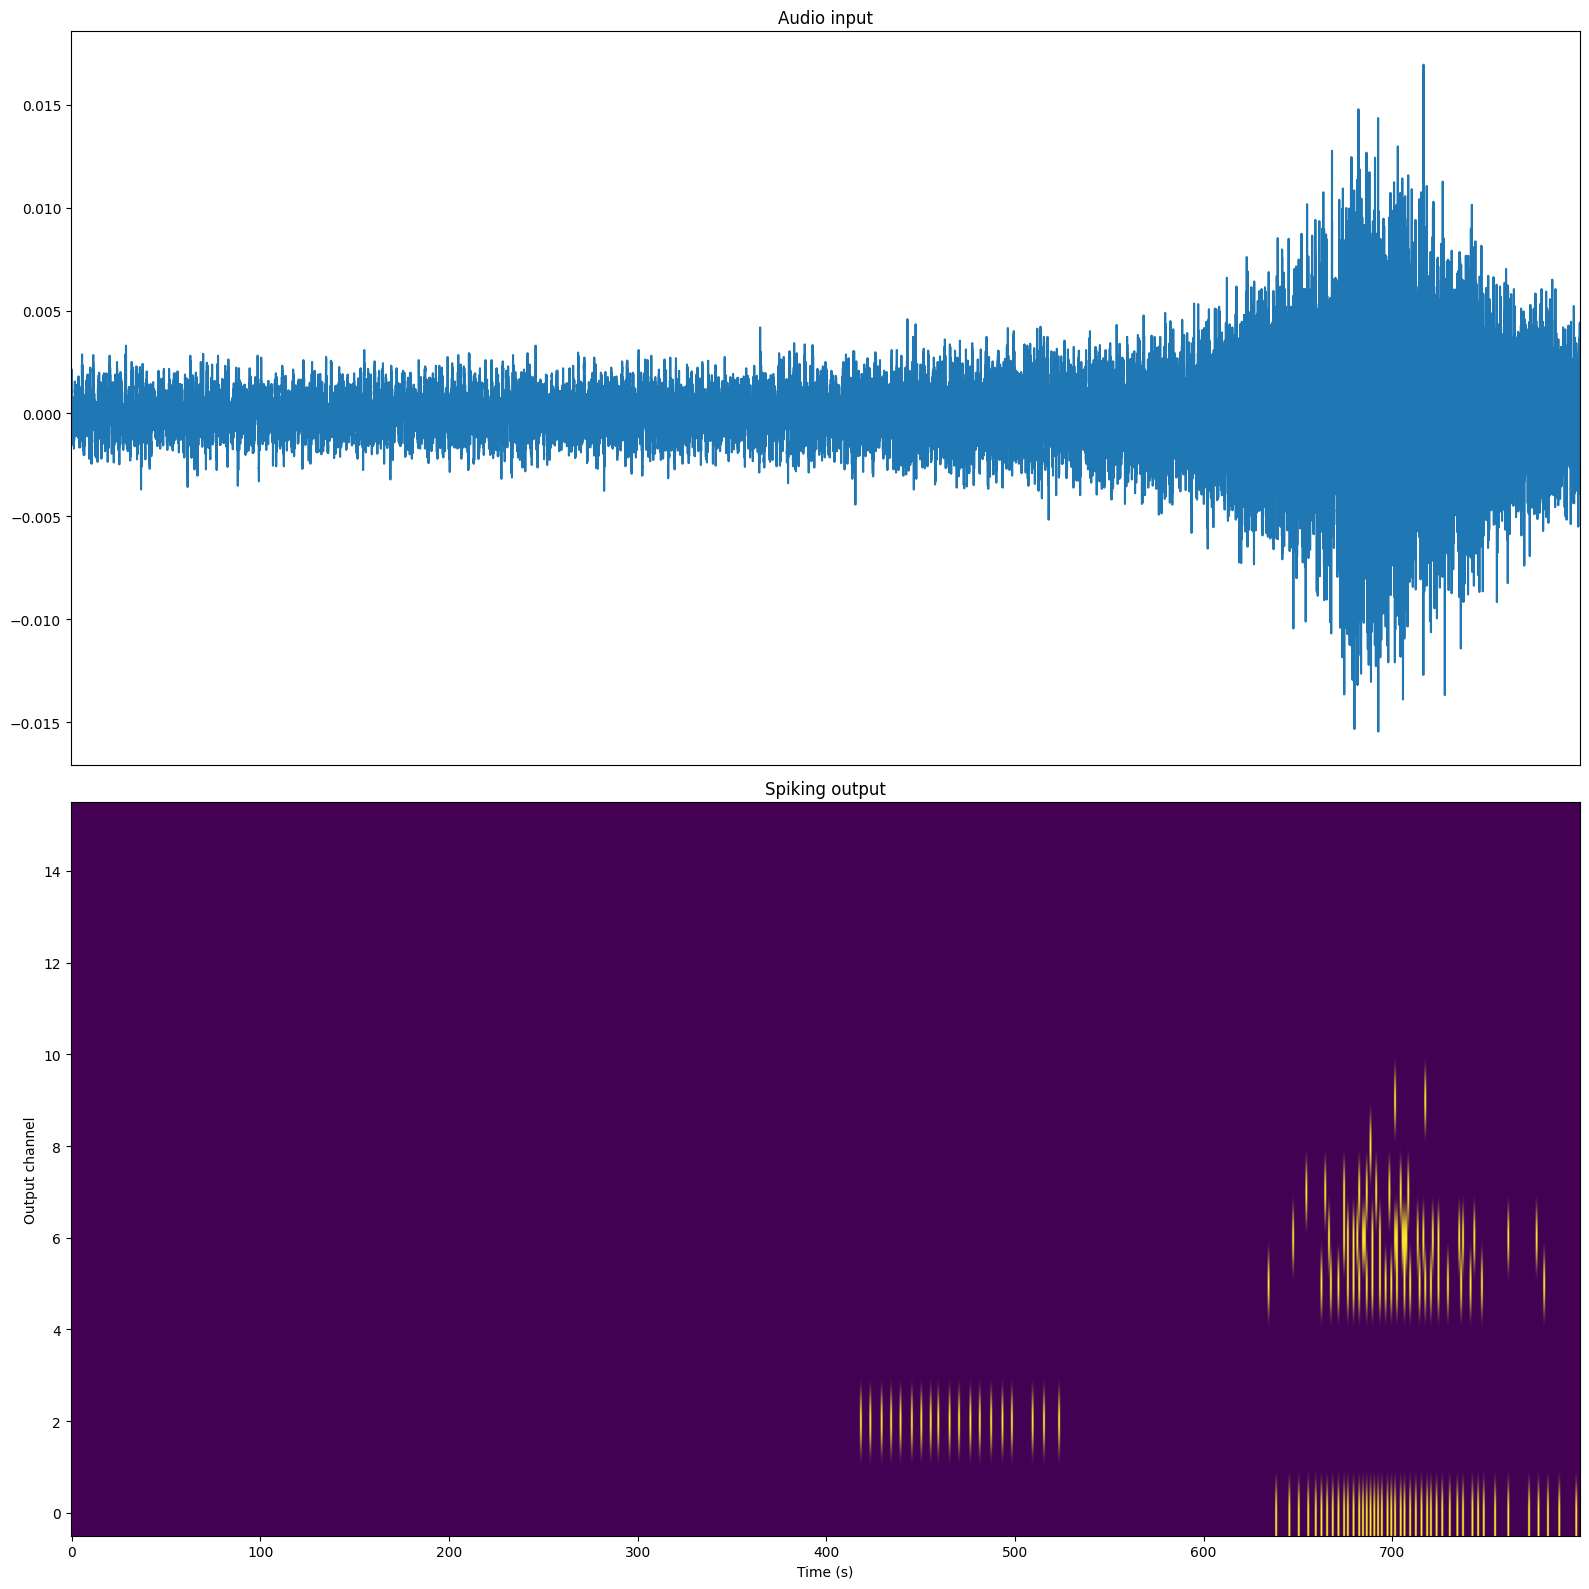

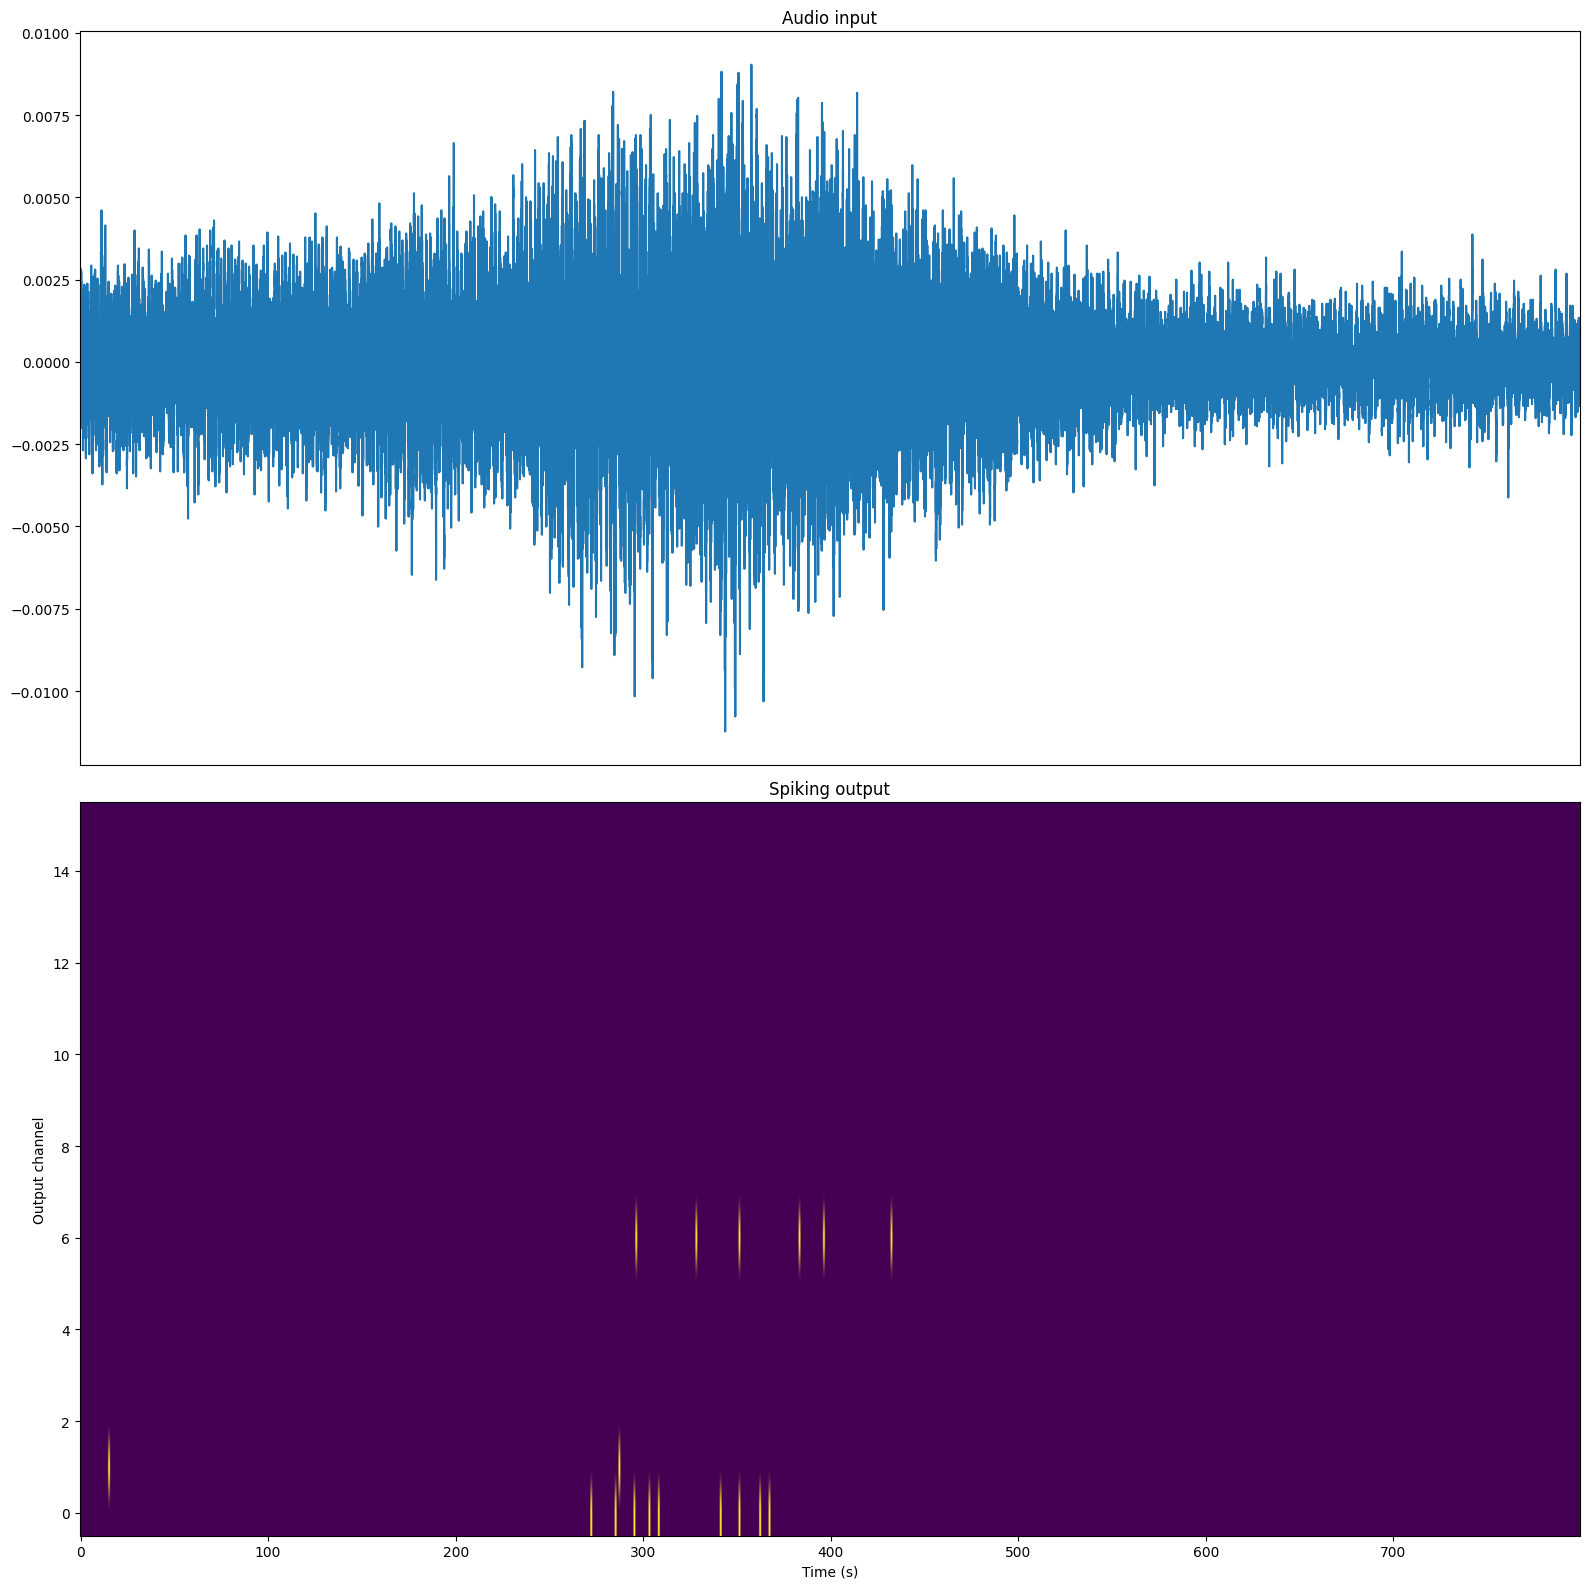

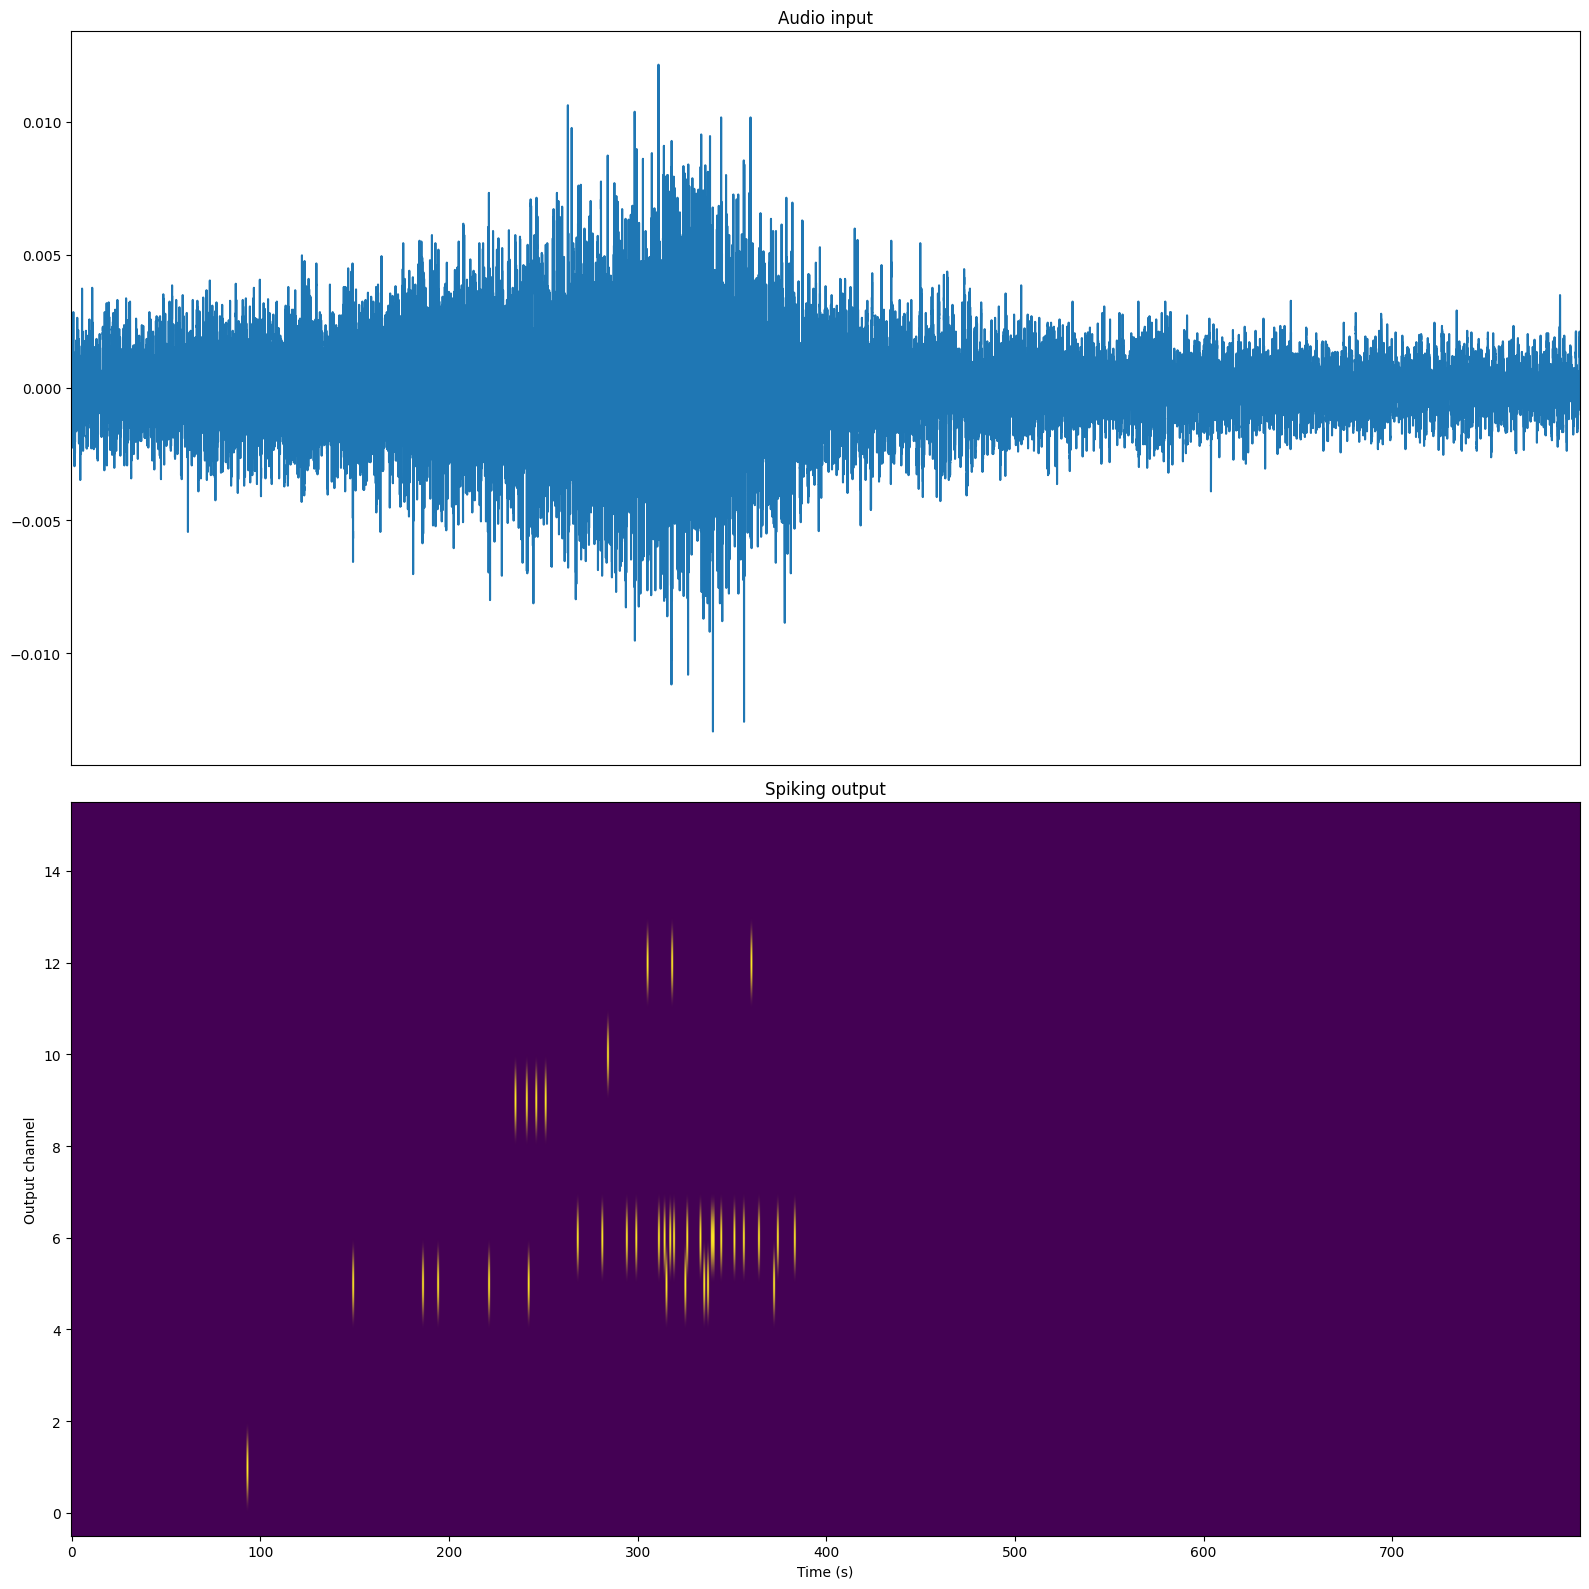

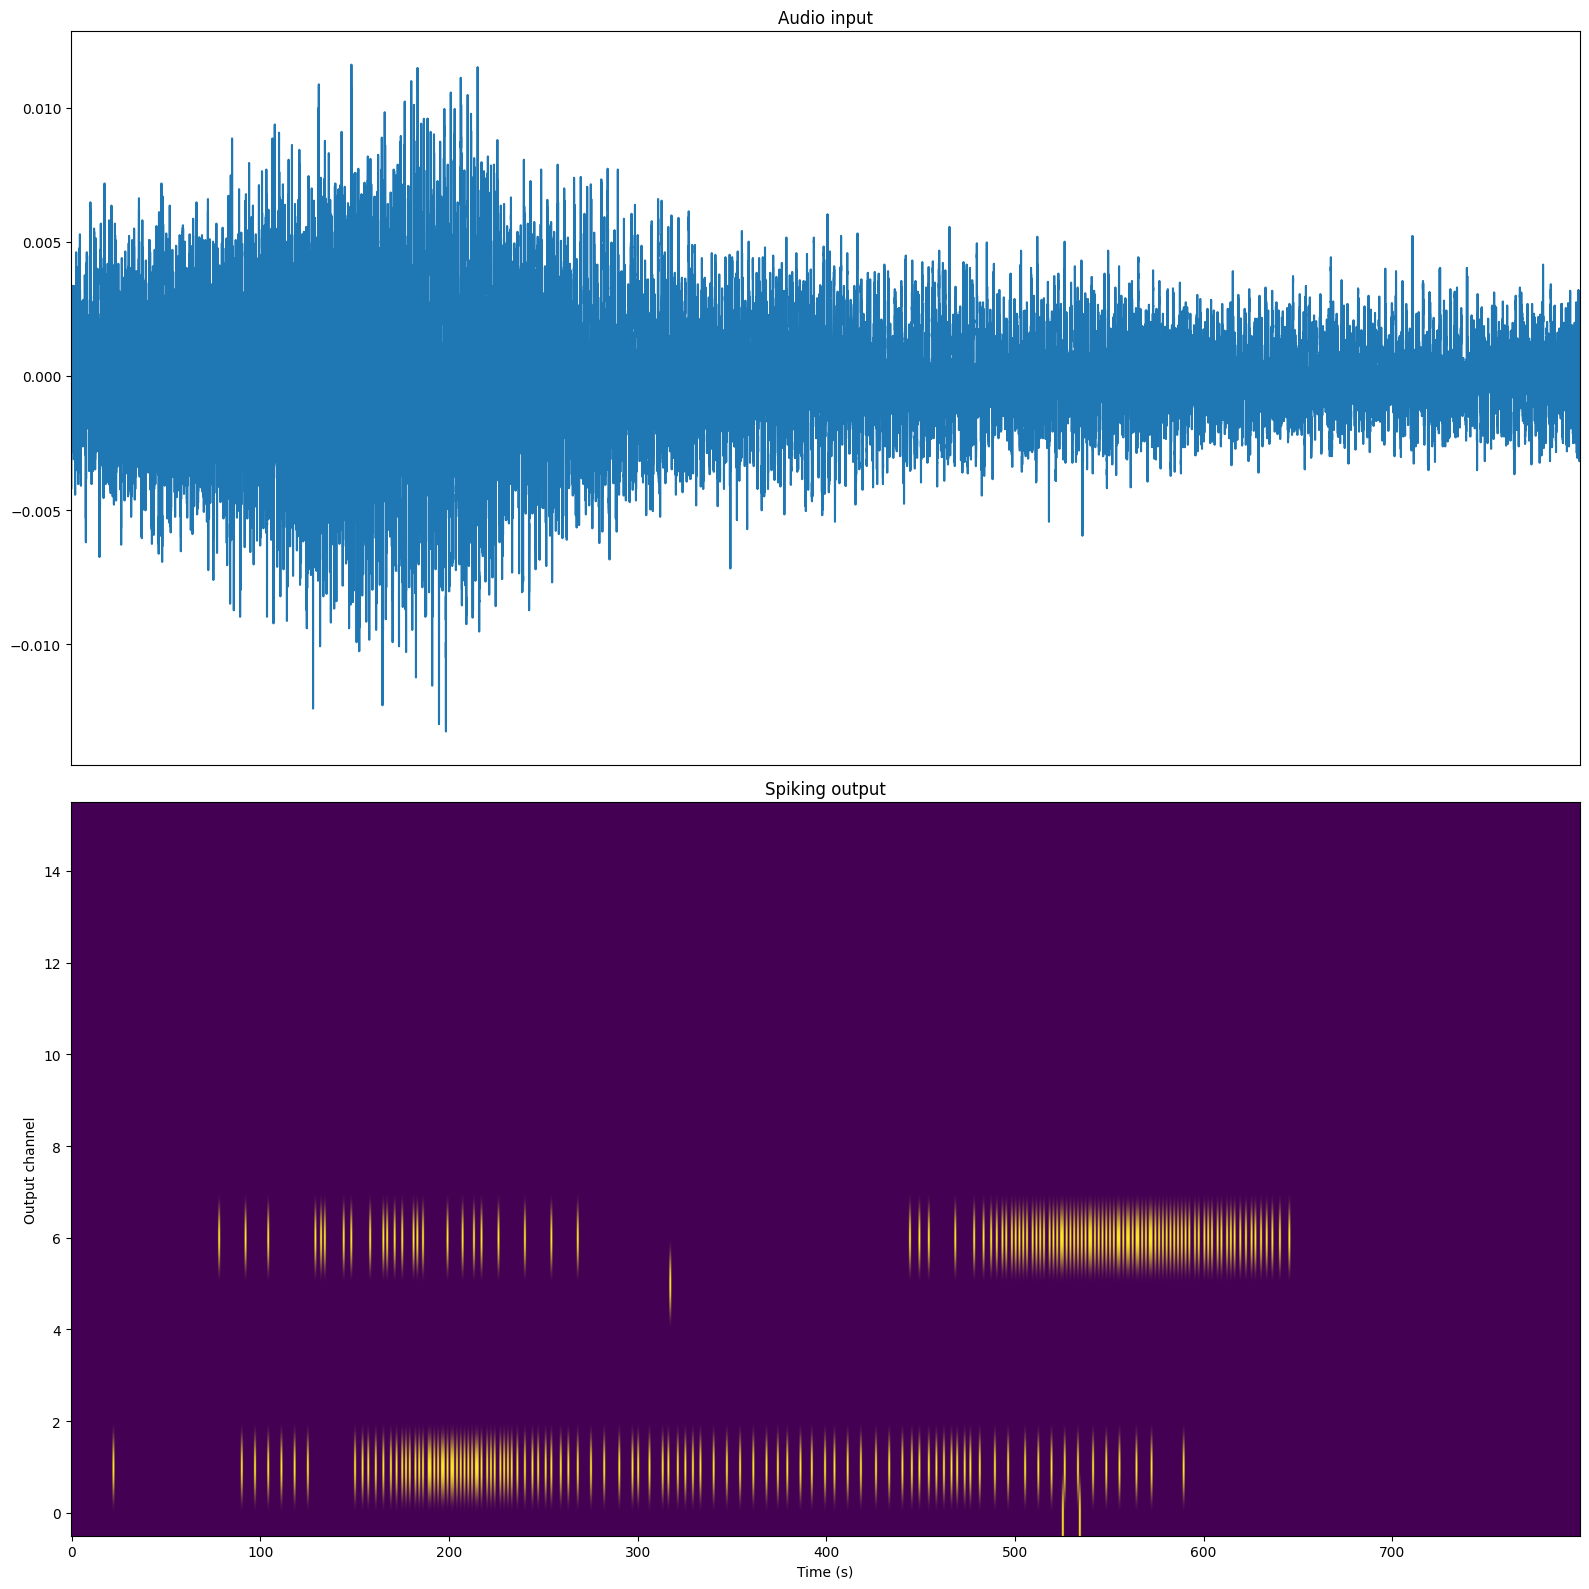

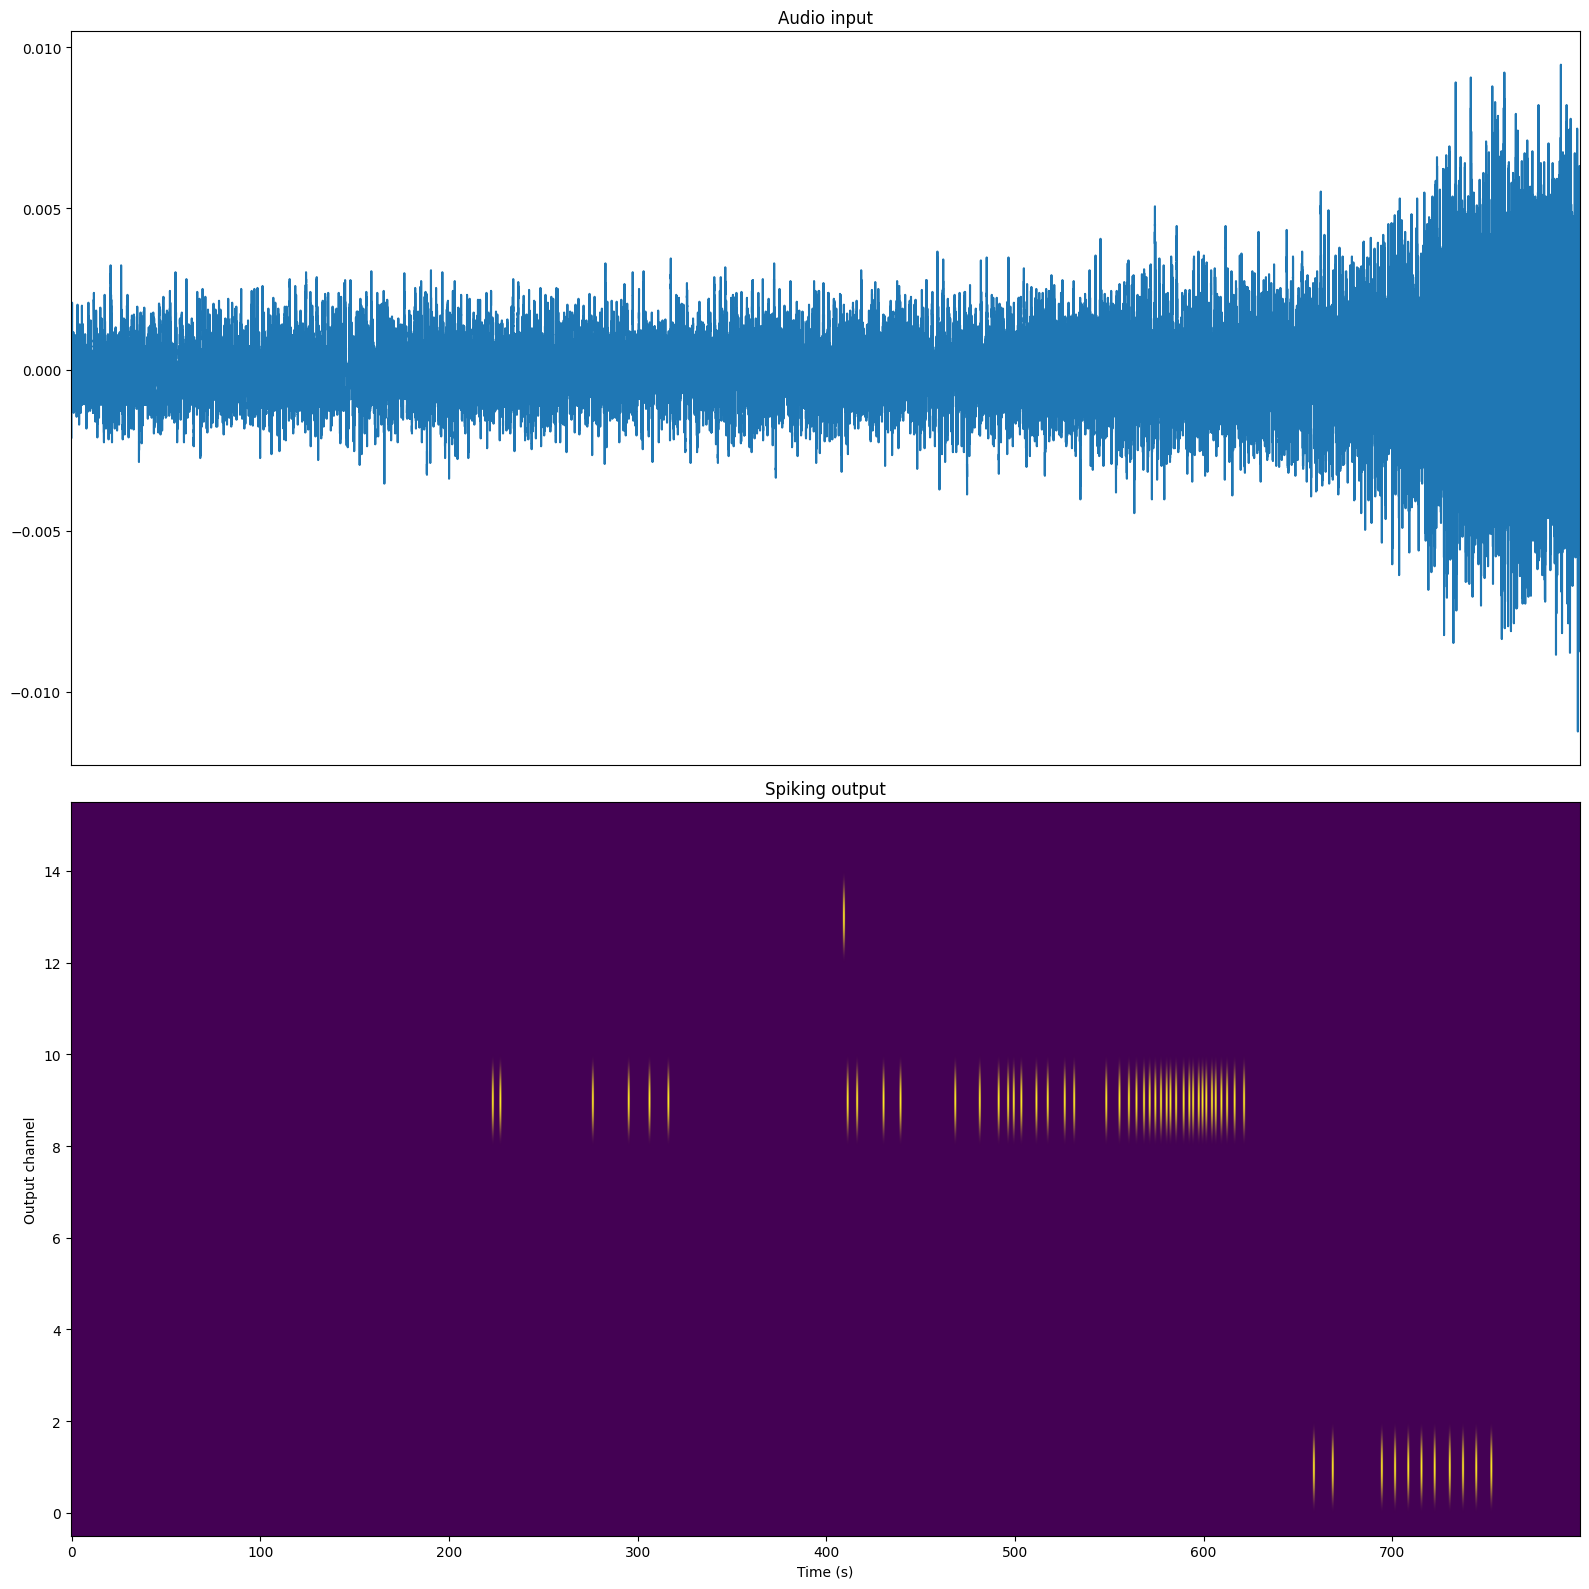

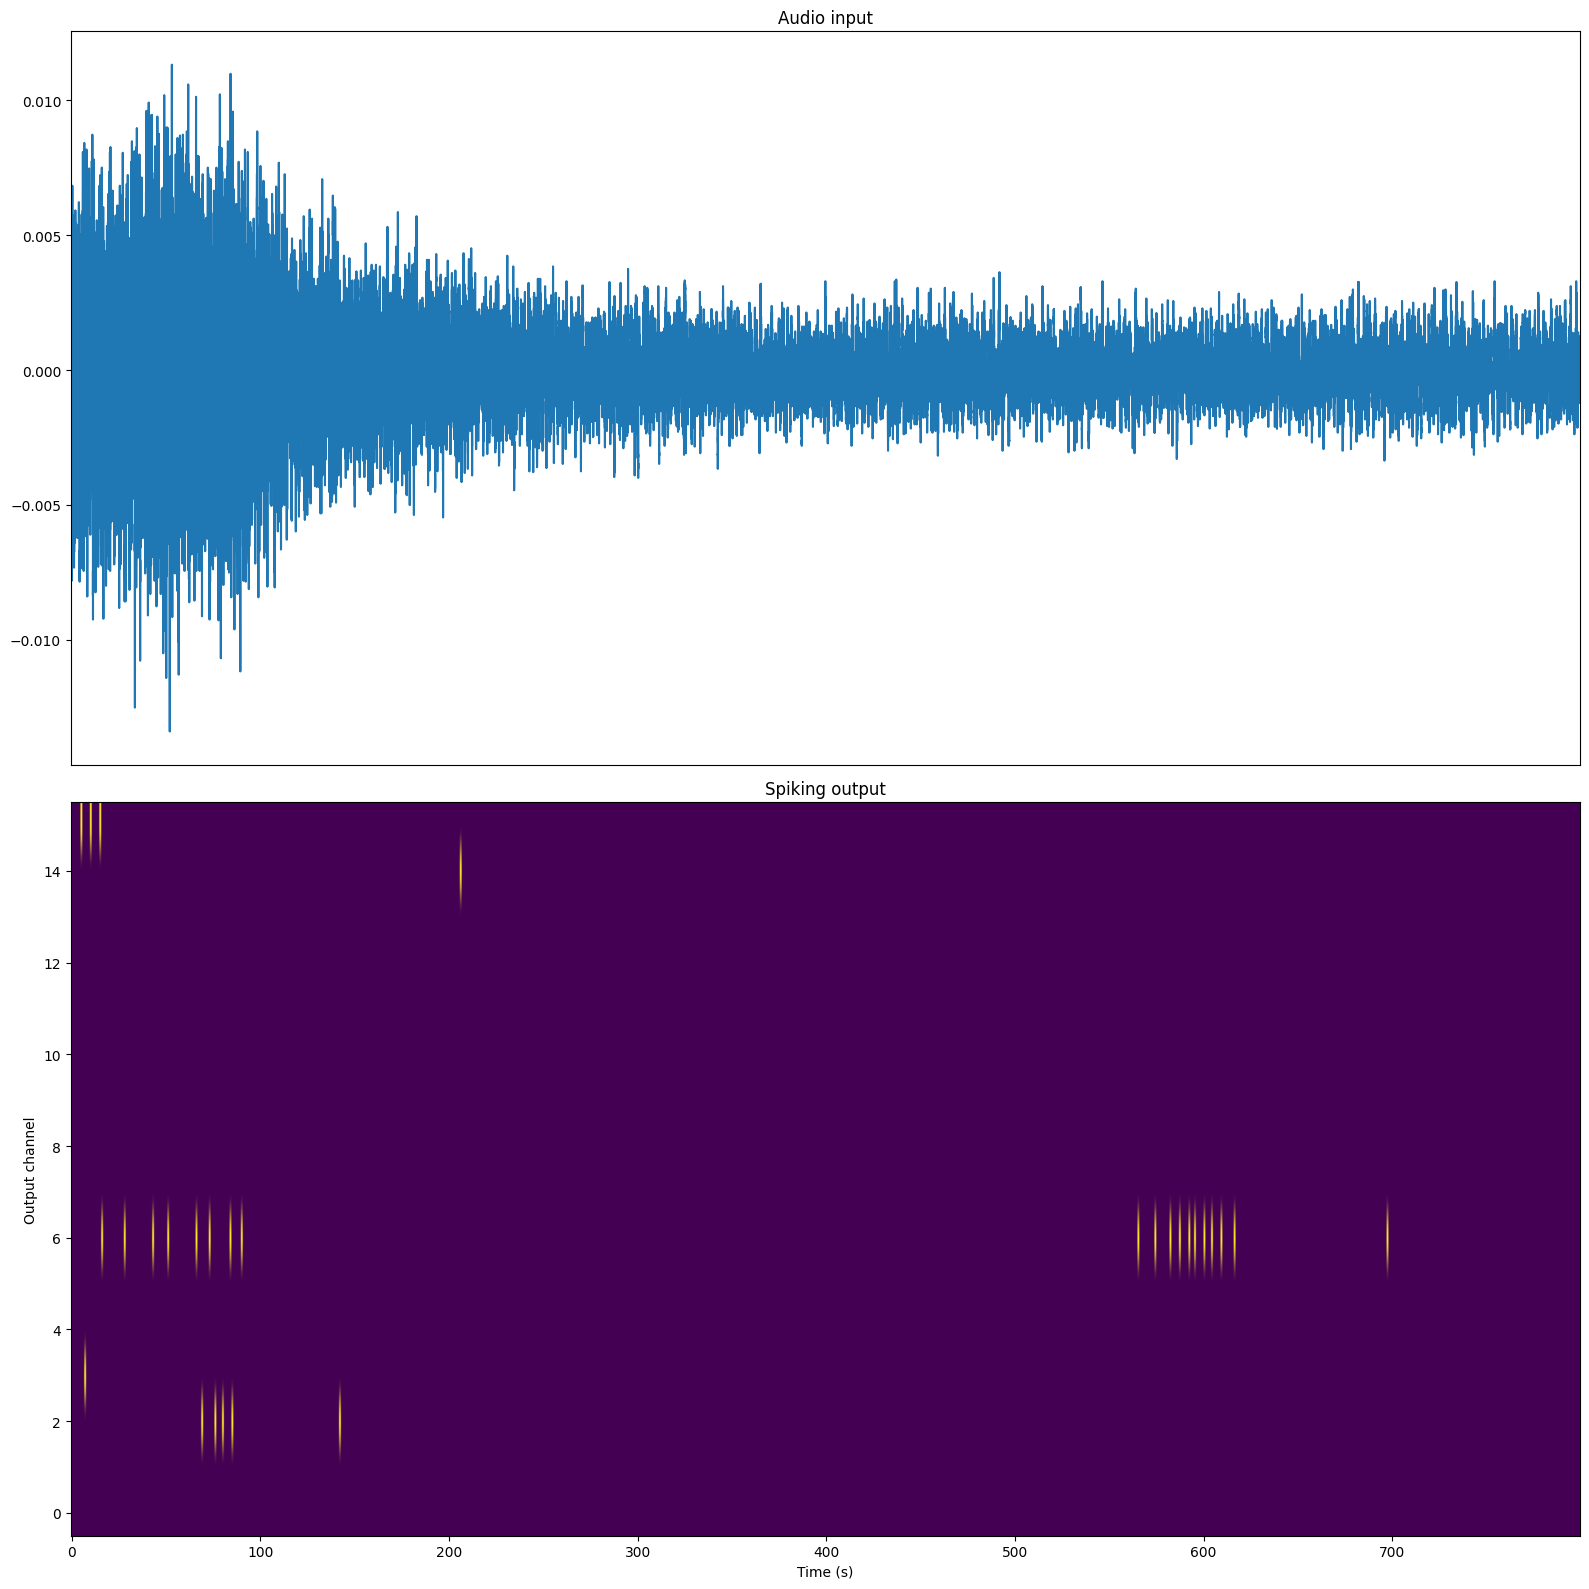

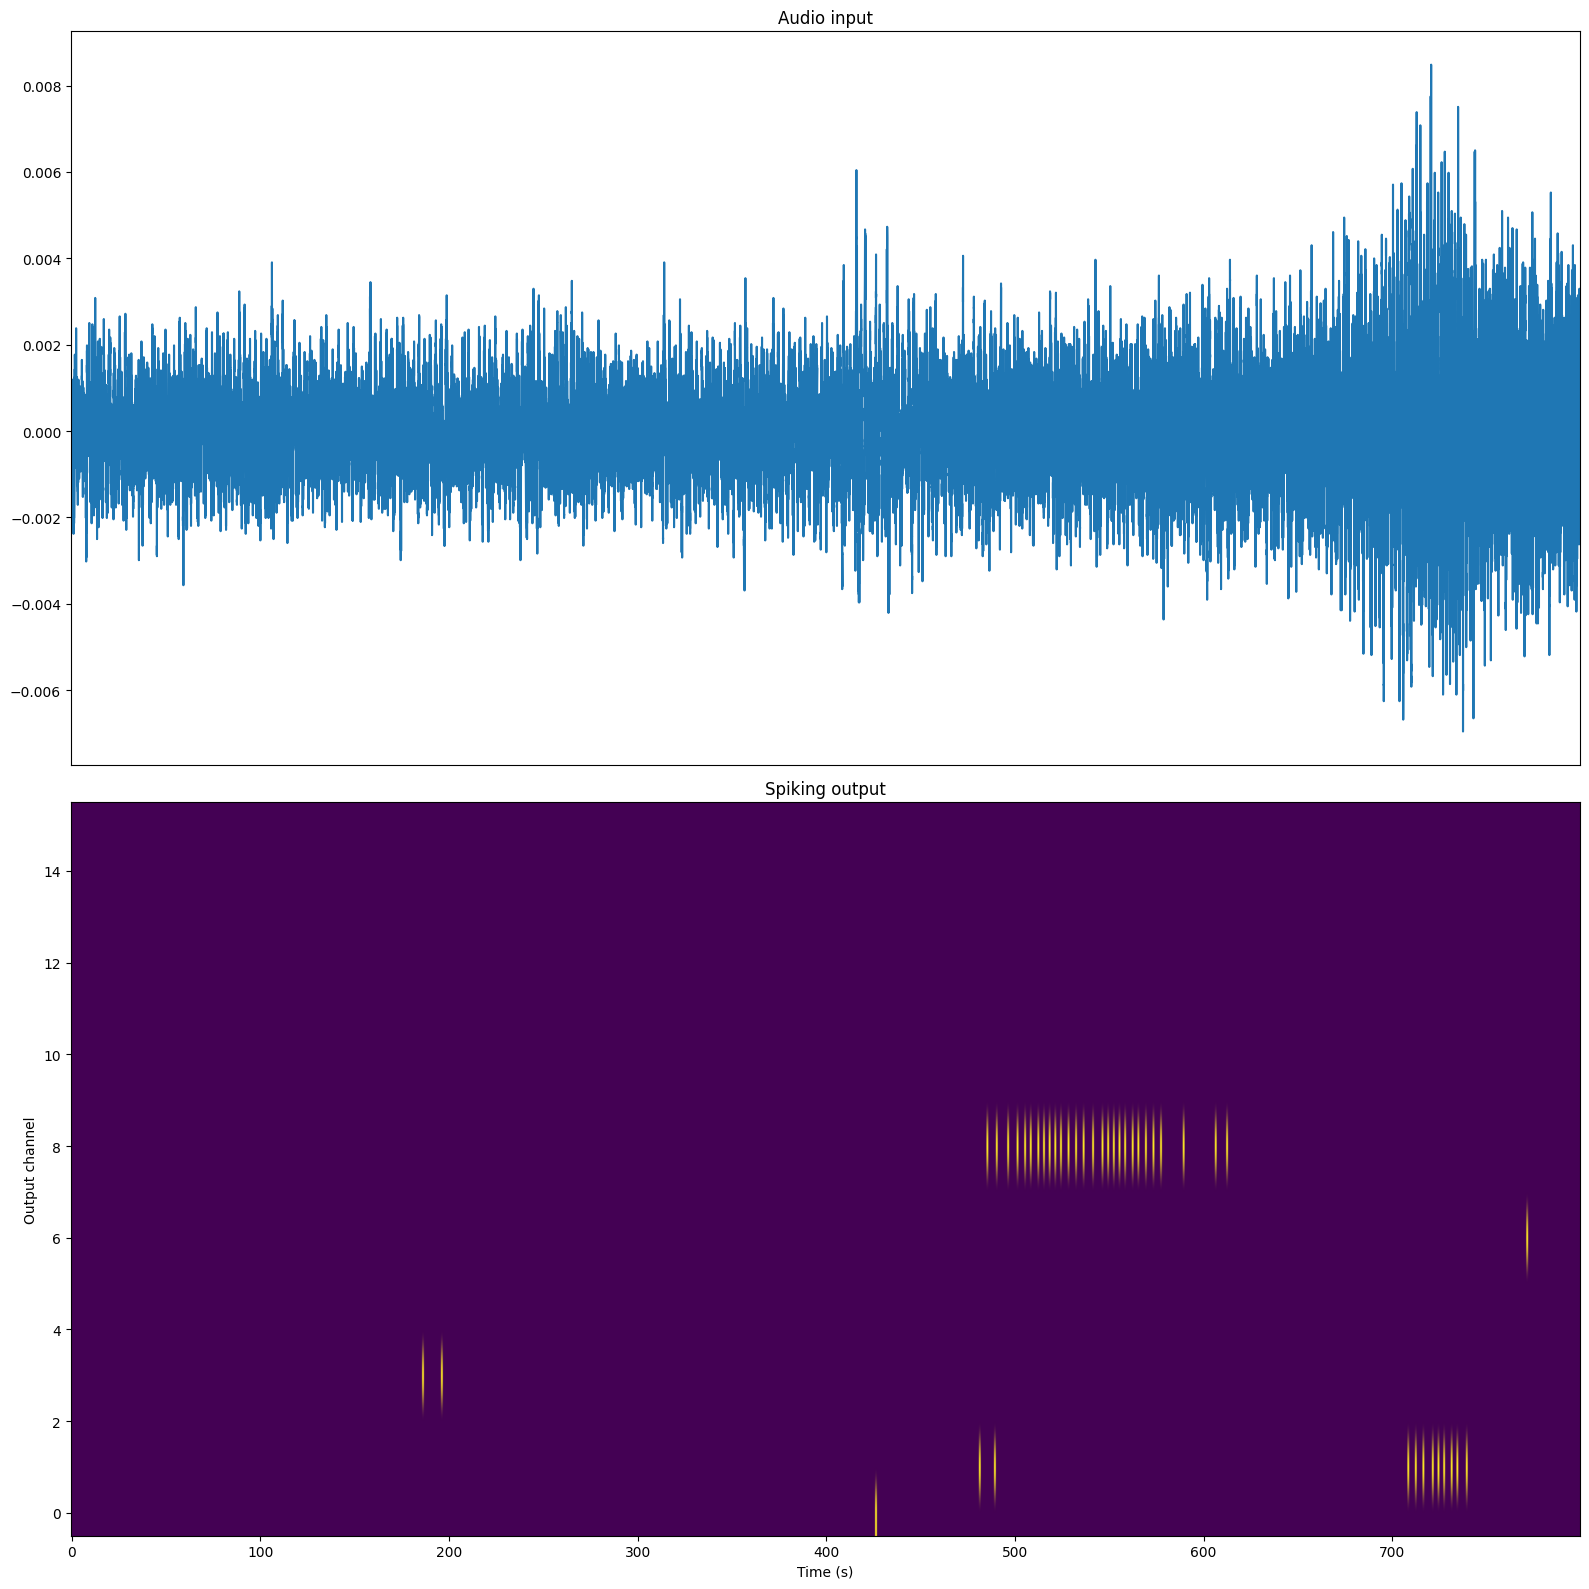

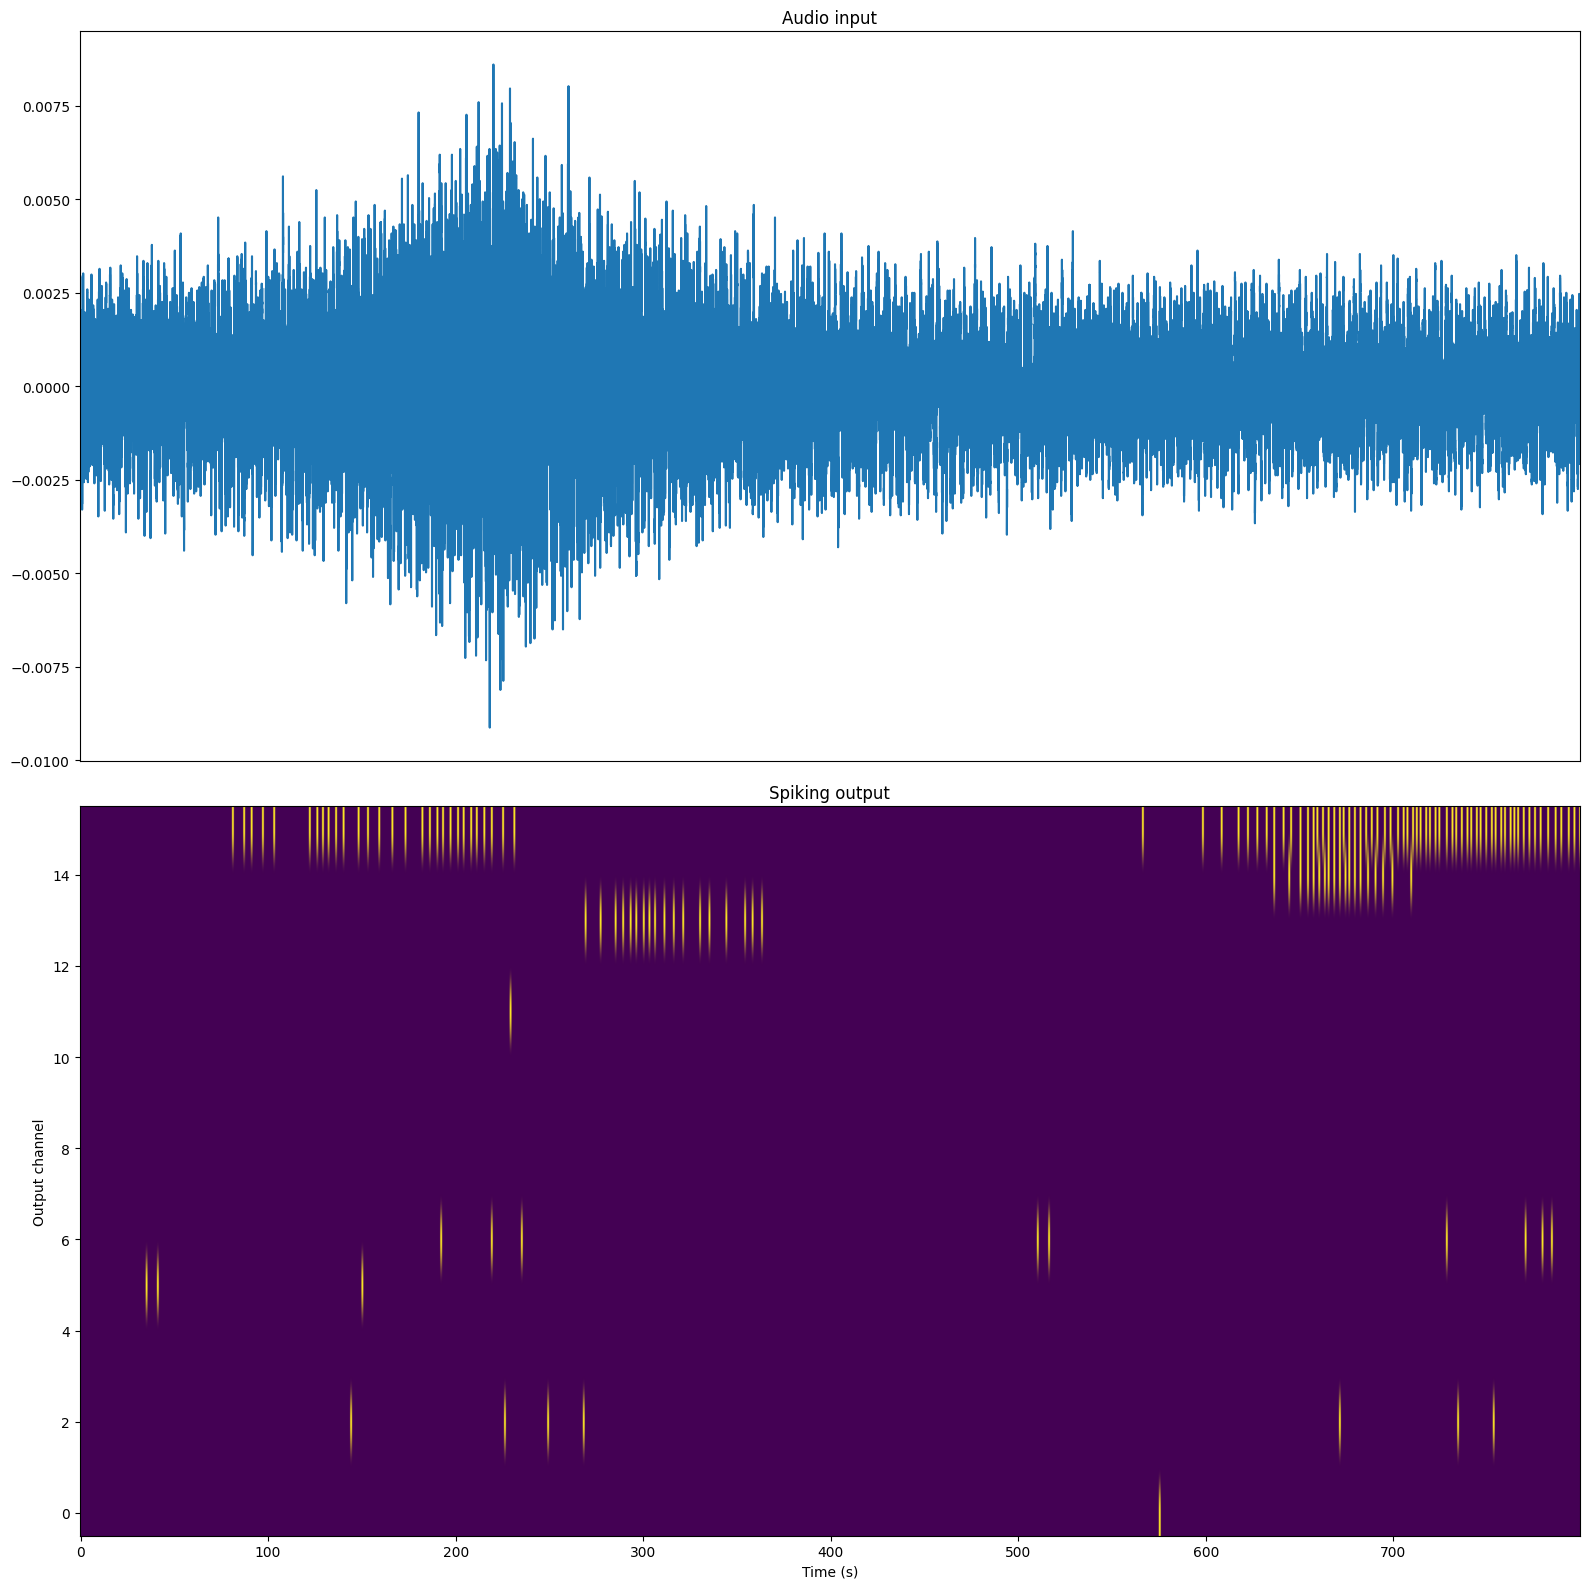

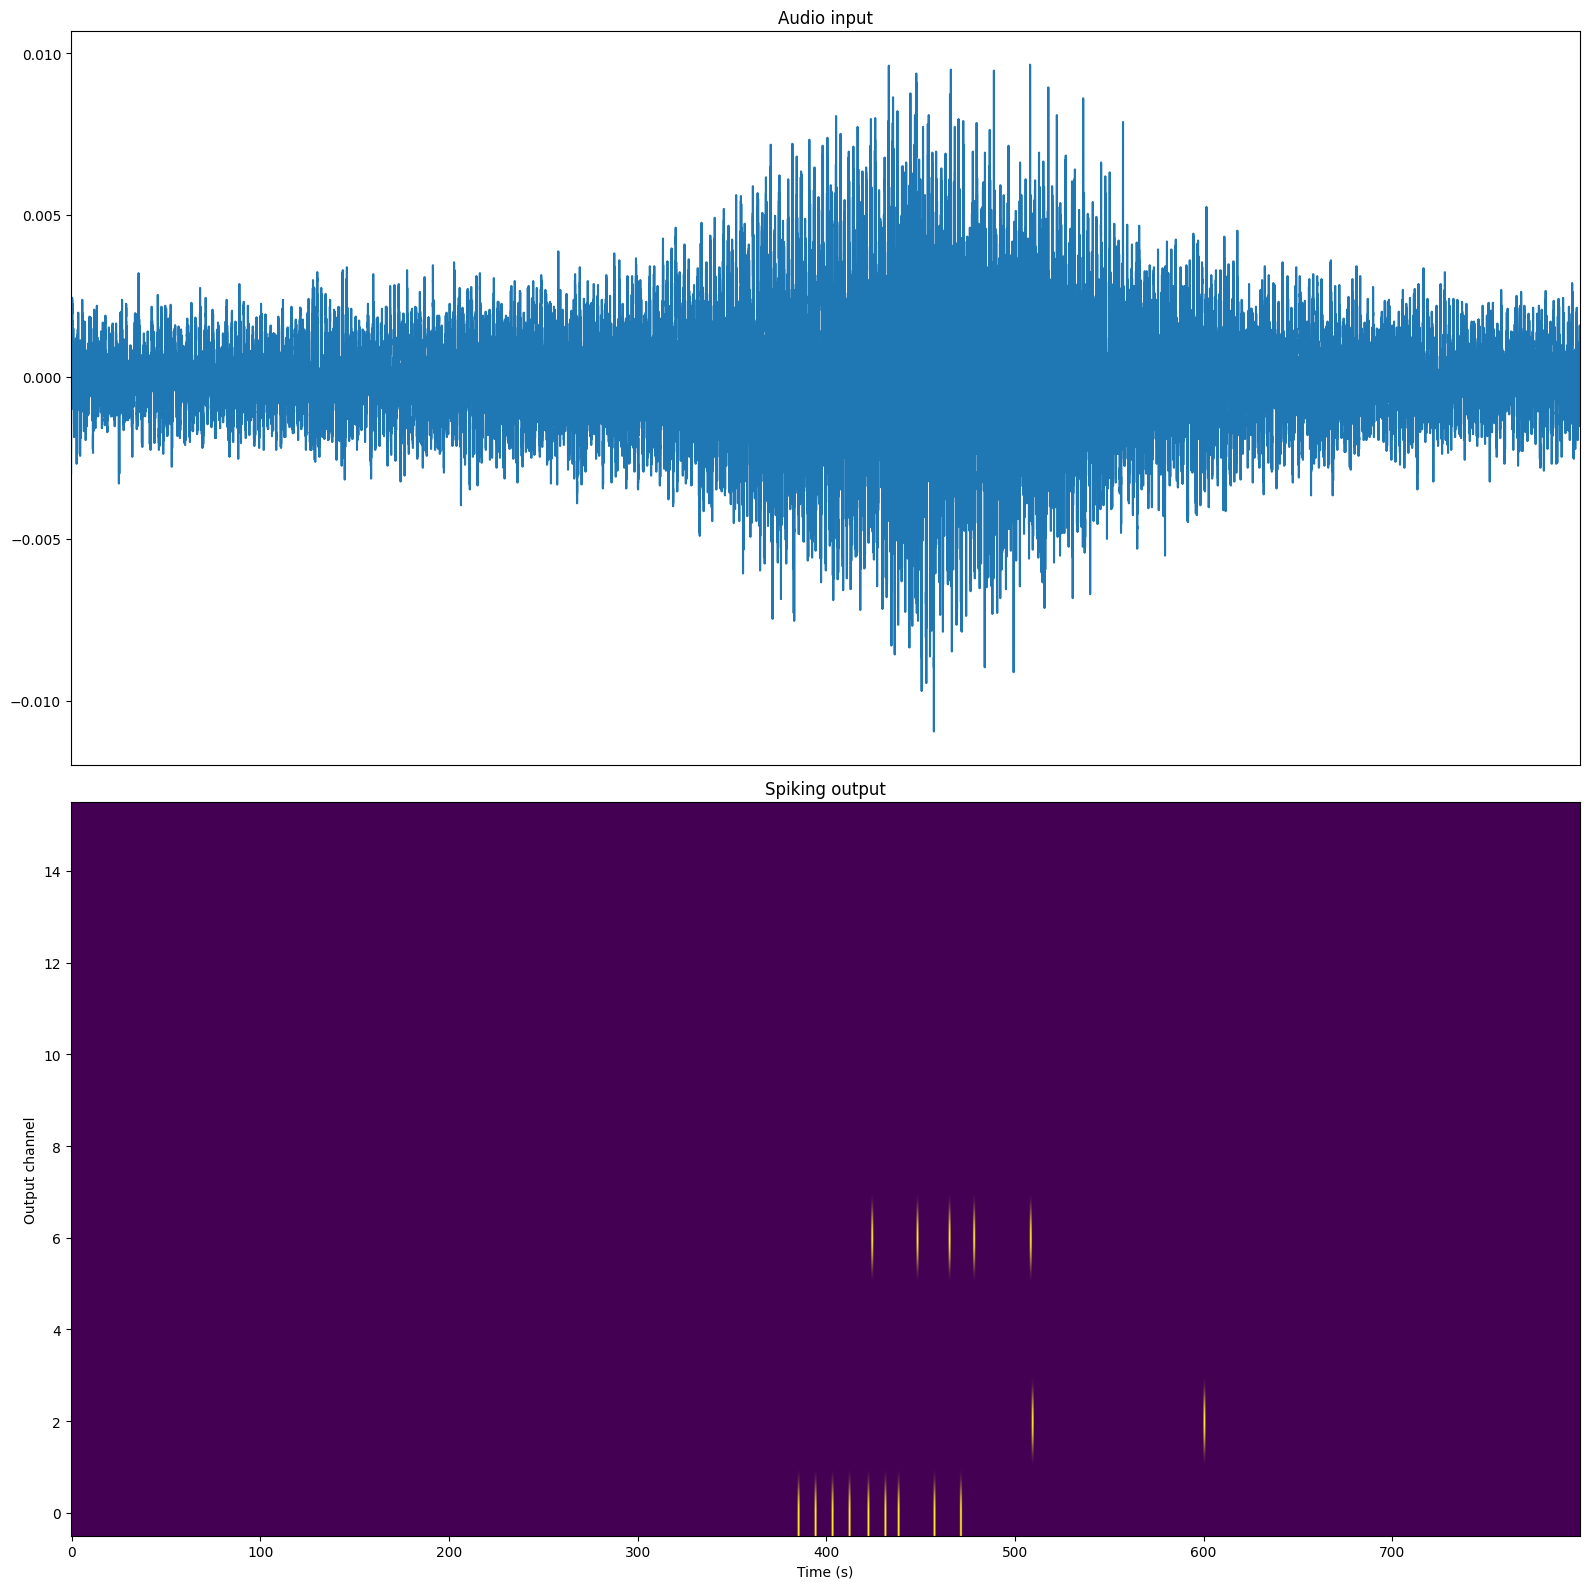

In [ ]:
if __name__ == '__main__':
    logging.basicConfig(
        filename='spike_test.log',
        level=logging.INFO,
        format='%(asctime)s %(levelname)s %(message)s'
    )
    base_dir = os.path.dirname(os.path.abspath('__file__'))
    project_root = os.path.abspath(os.path.join(base_dir, '..', '..'))

    audio_files = [
        os.path.join(r, f)
        for r, _, files in os.walk(project_root)
        for f in files if f.lower().endswith(('.flac'))
    ]

    seg_dir = os.path.join(base_dir, 'segments')
    spike_dir = os.path.join(base_dir, 'npy')
    os.makedirs(seg_dir, exist_ok=True)
    os.makedirs(spike_dir, exist_ok=True)

    csv_path = os.path.join(spike_dir, 'labels.csv')
    if os.path.exists(csv_path):
        os.remove(csv_path)

    for audio_path in audio_files[:20]:
        try:
            segs = segment_and_filter(audio_path, seg_dir)
            for seg_path, label, start in segs:
                npy_path = audio_to_features(seg_path, spike_dir)
                # record label
                header = not os.path.exists(csv_path)
                with open(csv_path, 'a') as cf:
                    if header:
                        cf.write('file,label,start\n')
                    cf.write(f"{os.path.basename(npy_path)},{label},{start}\n")
        except Exception as e:
            logging.error(f"Error processing {audio_path}: {e}")